In [338]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
import math
from statistics import mean 
import numpy as np

from skbio.stats.composition import ancom
from skbio.stats.composition import multiplicative_replacement

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


In [244]:
import cx_Oracle

SERVER = 'dboracle.itk.ppke.hu'
PORT = 1521
SERVICE = 'rsc.itk.ppke.hu'
USER = 'metagenome'
PASSWORD = 'LrJPRUS73r84'

class Connection():

    def __init__(self):
        dsn_tns = cx_Oracle.makedsn(SERVER, PORT, service_name=SERVICE)
        self.connection = cx_Oracle.connect(USER, PASSWORD, dsn_tns)

    def get_connection(self):
        return self.connection

    def select(self, sql):
        return pd.read_sql(sql, con=self.connection)

con = Connection()

In [3]:
path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metagenomes_kraken2/QinN_2014.csv', '//gfs/data/curated_metagenomes_kraken2/SchirmerM_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VatanenT_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_kraken2/XieH_2016.csv', '//gfs/data/curated_metagenomes_kraken2

In [4]:
path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_metaphlan2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/YuJ_2015.csv']


In [245]:
def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

In [246]:
class WrongRank(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [389]:
def get_table_and_grouping(df_name, table_files, column_to_group='STUDY_CONDITION', rank='F', 
                           use_percent= True, percent=30, group=None):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    df = get_data_for_sample(table_files[index])
    df_2 = df.loc[df['Rank'] == rank]
    
    if len(df_2) == 0:
        raise WrongRank(rank)
    
    df_2 = df_2[['Sample_ID', 'Name', 'Abundance', column_to_group]]
    df_2 = df_2.loc[[i == i for i in df_2[column_to_group]]]
    
    df_2 = df_2.loc[df_2[column_to_group] != "adenoma"]


    if group is not None:
        df_2[column_to_group] = [group if group in v else "Control" for v in df_2[column_to_group]]
                       
    table = df_2.pivot(index='Sample_ID', columns='Name', values='Abundance')
    
    # Dropping sparse columns
    if use_percent:
        counts = {}
        to_drop = []
        for column in table.columns:
            counts[column] = table[column].loc[table[column].notnull()].count() + table[column].loc[table[column] != 0].count()
            
            if counts[column] < table.shape[1]/100*percent:
                to_drop.append(column)
        table = table.drop(columns = to_drop)
    
    print("Shape of table:", table.shape)
    
    # Handling remaining Nan values and zero values
    table = table.fillna(0)
    table_repl = pd.DataFrame(multiplicative_replacement(table.values),
                      index=table.index,
                      columns=table.columns)

    grouping = df_2[['Sample_ID', column_to_group]].drop_duplicates()
    grouping.index = grouping["Sample_ID"]
    grouping = grouping.drop(columns = ["Sample_ID"])
    
    grouping_ser = grouping[column_to_group]

    return table_repl, grouping_ser

In [497]:
def analyse(table_repl, grouping_ser, dataset_name, method, rank, i):
        
    result_df, percentile_df = ancom(table_repl, grouping_ser)
    
    differences = list(result_df.loc[[i for i in result_df["Reject null hypothesis"]]].index)
    df_list = []
    for d in differences:
        df = pd.DataFrame(percentile_df[50.0].loc[d])
        df_list.append(df.transpose())
    try:
        df_dataset = pd.concat(df_list)
    except:
        return differences
    
    unpivot = pd.DataFrame(df_dataset.unstack(level=1))
    unpivot = unpivot.reset_index()
    unpivot["Abundance"] = unpivot[0]
    unpivot["Name"] = unpivot['level_1']
    unpivot = unpivot.drop(columns=[0, 'level_1'])
    
    grouped = unpivot[["Name", "Abundance"]].groupby("Name").sum()
    unpivot["Proportion"] = 0

    def scale(row):
        name = row.Name
        summed = float(grouped.loc[grouped.index == name]["Abundance"])
        row.Proportion = row.Abundance / summed * 100
        return row
    
    unpivot_scaled = unpivot.apply(scale, axis=1)
    
    g = sns.catplot(x="Name", y="Proportion", hue="Group", data=unpivot_scaled,
                kind="bar", palette="muted")
    g.set_xticklabels(rotation=45)
    g.fig.suptitle(", ".join([dataset_name, method, rank, str(i) + ". iter"]))
    
    g.savefig("_".join([dataset_name, method, rank, str(i)]) + "_features.svg")
    #Selected features' avagrage abundance propotions between CRC and control samples

    return differences

In [532]:
def classification(table_repl, grouping_ser, dataset_name, method, rank, folds = 10):
    
    joined = table_repl.join(grouping_ser)
    joined.reset_index()
    
    table_repl = joined.drop(columns="STUDY_CONDITION")
    grouping_ser = joined["STUDY_CONDITION"]
    
    y = pd.DataFrame(grouping_ser)
    y["CRC"] = y["STUDY_CONDITION"] == "CRC"
    cross_validation_result = []
    selected_features = {}
    
    i = 0
    skf = StratifiedKFold(folds)
    
    for train_index, test_index in skf.split(table_repl, y["CRC"]):
        
        X_train_k, X_test_k = table_repl.iloc[train_index], table_repl.iloc[test_index]
        y_train_k, y_test_k = grouping_ser.iloc[train_index], grouping_ser.iloc[test_index]

        differences = analyse(X_train_k, y_train_k, dataset_name, method, rank, i)
        
        for d in differences:
            if d in selected_features:
                selected_features[d] = selected_features[d] + 1
            else:
                selected_features[d] = 1
               
        try:
            fpr, tpr, roc_auc = classification_iter(X_train_k, X_test_k, y_train_k, y_test_k, differences)
            print("Iter", i, "AUC:", roc_auc)
            cross_validation_result.append((i, fpr, tpr, roc_auc))
            
        except:
            print("Error in classification iter.")
            i = i-1
        i = i+1
    roc_analysis(cross_validation_result, dataset_name, method, rank)
    
    toplot = pd.DataFrame([selected_features]).T
    toplot = toplot.loc[toplot[0] > 1]
    toplot = toplot.sort_values(by=0, ascending = False).T
    g = sns.barplot(data = toplot, palette="coolwarm")
    g.set_xticklabels(rotation=45, labels=g.get_xticklabels())
    g.set_title(", ".join([dataset_name, method, rank]))
    
    fig = g.get_figure()
    fig.savefig("_".join([dataset_name, method, rank]) + "_columns.svg")
    
    T.loc[T[0] > 1]
    return pd.DataFrame([selected_features])

    

In [479]:
def classification_iter(X_train_k, X_test_k, y_train_k, y_test_k, differences):
        
    # Dropping not not significant columns
    to_drop = set(X_train_k.columns) - set(differences)
    X_train = X_train_k.drop(columns = list(to_drop))
    if len(X_train.columns) == 0:
        print("No feature was selected.")
        return
    X_test = X_test_k.drop(columns = list(to_drop))
    
    y_train_k = pd.DataFrame(y_train_k)
    y_test_k = pd.DataFrame(y_test_k)
    
    y_train_k["CRC"] = y_train_k["STUDY_CONDITION"] == "CRC"
    y_test_k["CRC"] = y_test_k["STUDY_CONDITION"] == "CRC"
    
    y_train = y_train_k["CRC"] 
    y_test = y_test_k["CRC"]
    
    train = X_train.join(y_train)
    train_x = train.drop(columns=["CRC"])
    train_y = train["CRC"]
                         
    test = X_test.join(y_test)
    test_x = test.drop(columns=["CRC"])
    test_y = test["CRC"]
    # Logisztikus regresszió
    logisticRegr = LogisticRegression(solver='lbfgs' )

    logisticRegr.fit(train_x, train_y)

    #Konfidencia scoreok a teszt halmazhoz
    y_score = logisticRegr.decision_function(test_x)

    #ROC görbe számolása
    fpr, tpr, _ = roc_curve(test_y, y_score)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

In [555]:
def roc_analysis(result, dataset_name, method, rank):
    df_list = []
    for row in result:
        list_of_tuples = list(zip(row[2], row[1]))
        df = pd.DataFrame(list_of_tuples, columns = ["TPR", "FPR"])  
        df["Iteration"] = row[0]
        df["AUC"] = row[3]
        df_list.append(df)
    concat = pd.concat(df_list)
    result_table = concat

    fig = plt.figure(figsize=(8,6))
    for i in result_table["Iteration"].drop_duplicates().values:
        auc_val = result_table.loc[result_table["Iteration"] == i]["AUC"][0]
        plt.plot(result_table.loc[result_table["Iteration"] == i]['FPR'], 
                 result_table.loc[result_table["Iteration"] == i]['TPR'],              
                 label=str(i)+'. fold AUC = %0.2f' % auc_val)
    
    mean_auc = result_table["AUC"].mean()
    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(", ".join([dataset_name, method, rank, 'mean AUC =  %0.2f' % mean_auc]), fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')
    
    plt.savefig("_".join([dataset_name, method, rank]) + "_ROC.png")
    plt.show()

In [481]:
def run(dataset_name, method, rank, percent):
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Method should be 'Kraken' or 'Metaphlan'")
            raise 
    table_repl, grouping_ser = get_table_and_grouping(dataset_name, table_files, 
         column_to_group='STUDY_CONDITION', rank=rank, use_percent= True, percent=percent, group=None)
    
    return classification(table_repl, grouping_ser, dataset_name, method, rank)
    

In [553]:
methods = ["Metaphlan", "Kraken"]
datasets = ["FengQ_2015", "VogtmannE_2016"]
ranks_m = ["p", "c", "f", "g"]
ranks_k = ["P", "C", "F", "G"]

Shape of table: (107, 12)
Iter 0 AUC: 0.7428571428571429
Iter 1 AUC: 0.6000000000000001
Iter 2 AUC: 0.5
Iter 3 AUC: 0.8
Iter 4 AUC: 1.0
Iter 5 AUC: 0.9
Iter 6 AUC: 0.9166666666666667
Iter 7 AUC: 0.5833333333333333
Iter 8 AUC: 0.5208333333333334
Iter 9 AUC: 0.5833333333333333


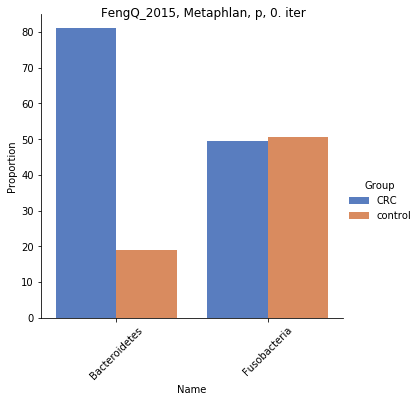

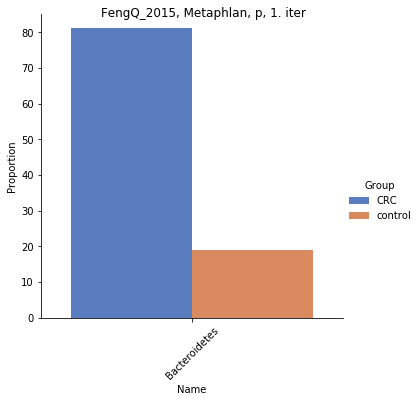

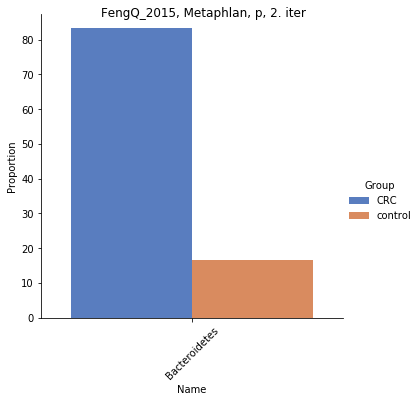

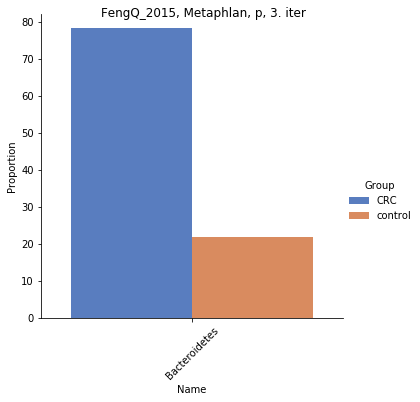

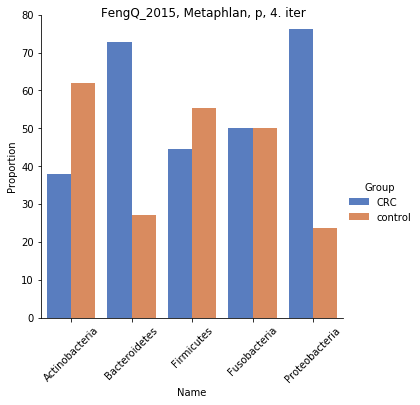

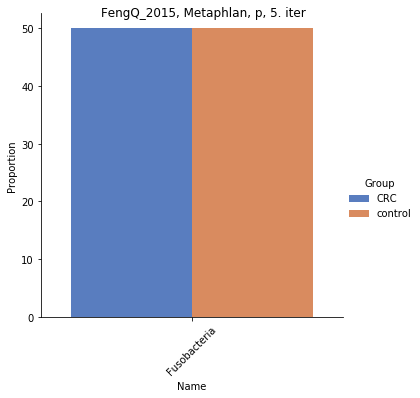

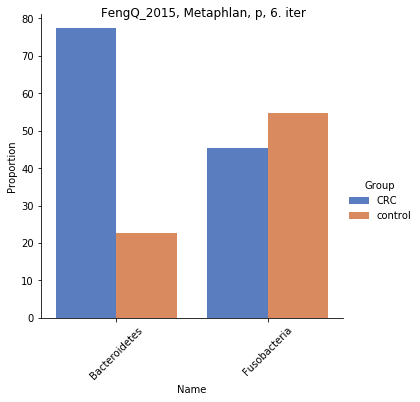

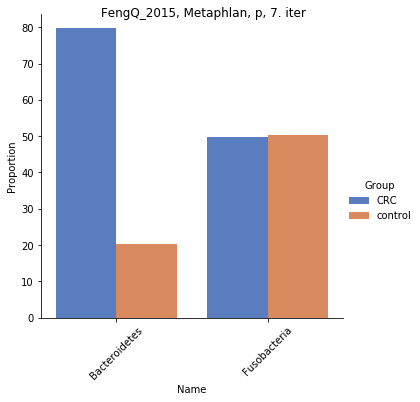

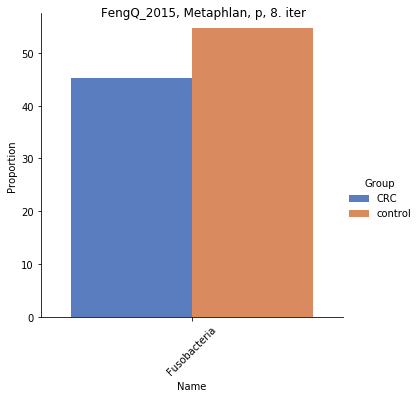

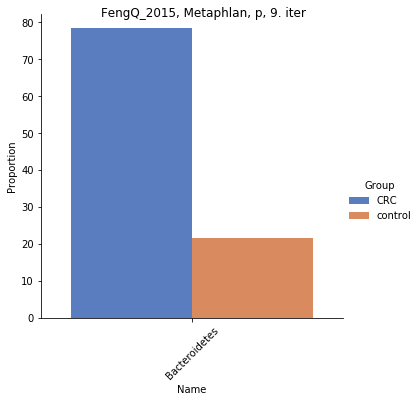

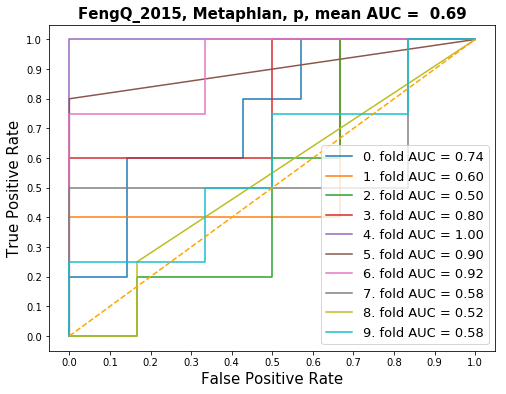

Shape of table: (107, 19)
Iter 0 AUC: 0.7142857142857143
Iter 1 AUC: 0.6000000000000001
Iter 2 AUC: 0.5
Iter 3 AUC: 0.8
Iter 4 AUC: 0.9666666666666667
Iter 5 AUC: 0.8666666666666667
Iter 6 AUC: 0.9166666666666667
Iter 7 AUC: 0.5833333333333333
Iter 8 AUC: 0.6666666666666667
Iter 9 AUC: 0.5833333333333333


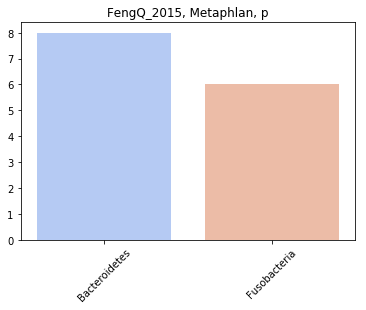

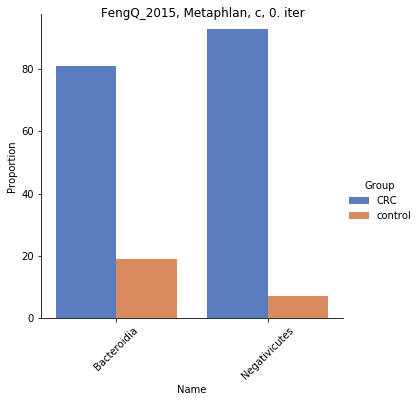

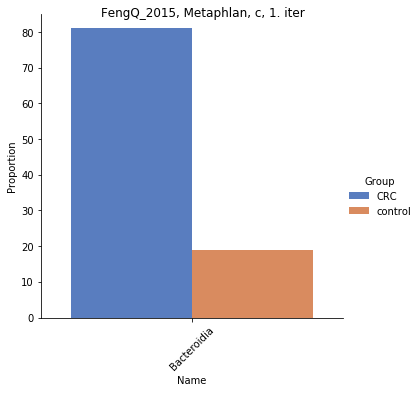

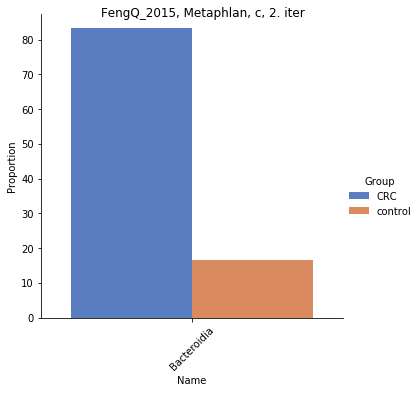

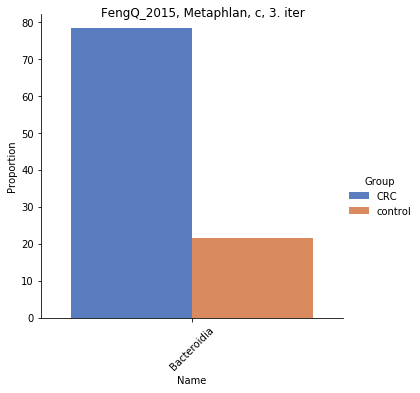

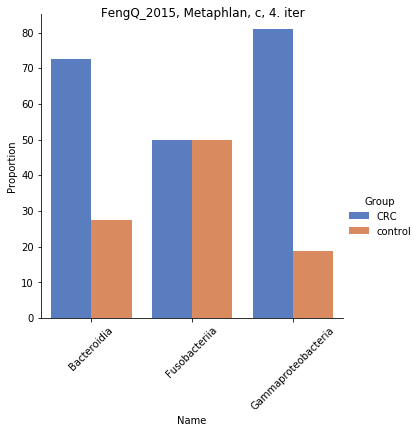

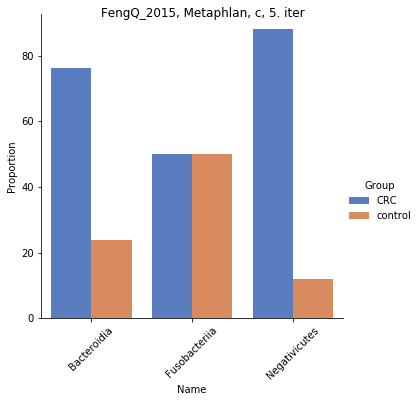

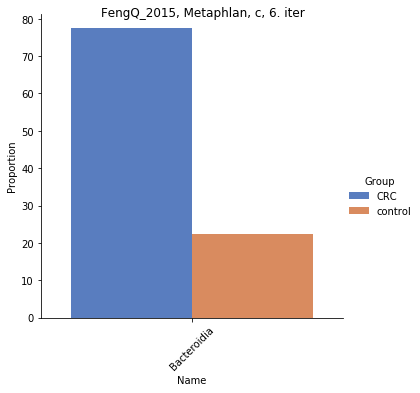

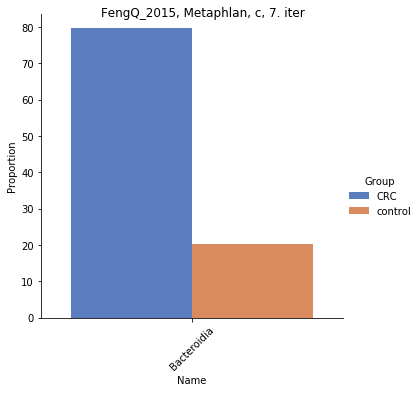

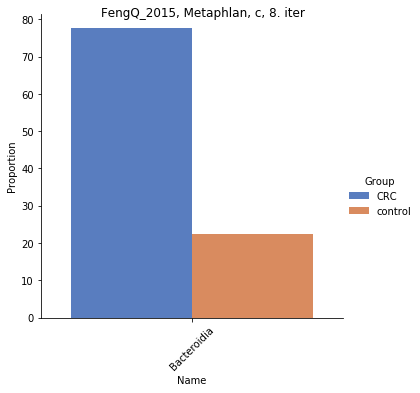

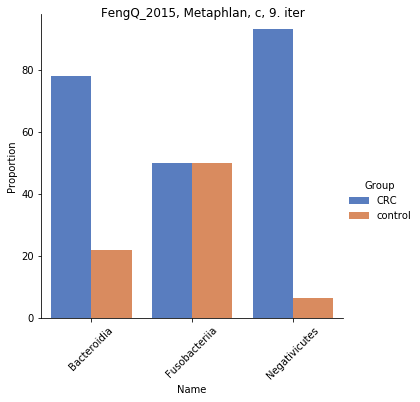

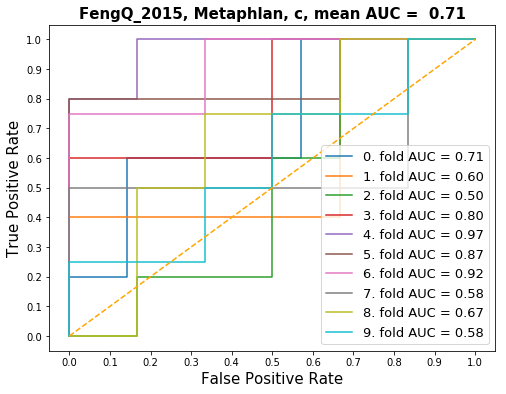

Shape of table: (107, 45)
Iter 0 AUC: 0.6285714285714286
Iter 1 AUC: 0.5
Iter 2 AUC: 0.4666666666666667
Iter 3 AUC: 0.7166666666666667
Iter 4 AUC: 0.7333333333333334
Iter 5 AUC: 0.9
Iter 6 AUC: 0.7083333333333333
Iter 7 AUC: 0.5416666666666667
Iter 8 AUC: 0.6666666666666667
Iter 9 AUC: 0.49999999999999994


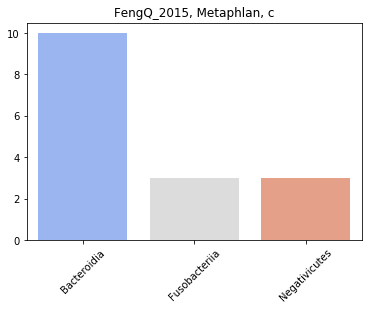

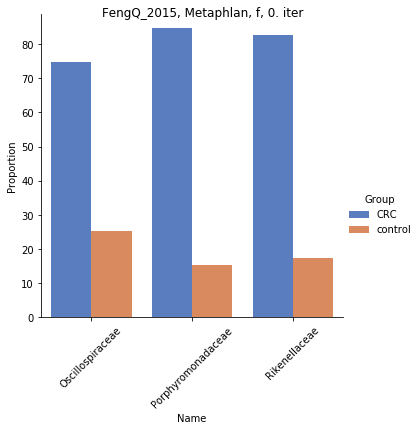

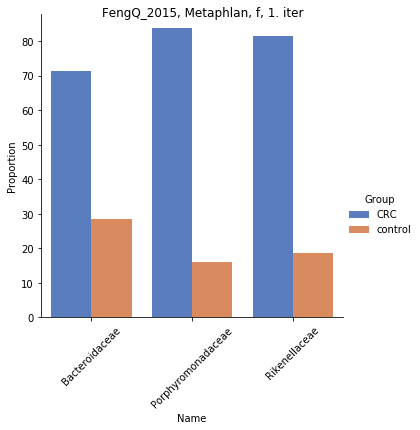

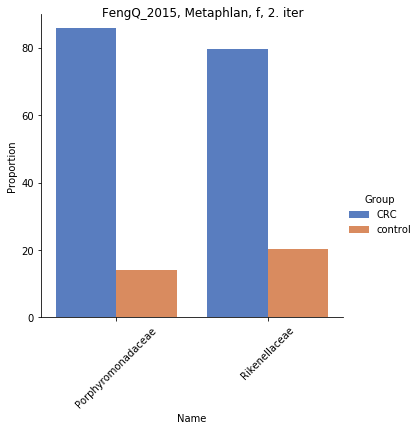

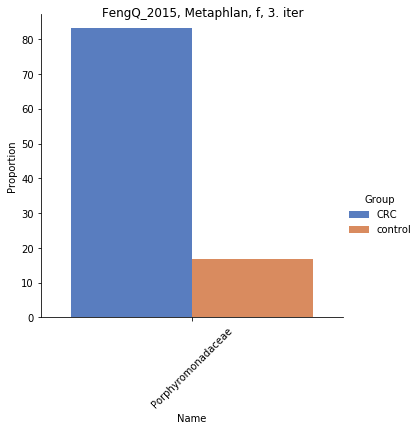

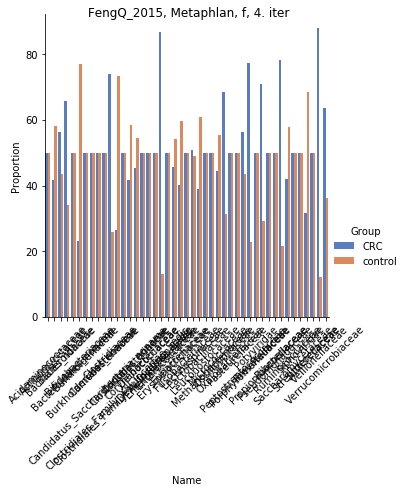

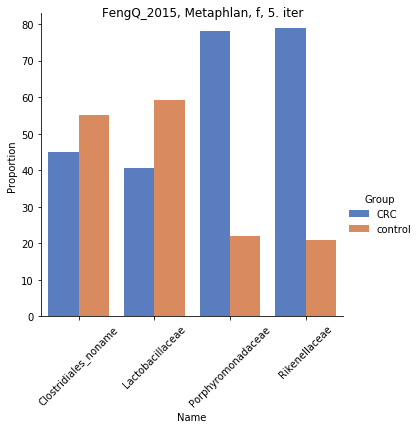

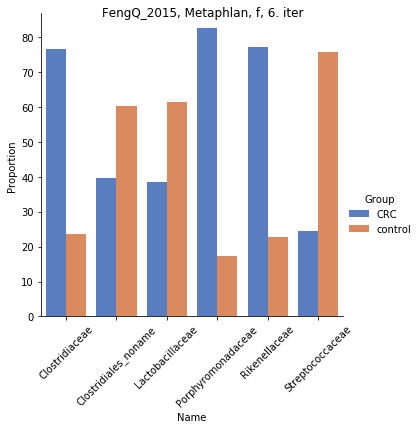

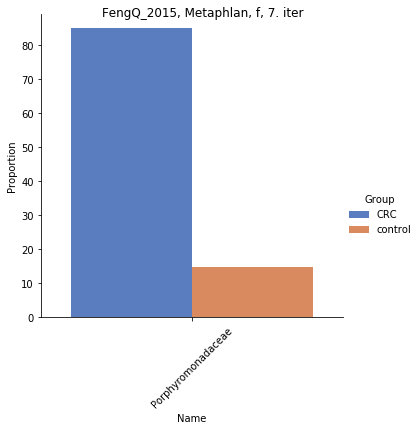

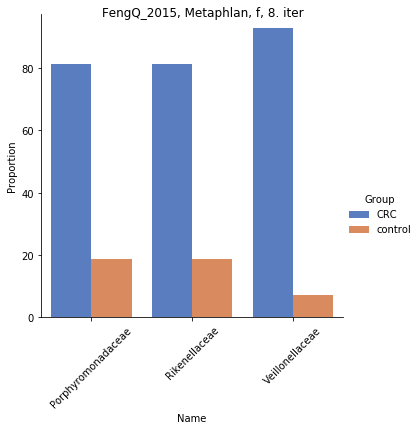

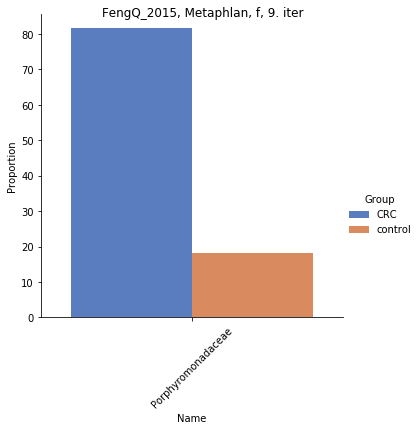

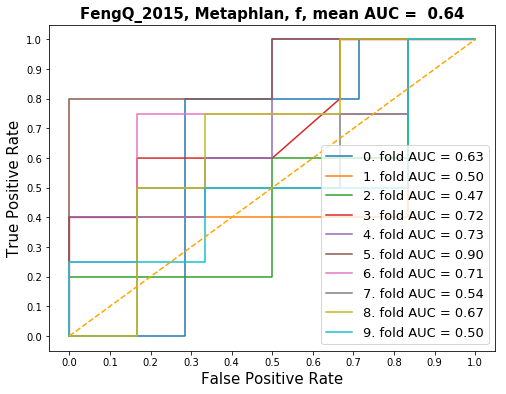

Shape of table: (107, 69)
Iter 0 AUC: 0.5428571428571429
Iter 1 AUC: 0.5
Iter 2 AUC: 0.5
Iter 3 AUC: 0.5666666666666667
Iter 4 AUC: 0.45
Iter 5 AUC: 0.7666666666666667
Iter 6 AUC: 0.7083333333333334
Iter 7 AUC: 0.625
Iter 8 AUC: 0.3333333333333333
Iter 9 AUC: 0.4166666666666667


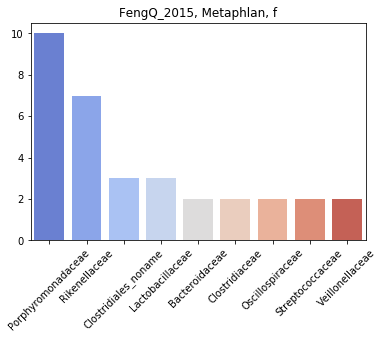

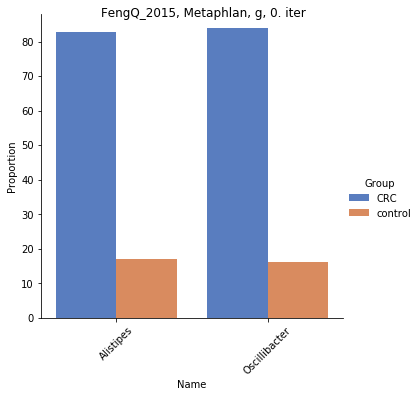

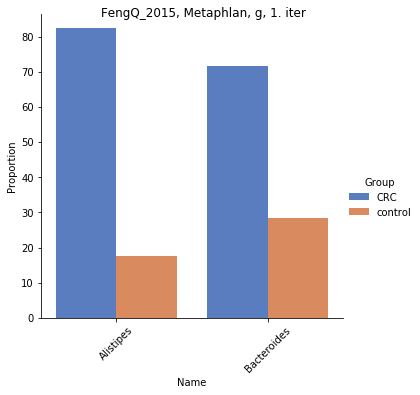

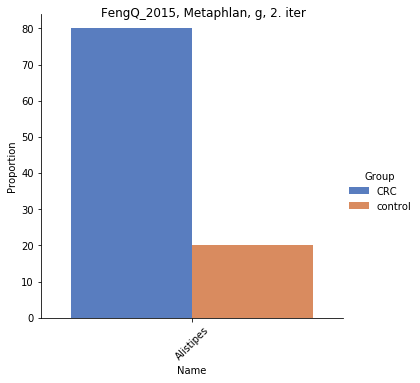

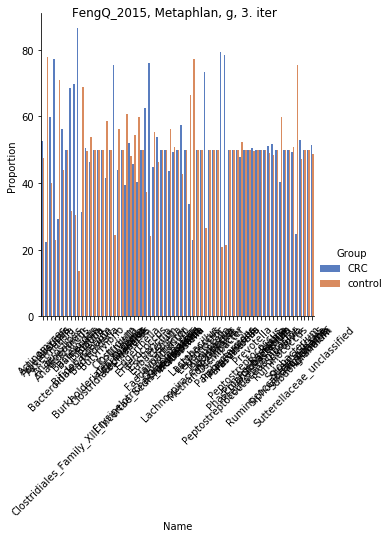

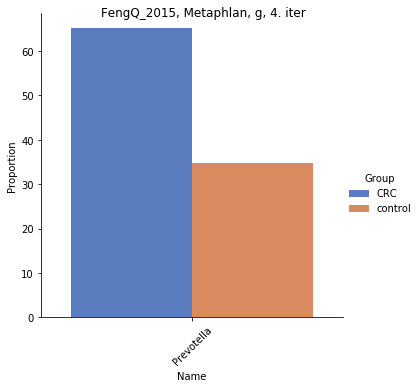

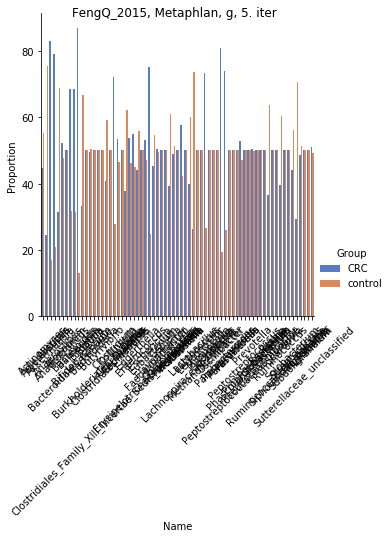

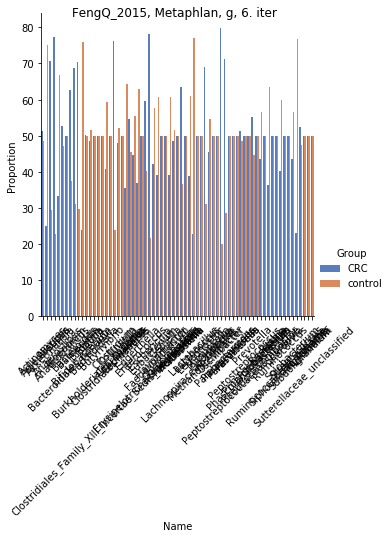

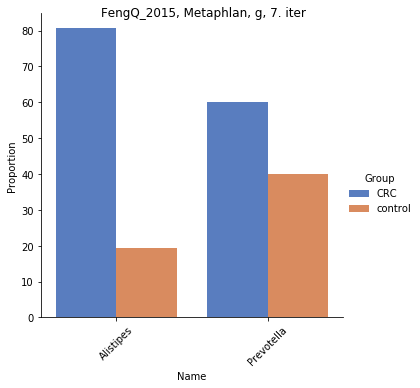

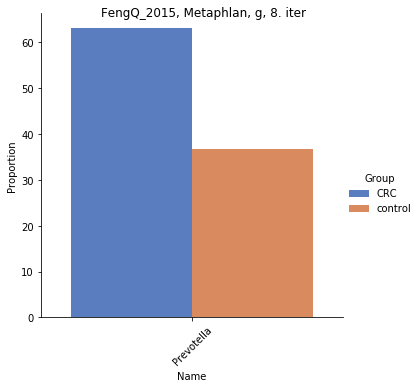

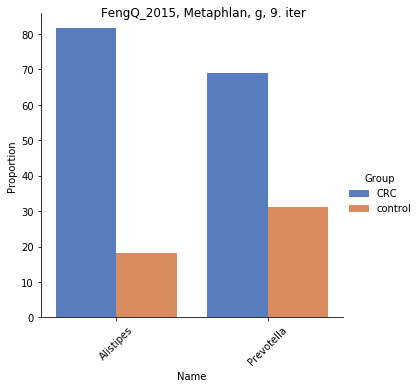

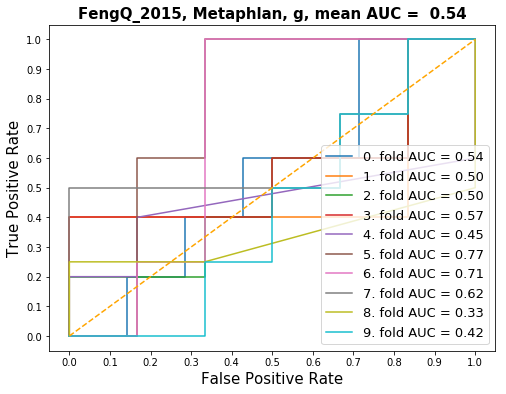

Shape of table: (107, 42)


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 0 AUC: 0.6285714285714286


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 1 AUC: 0.5


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 2 AUC: 0.13333333333333333


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 3 AUC: 0.8


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 4 AUC: 0.6666666666666666


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


No feature was selected.
Error in classification iter.
Iter 5 AUC: 0.7083333333333333


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 6 AUC: 0.5833333333333333


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 7 AUC: 0.625


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 8 AUC: 0.625


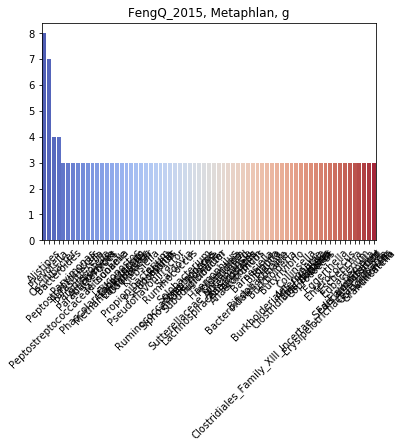

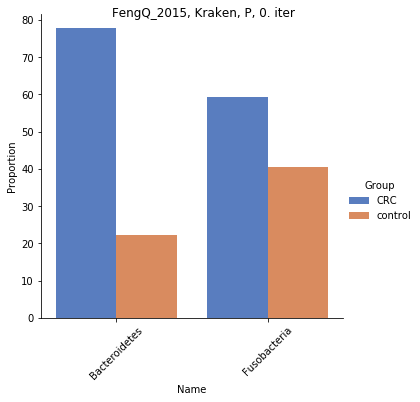

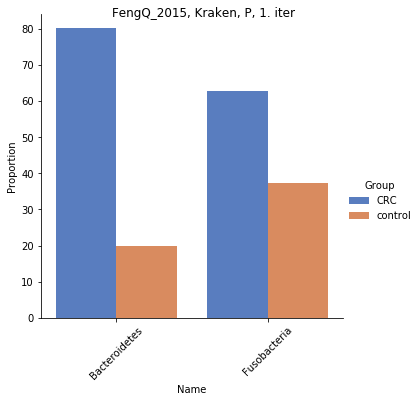

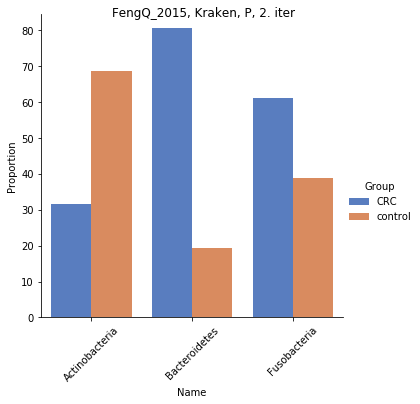

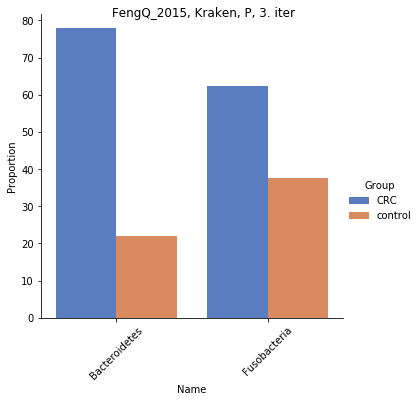

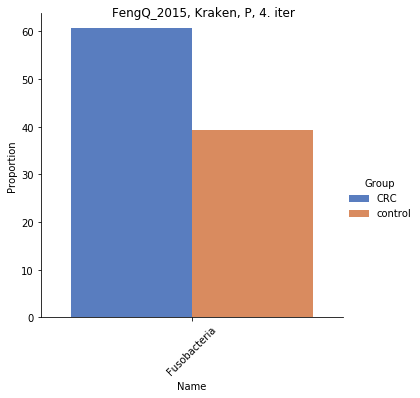

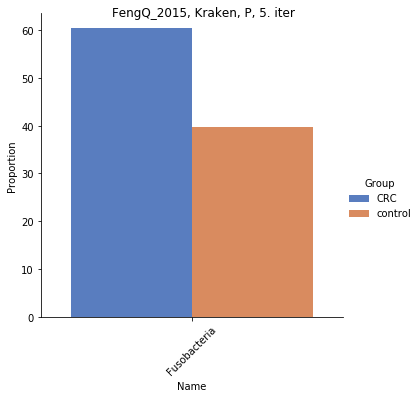

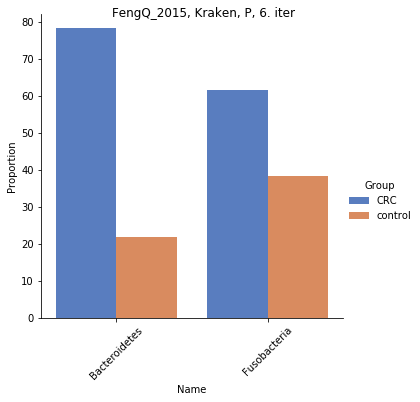

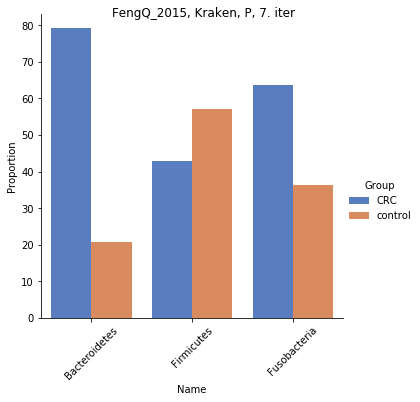

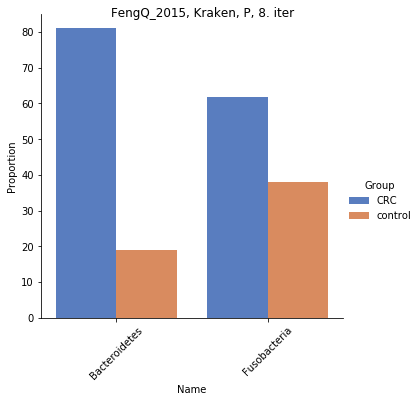

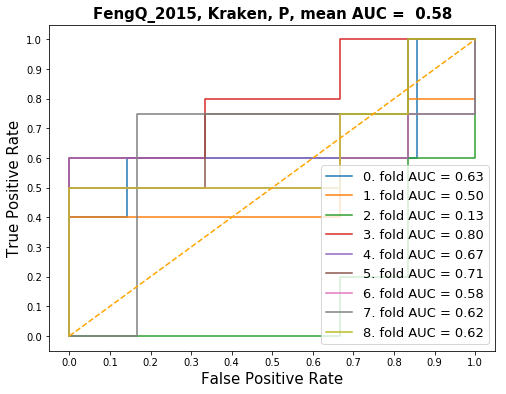

Shape of table: (107, 81)


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 0 AUC: 0.6285714285714286


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 1 AUC: 0.4666666666666667


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 2 AUC: 0.5


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 3 AUC: 0.6666666666666666


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


No feature was selected.
Error in classification iter.
No feature was selected.
Error in classification iter.
Iter 4 AUC: 0.7916666666666667


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 5 AUC: 0.625


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 6 AUC: 0.7083333333333334


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 7 AUC: 0.625


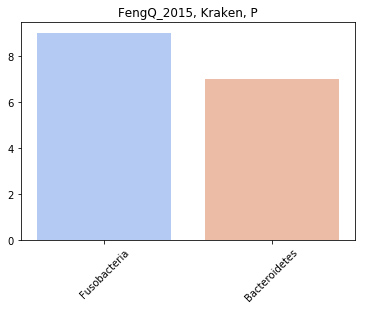

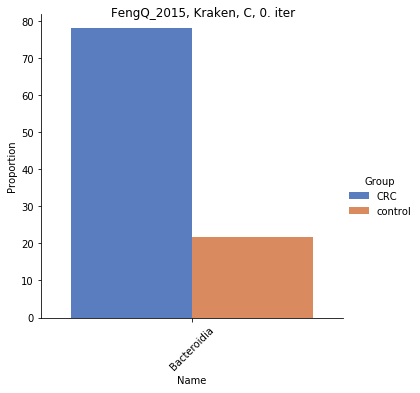

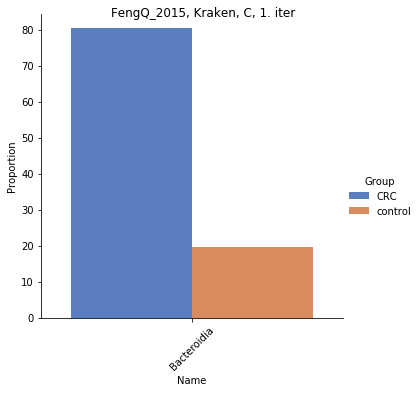

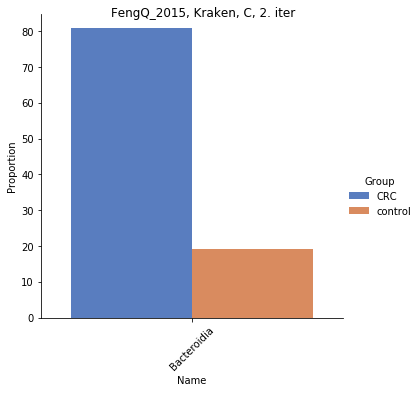

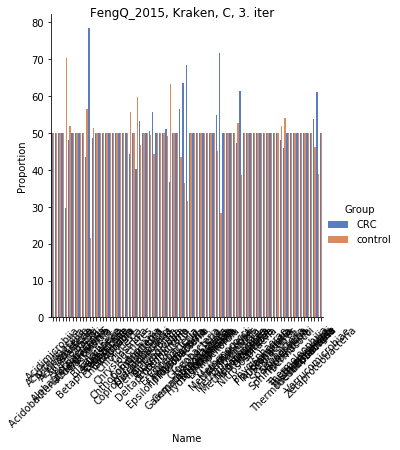

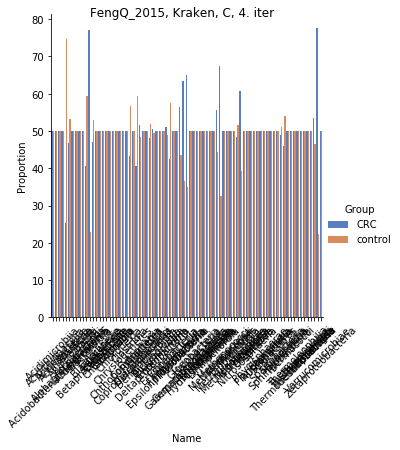

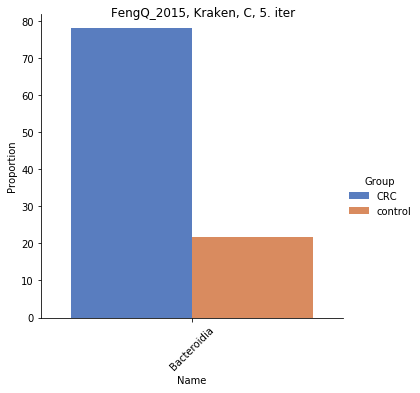

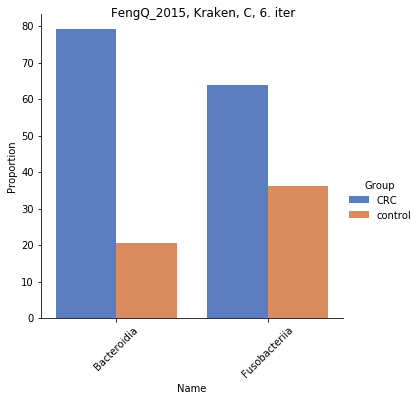

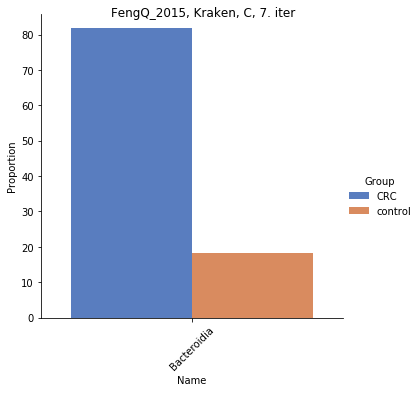

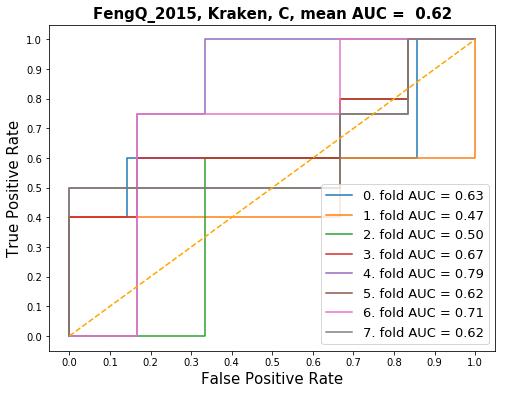

Shape of table: (107, 85)
Iter 0 AUC: 0.742857142857143
Iter 1 AUC: 0.33333333333333337
Iter 2 AUC: 0.5
Iter 3 AUC: 0.7000000000000001
Iter 4 AUC: 1.0
Iter 5 AUC: 0.9666666666666667
Iter 6 AUC: 0.9166666666666666
Iter 7 AUC: 0.5625
Iter 8 AUC: 0.5833333333333333
Iter 9 AUC: 0.33333333333333337


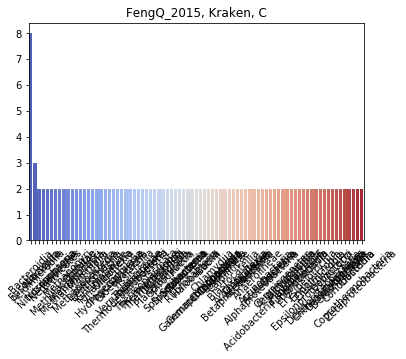

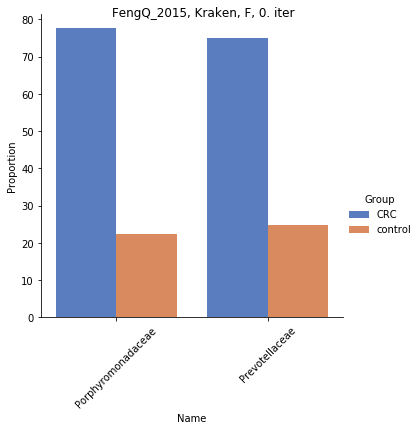

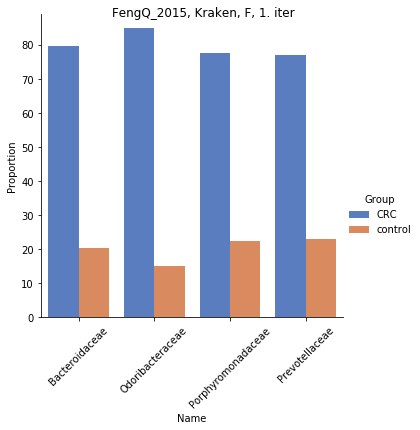

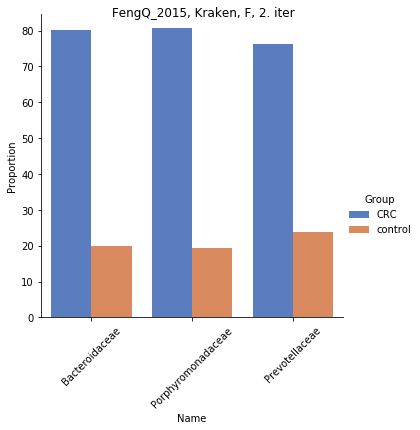

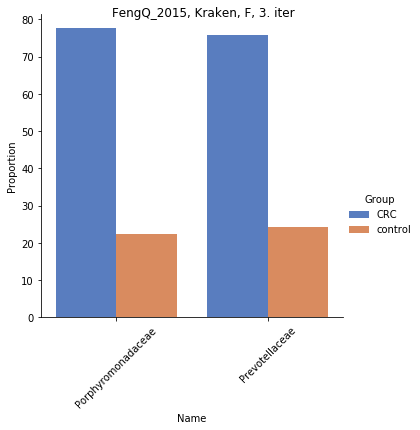

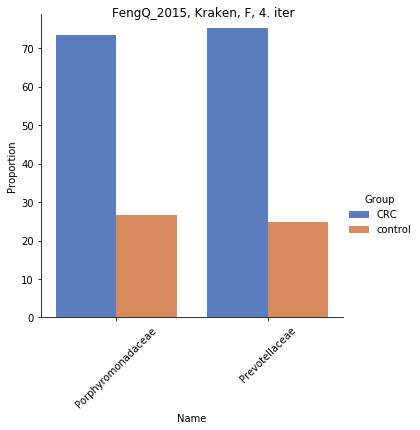

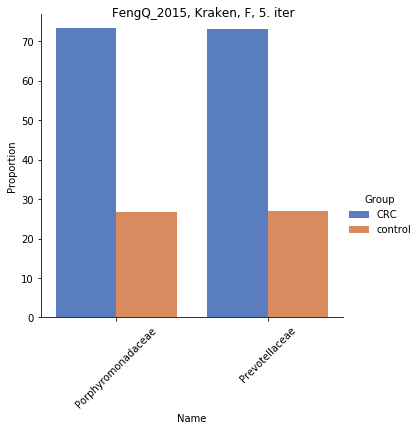

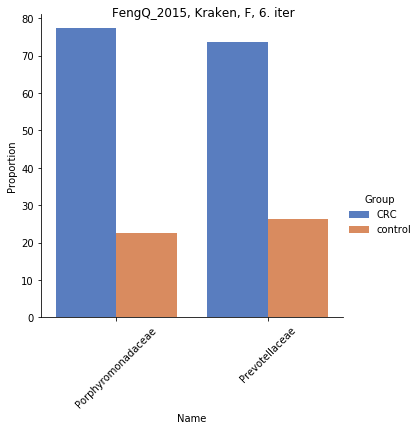

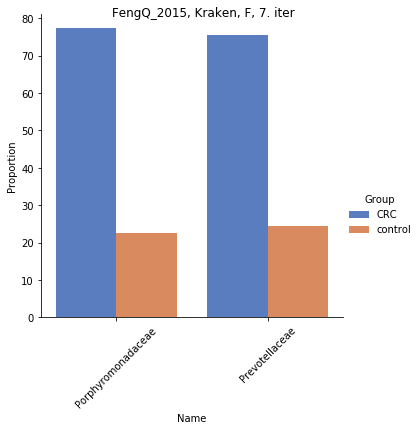

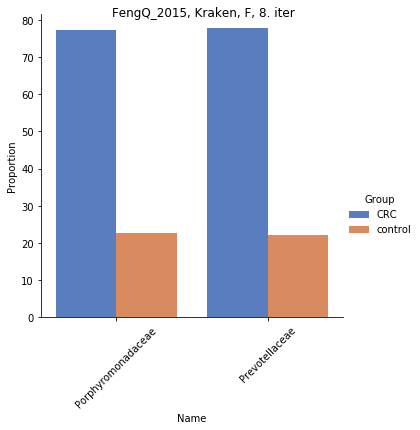

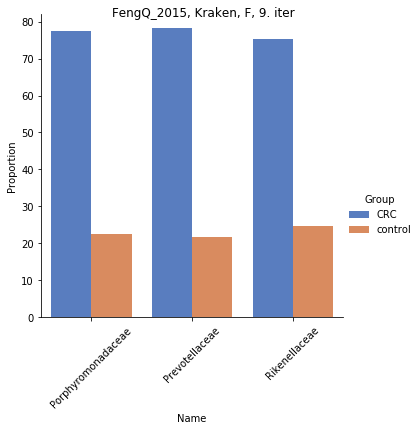

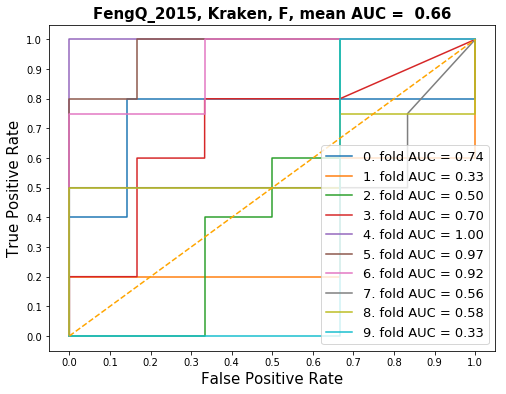

Shape of table: (107, 71)
Iter 0 AUC: 0.6
Iter 1 AUC: 0.33333333333333337
Iter 2 AUC: 0.5
Iter 3 AUC: 0.6333333333333333
Iter 4 AUC: 1.0
Iter 5 AUC: 0.8666666666666667
Iter 6 AUC: 0.9583333333333334
Iter 7 AUC: 0.5416666666666666
Iter 8 AUC: 0.625
Iter 9 AUC: 0.625


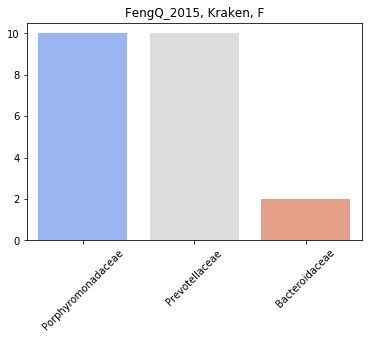

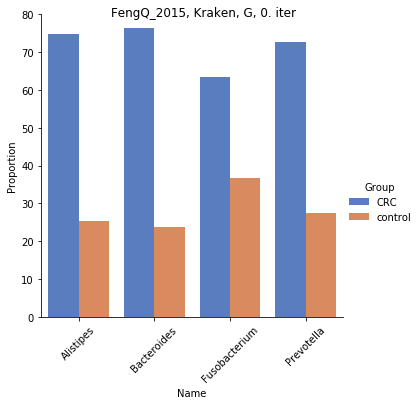

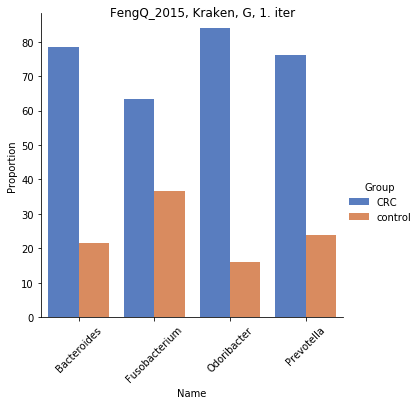

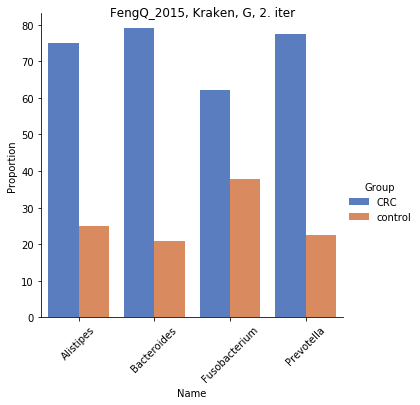

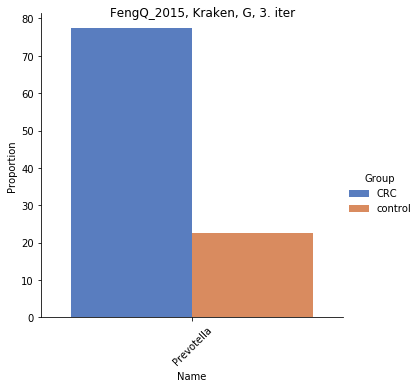

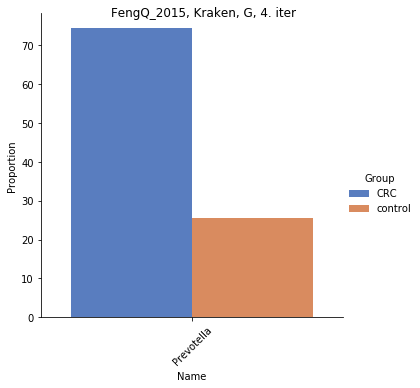

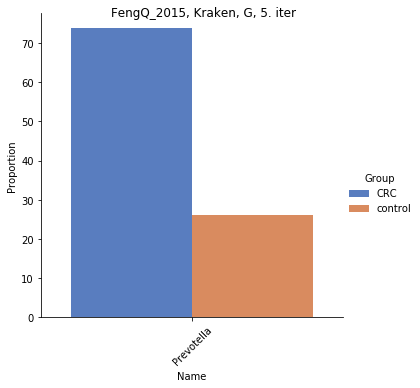

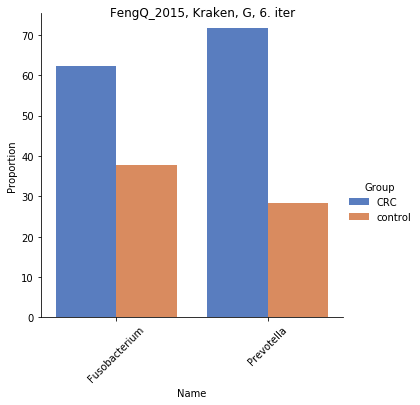

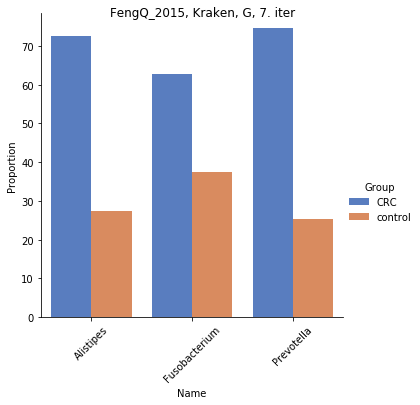

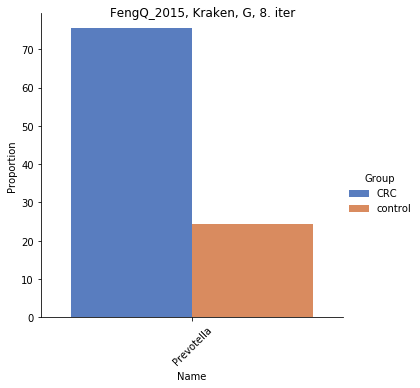

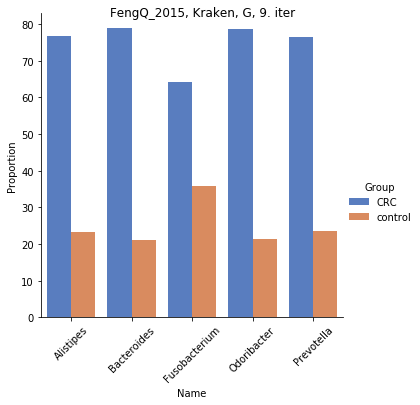

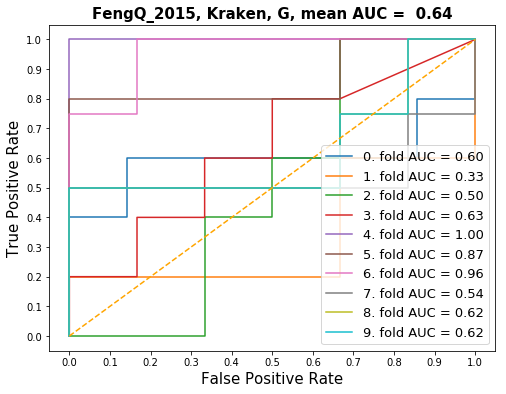

Shape of table: (417, 15)
Iter 0 AUC: 0.538548752834467
Iter 1 AUC: 0.5929705215419502
Iter 2 AUC: 0.5442176870748299
Iter 3 AUC: 0.4217687074829932
Iter 4 AUC: 0.6575963718820861
Iter 5 AUC: 0.6553287981859409
Iter 6 AUC: 0.5804988662131519
Iter 7 AUC: 0.34240362811791386
Iter 8 AUC: 0.47619047619047616
Iter 9 AUC: 0.5200000000000001


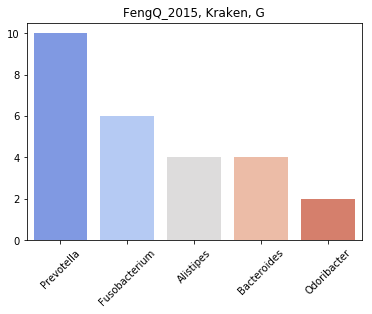

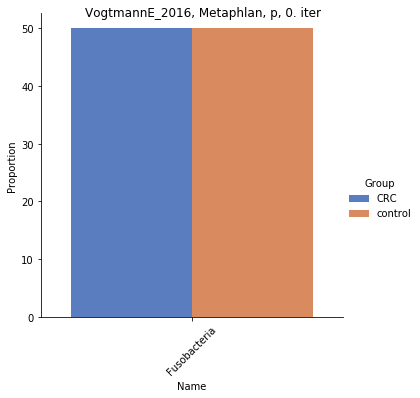

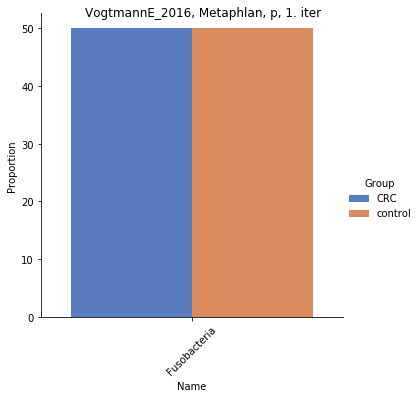

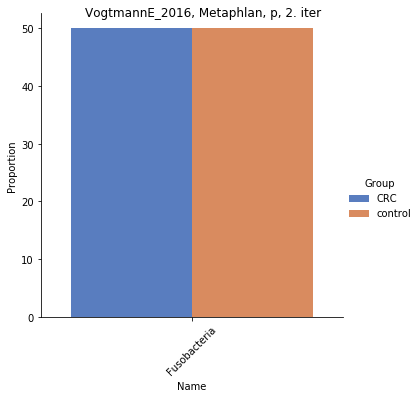

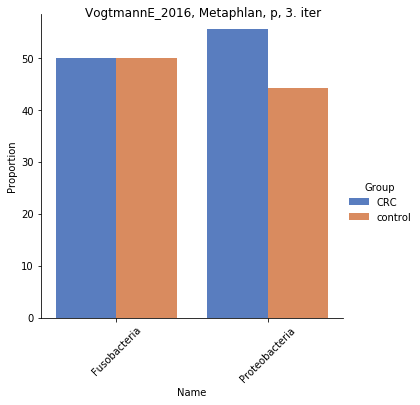

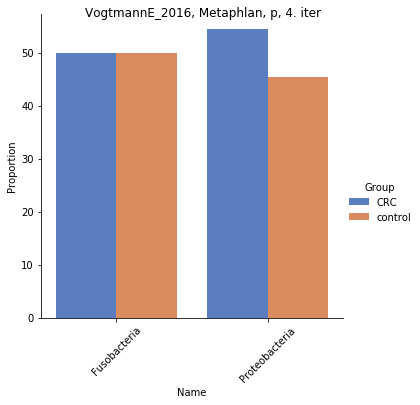

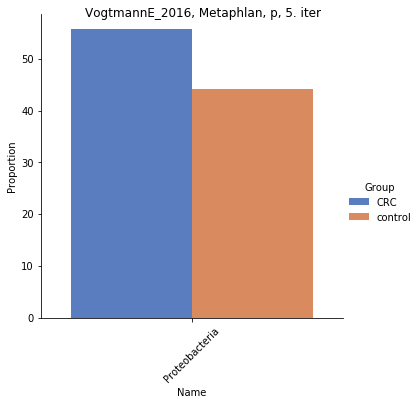

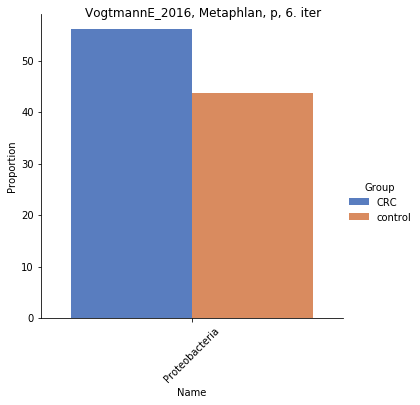

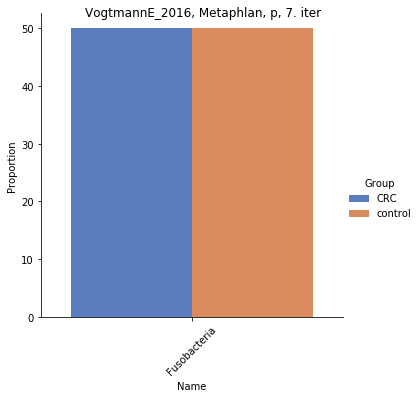

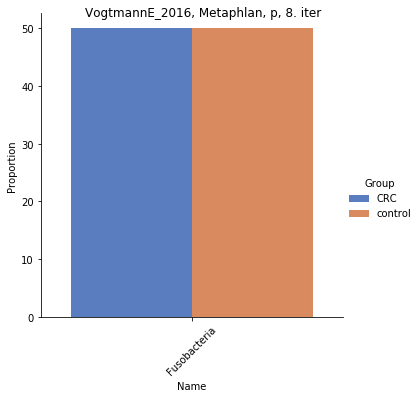

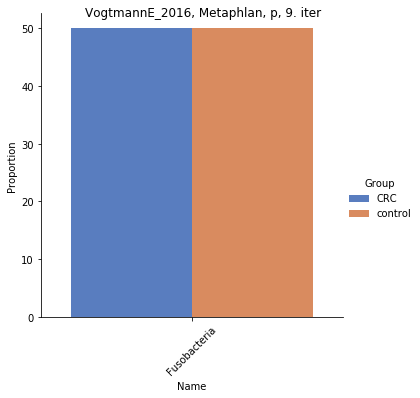

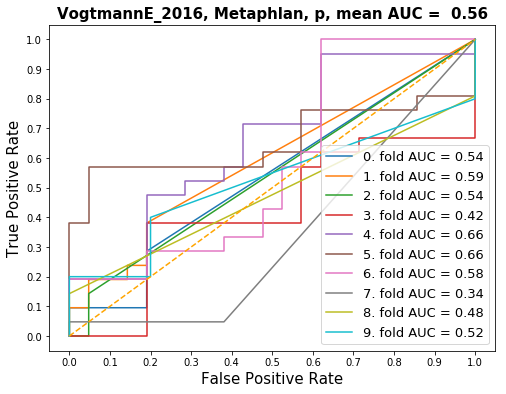

Shape of table: (417, 20)
Iter 0 AUC: 0.6122448979591836
Iter 1 AUC: 0.2947845804988662
Iter 2 AUC: 0.7868480725623582
Iter 3 AUC: 0.4988662131519275
Iter 4 AUC: 0.35147392290249435
Iter 5 AUC: 0.4920634920634921
Iter 6 AUC: 0.562358276643991
Iter 7 AUC: 0.5419501133786849
Iter 8 AUC: 0.46190476190476193
Iter 9 AUC: 0.8125


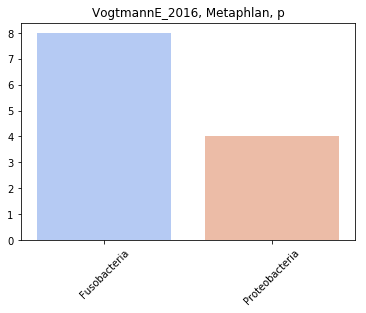

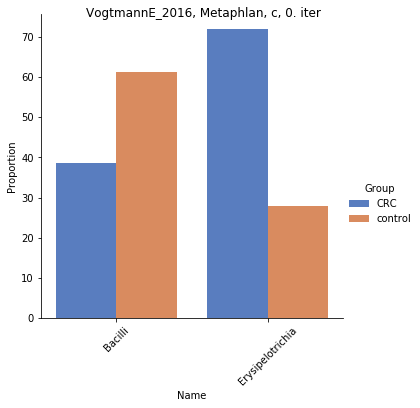

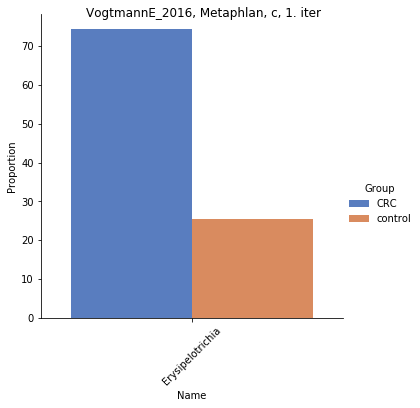

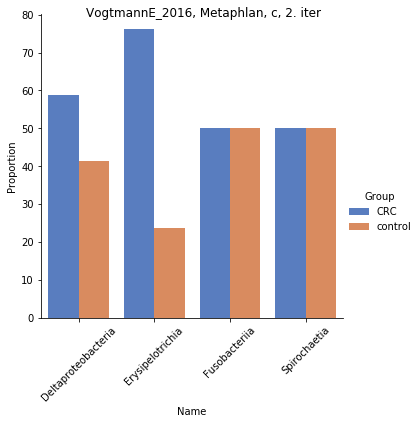

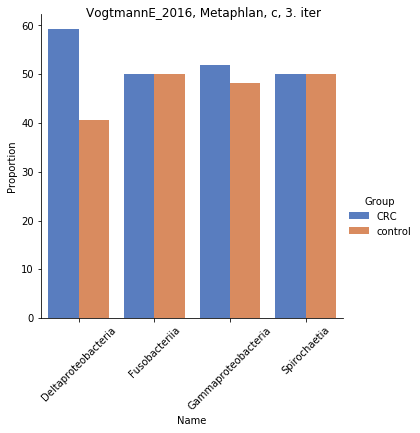

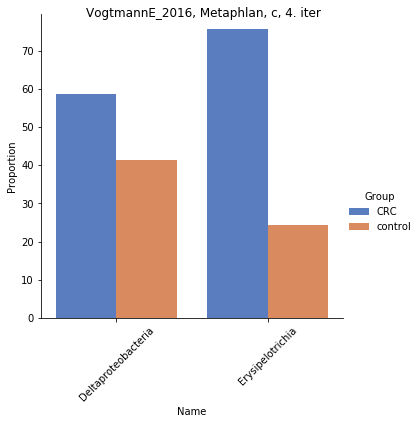

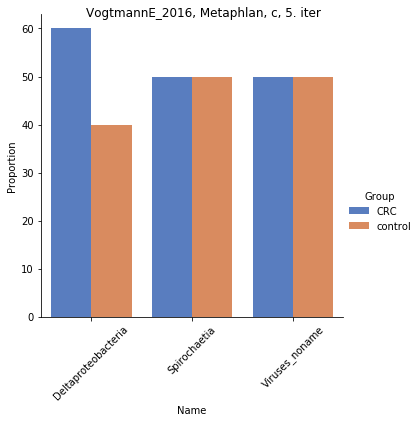

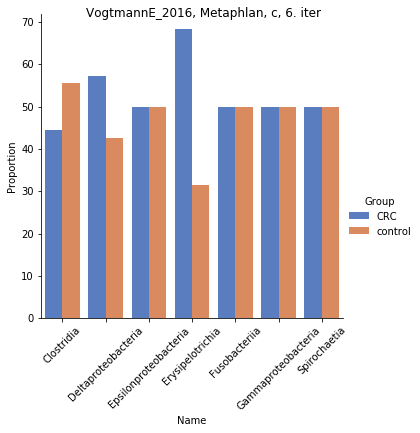

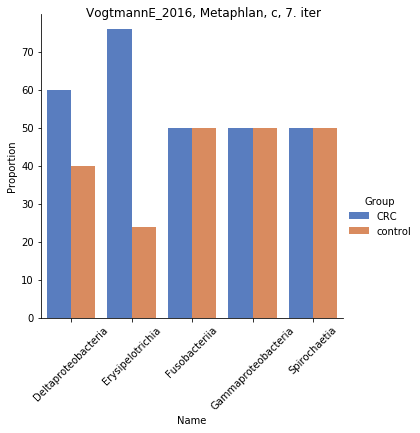

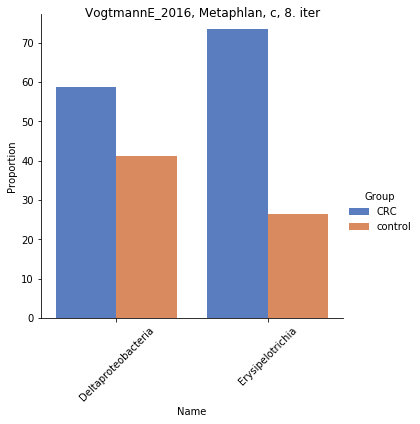

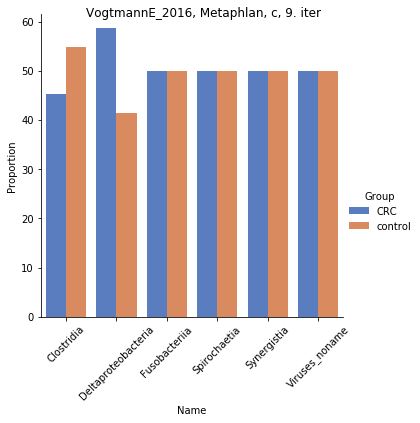

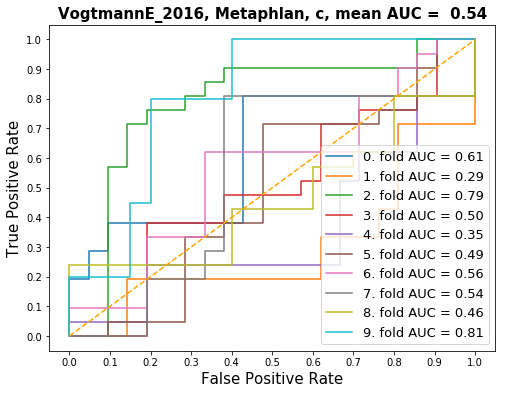

Shape of table: (417, 44)
Iter 0 AUC: 0.4852607709750567
Iter 1 AUC: 0.2766439909297052
Iter 2 AUC: 0.5056689342403629
Iter 3 AUC: 0.5328798185941043
Iter 4 AUC: 0.1111111111111111
Iter 5 AUC: 0.34467120181405897
Iter 6 AUC: 0.6281179138321995
Iter 7 AUC: 0.4399092970521542
Iter 8 AUC: 0.4023809523809524
Iter 9 AUC: 0.40375


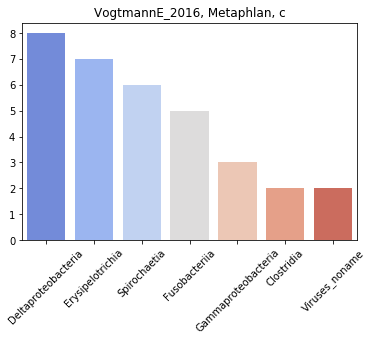

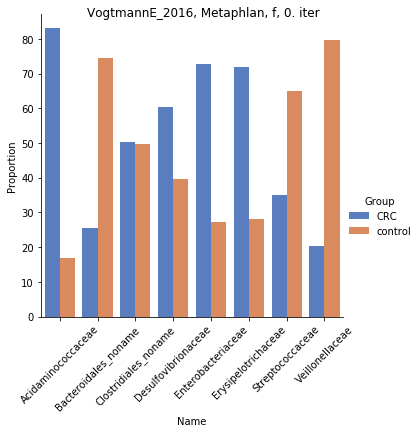

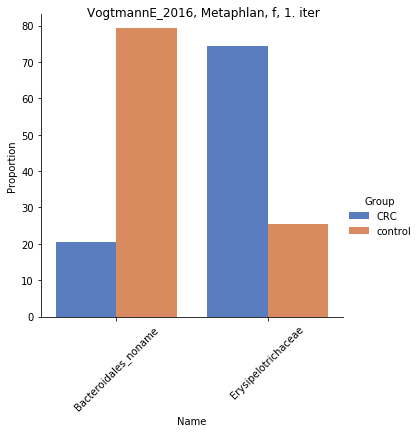

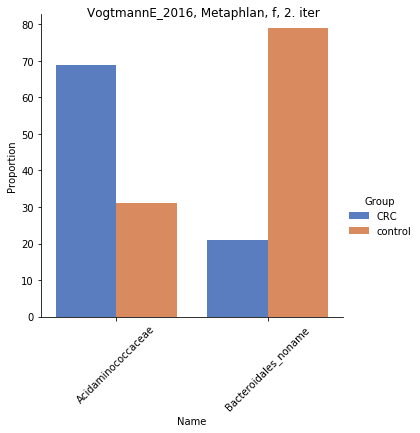

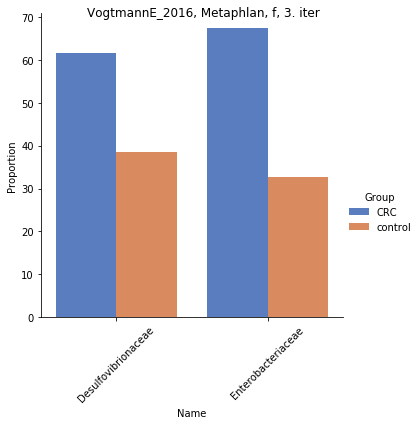

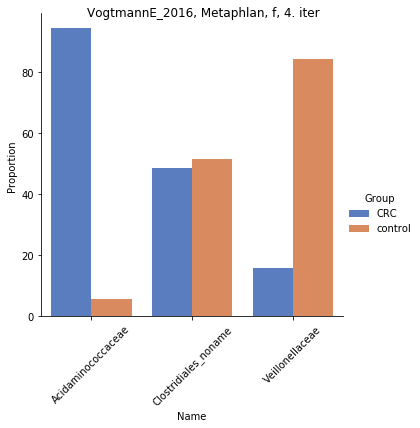

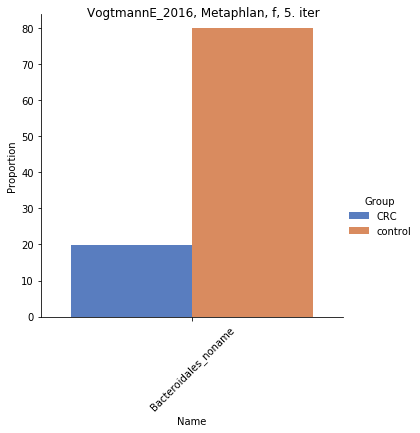

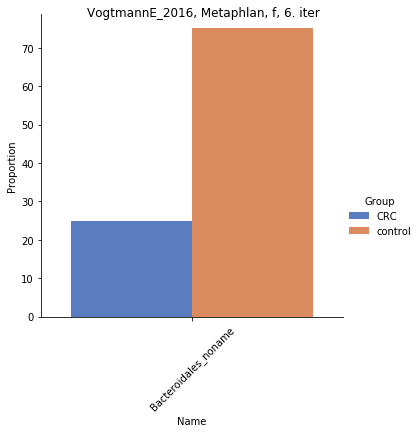

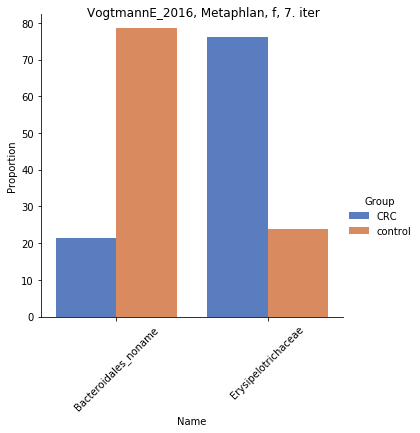

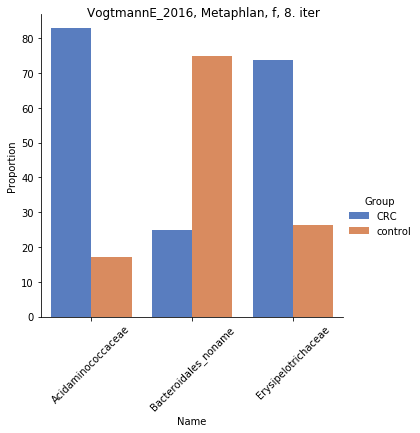

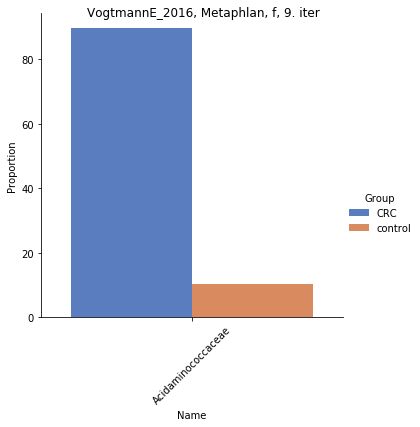

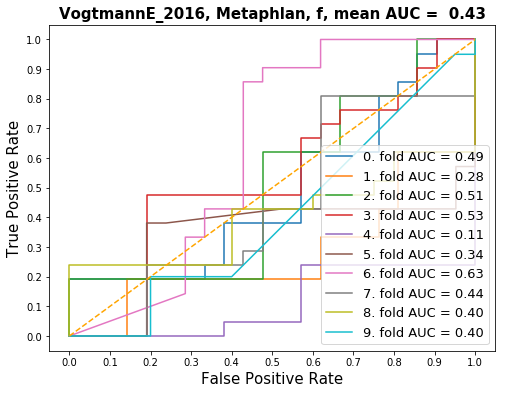

Shape of table: (417, 84)
Iter 0 AUC: 0.46938775510204084
Iter 1 AUC: 0.3129251700680272
Iter 2 AUC: 0.5170068027210885
Iter 3 AUC: 0.6009070294784581
Iter 4 AUC: 0.5034013605442177
Iter 5 AUC: 0.4852607709750567
Iter 6 AUC: 0.5
Iter 7 AUC: 0.30839002267573695
Iter 8 AUC: 0.34285714285714286
Iter 9 AUC: 0.8400000000000001


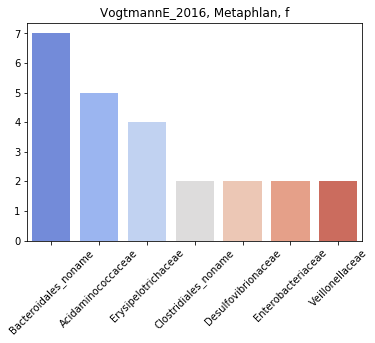

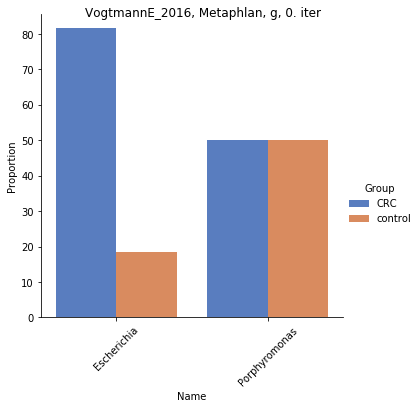

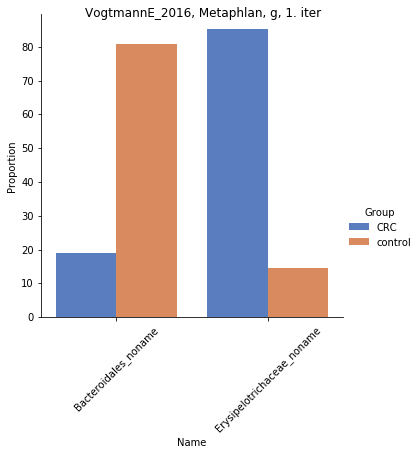

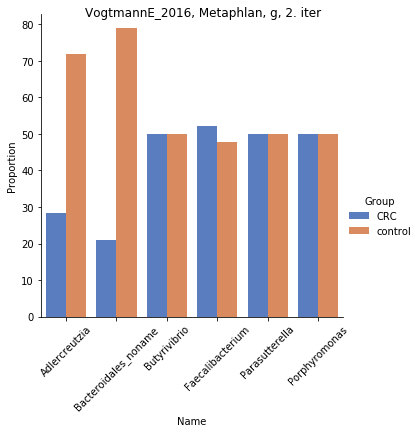

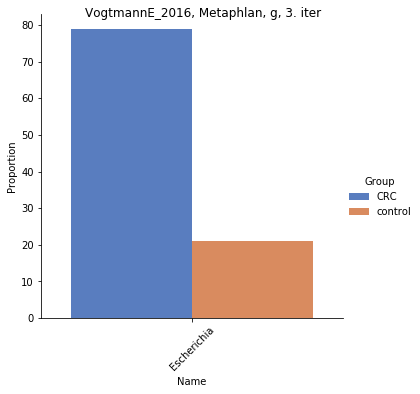

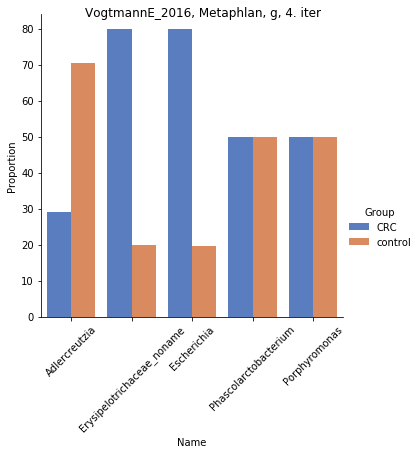

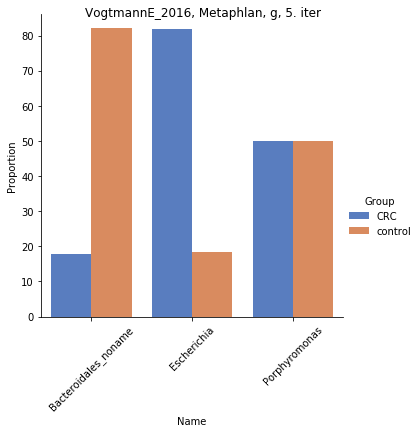

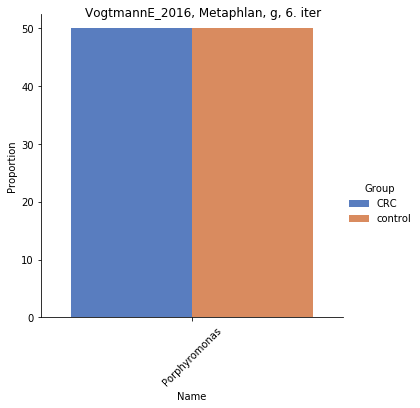

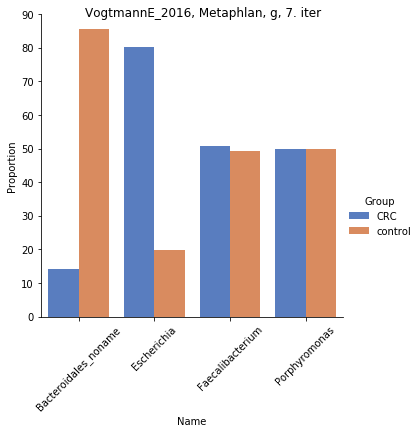

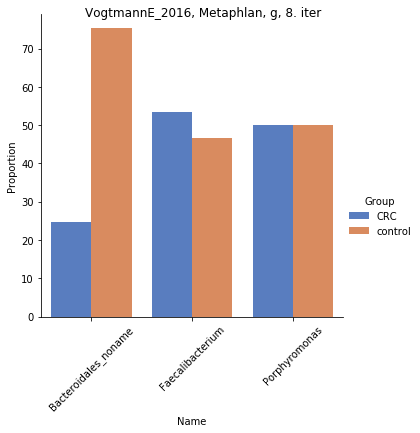

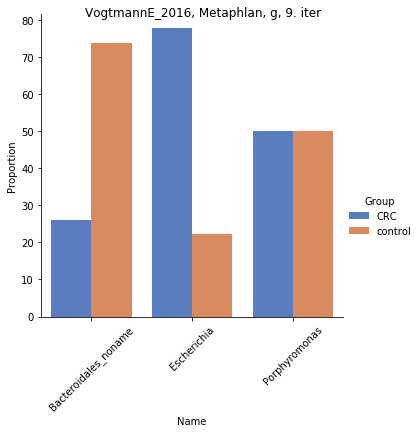

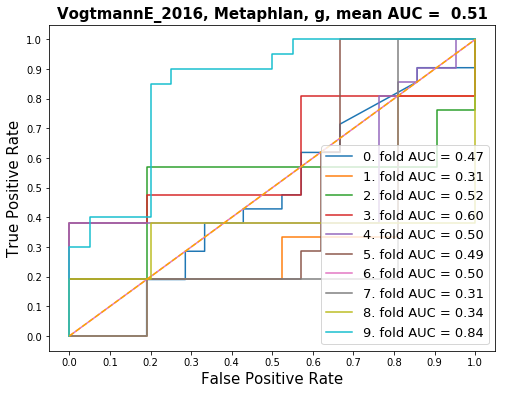

Shape of table: (417, 42)


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 0 AUC: 0.35147392290249424


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 1 AUC: 0.5260770975056689


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 2 AUC: 0.4693877551020408


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 3 AUC: 0.4580498866213152


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 4 AUC: 0.4331065759637188


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 5 AUC: 0.19274376417233557


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 6 AUC: 0.6961451247165533


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 7 AUC: 0.3741496598639456


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 8 AUC: 0.40119047619047615


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 9 AUC: 0.42000000000000004


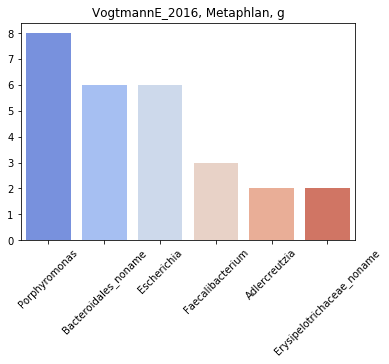

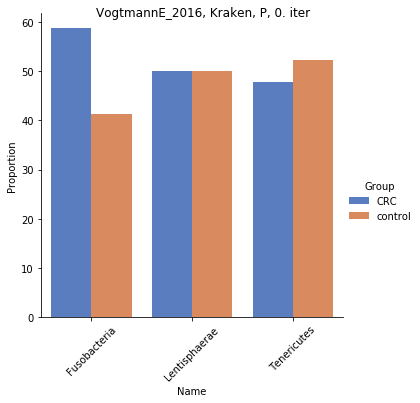

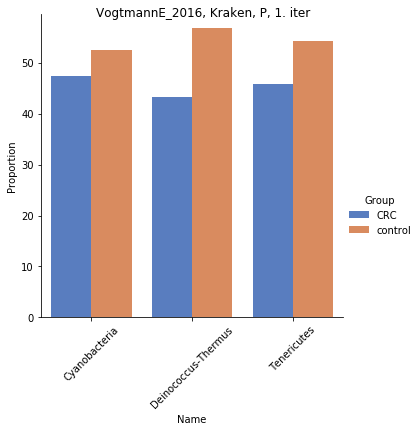

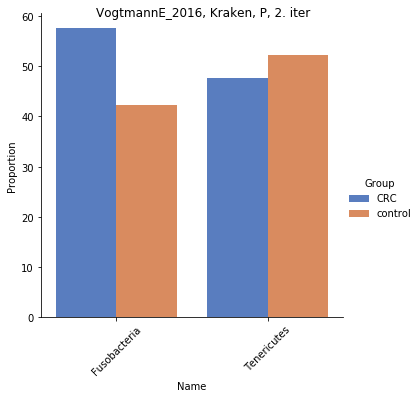

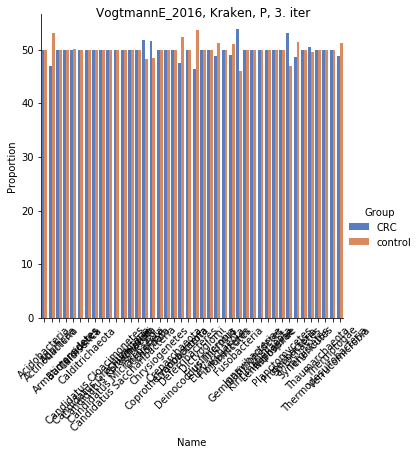

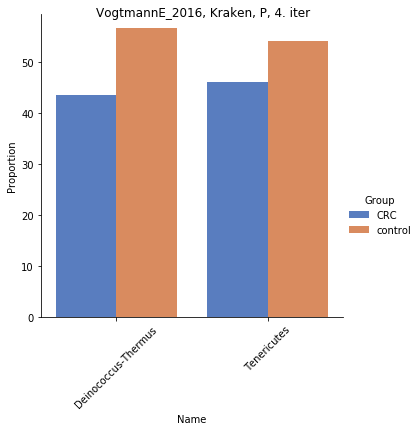

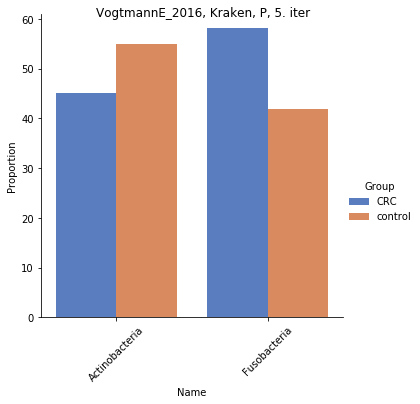

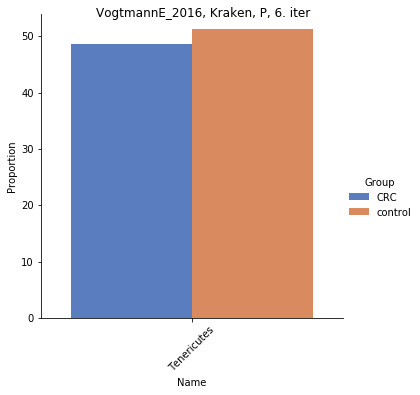

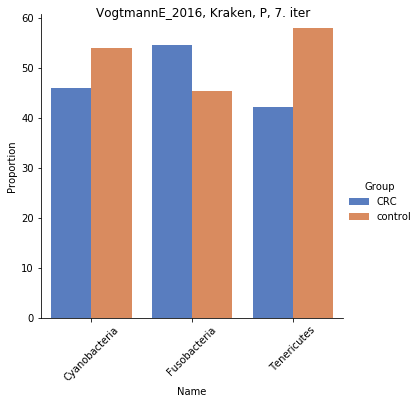

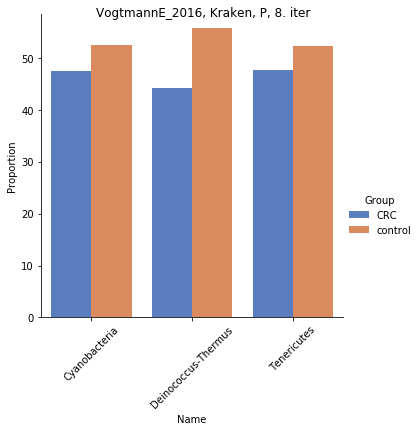

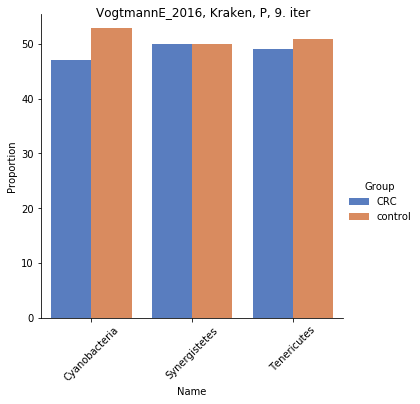

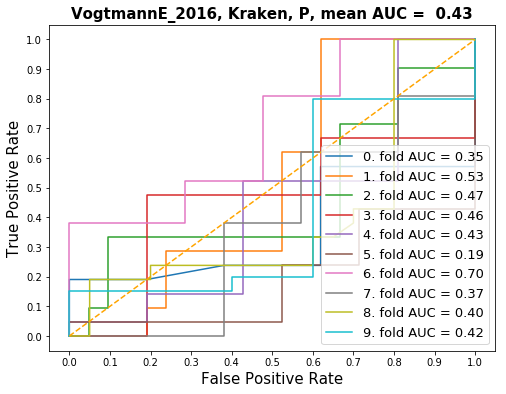

Shape of table: (417, 81)


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 0 AUC: 0.6598639455782314


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 1 AUC: 0.7562358276643991


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 2 AUC: 0.5306122448979591


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 3 AUC: 0.7664399092970522


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 4 AUC: 0.7981859410430839


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 5 AUC: 0.5079365079365079


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 6 AUC: 0.7913832199546486


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 7 AUC: 0.21541950113378683


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 8 AUC: 0.5428571428571429


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 9 AUC: 0.27999999999999997


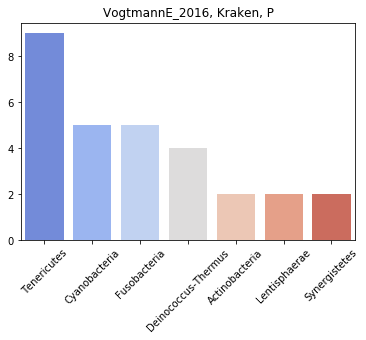

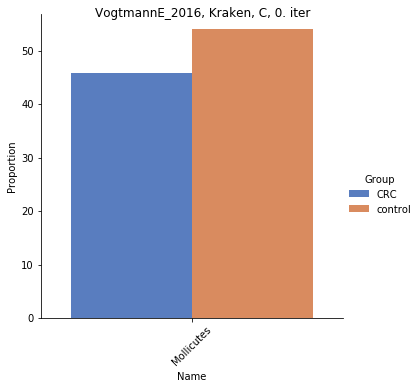

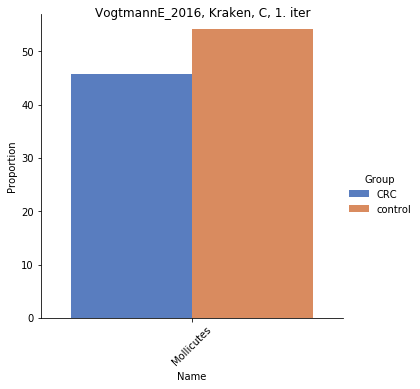

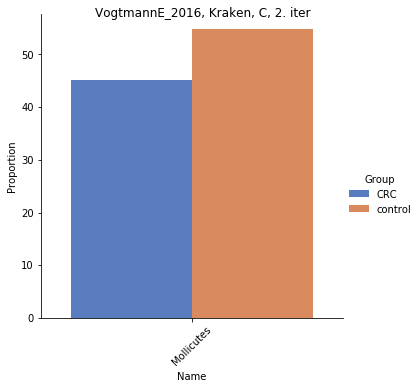

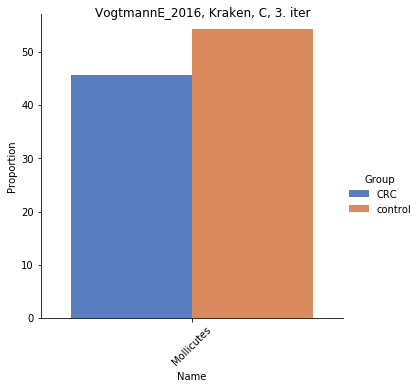

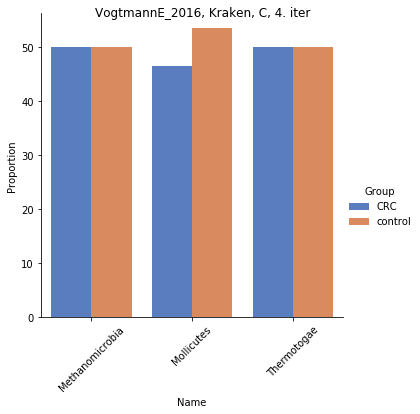

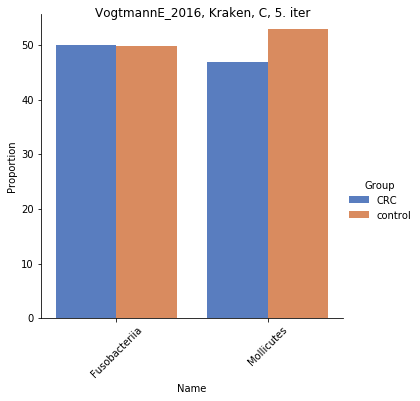

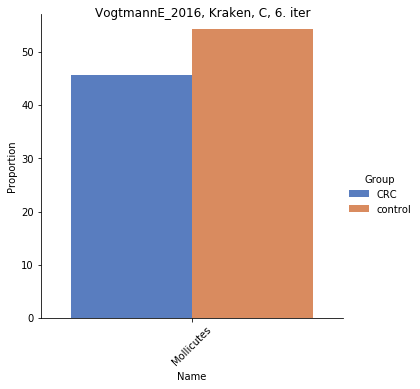

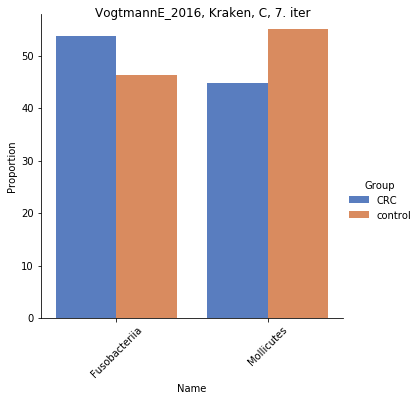

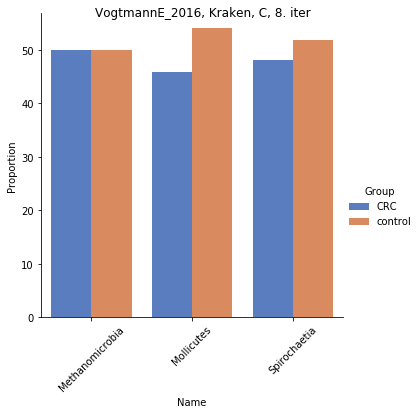

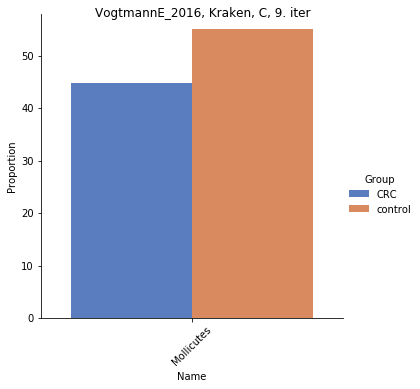

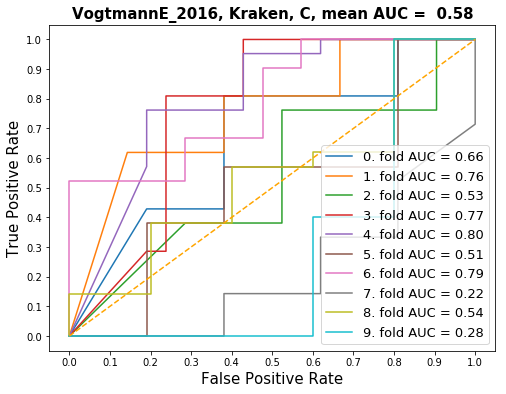

Shape of table: (417, 388)


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 0 AUC: 0.5147392290249433


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 1 AUC: 0.6439909297052154


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 2 AUC: 0.5396825396825398


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 3 AUC: 0.7165532879818594


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 4 AUC: 0.41043083900226757


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 5 AUC: 0.2675736961451247


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 6 AUC: 0.3333333333333333


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 7 AUC: 0.3015873015873016


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 8 AUC: 0.5476190476190477


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 9 AUC: 0.43


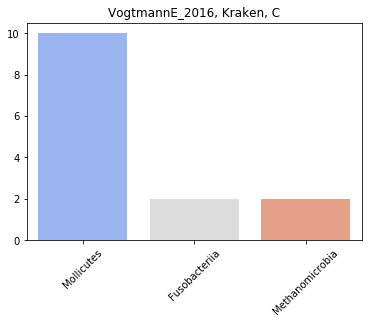

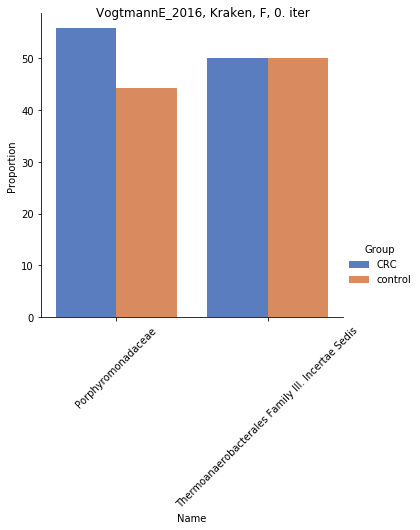

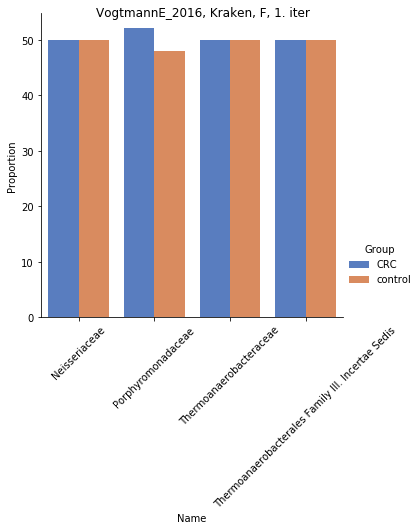

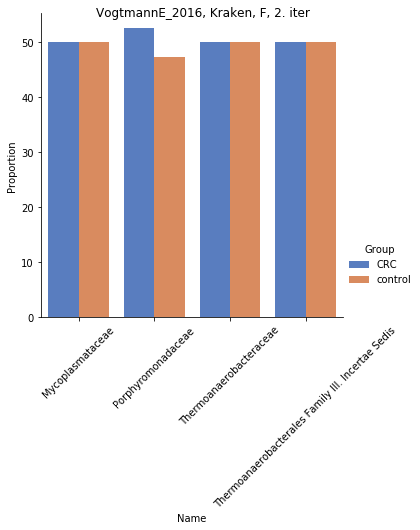

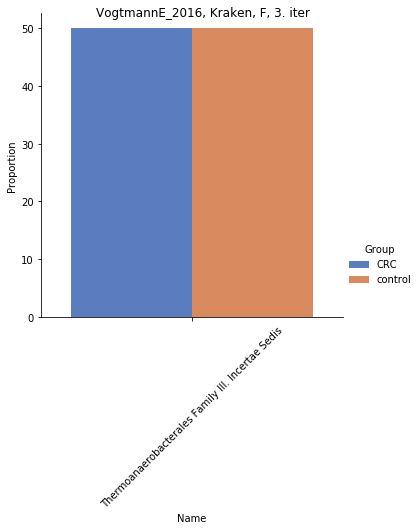

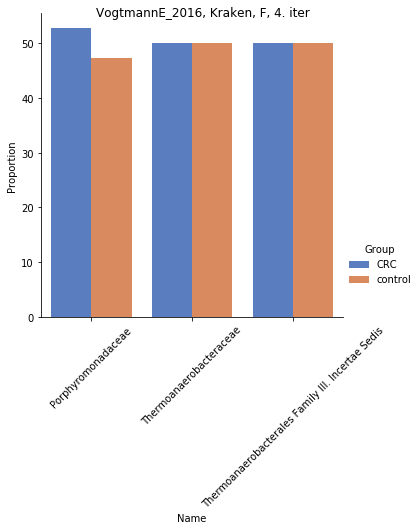

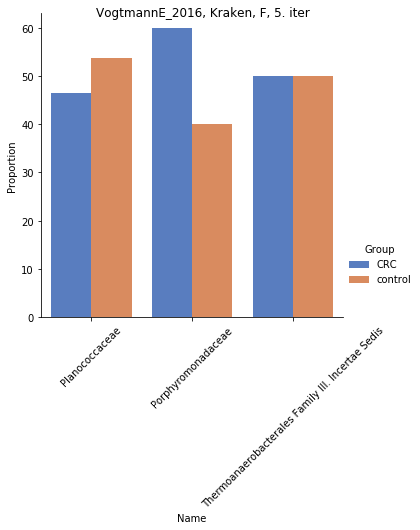

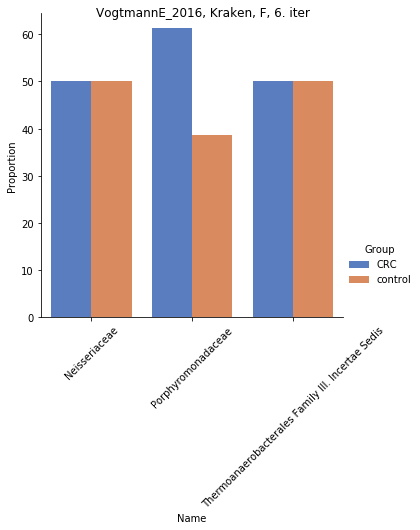

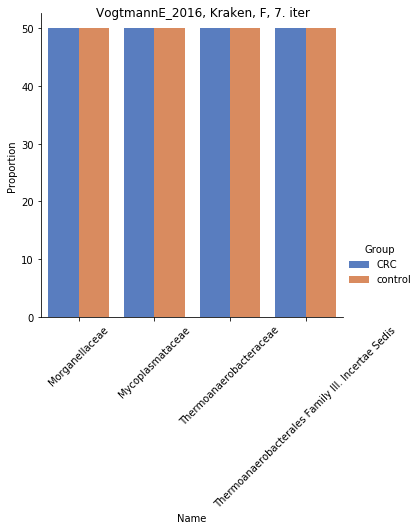

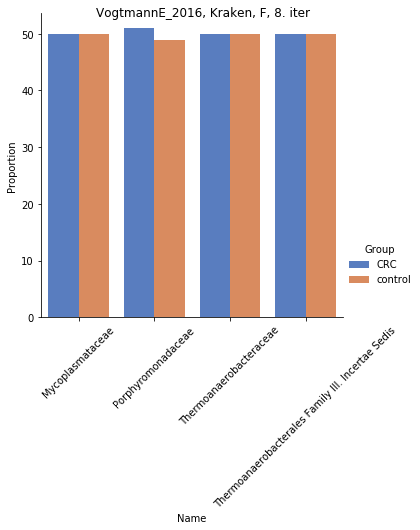

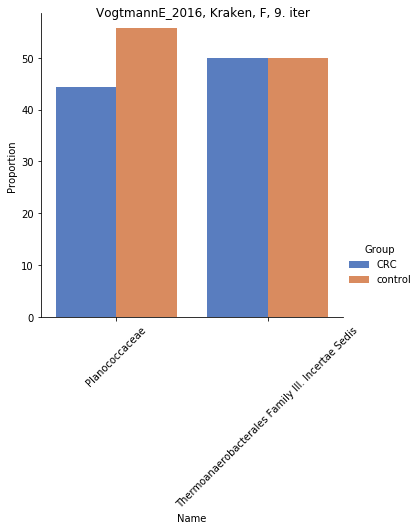

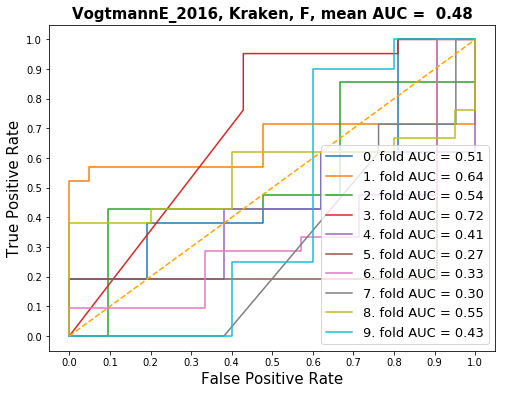

Shape of table: (417, 1184)


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 0 AUC: 0.63718820861678


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 1 AUC: 0.5396825396825397


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 2 AUC: 0.6145124716553287


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


KeyboardInterrupt: 

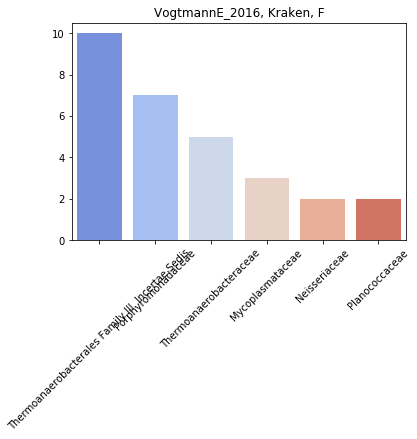

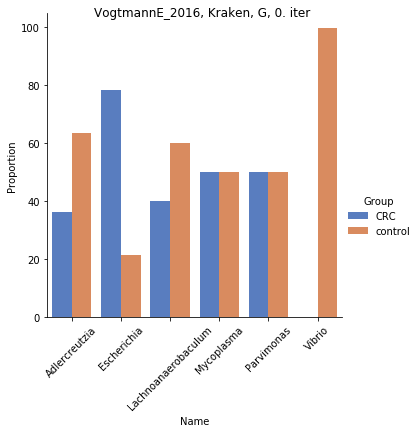

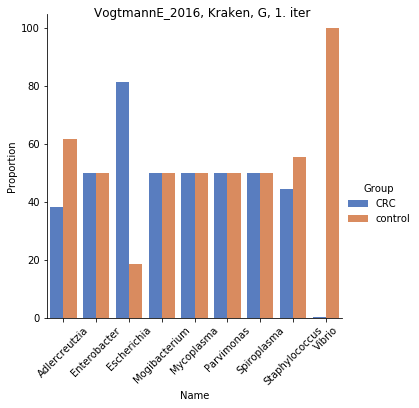

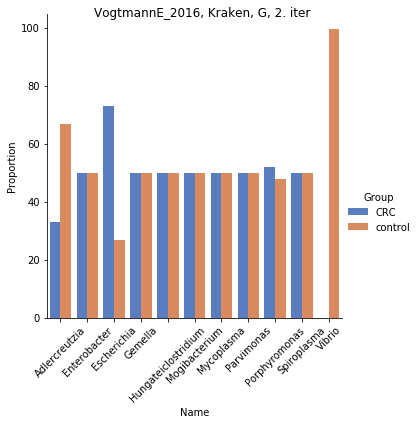

In [556]:
for dataset in datasets:
    for method in methods:
        ranks = []
        if method == "Metaphlan":
            ranks = ranks_m
        else:
            ranks = ranks_k
        for rank in ranks:
            if rank == "G":
                features = run(dataset, method, rank, 10)
            else:
                features = run(dataset, method, rank, 30)

Shape of table: (107, 12)
Iter 0 AUC: 0.7428571428571429
Iter 1 AUC: 0.6000000000000001
Iter 2 AUC: 0.5
Iter 3 AUC: 0.8
Iter 4 AUC: 1.0
Iter 5 AUC: 0.9
Iter 6 AUC: 0.9166666666666667
Iter 7 AUC: 0.5833333333333333
Iter 8 AUC: 0.5208333333333334
Iter 9 AUC: 0.5833333333333333


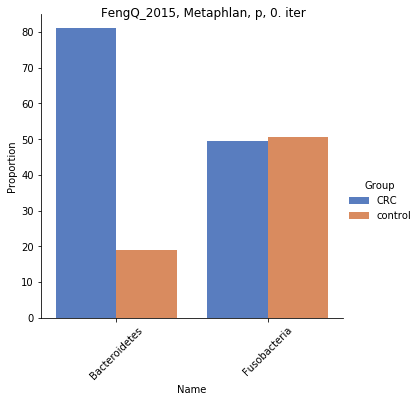

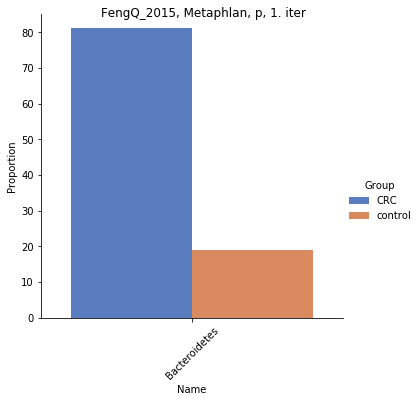

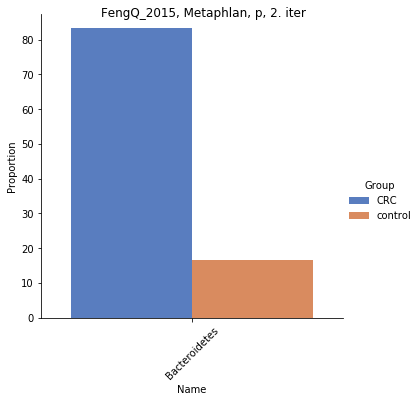

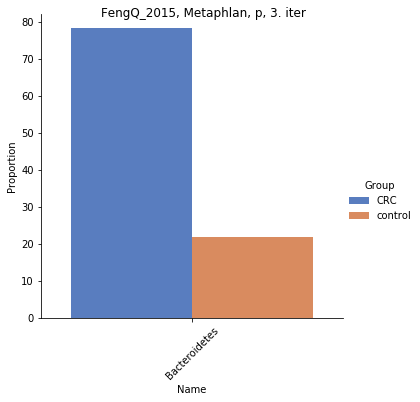

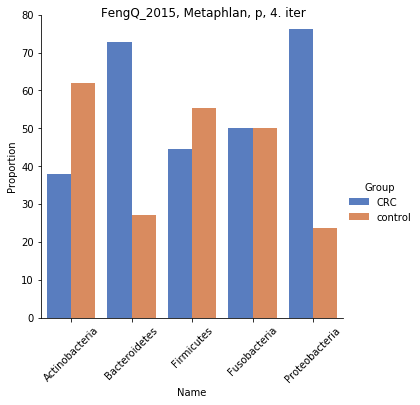

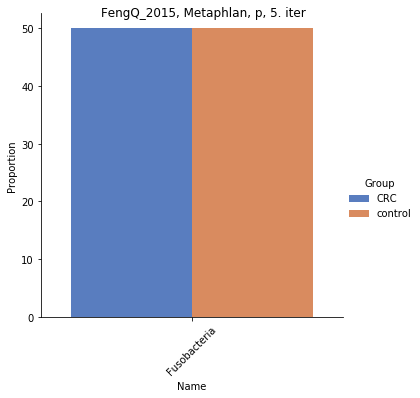

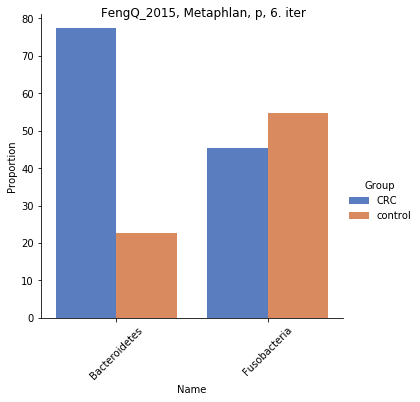

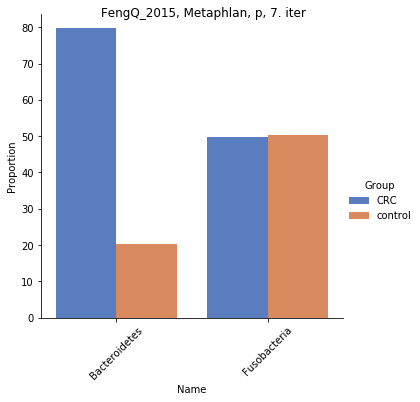

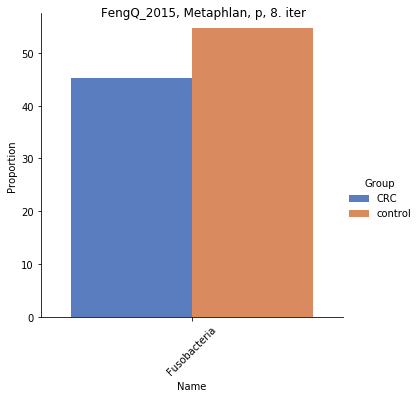

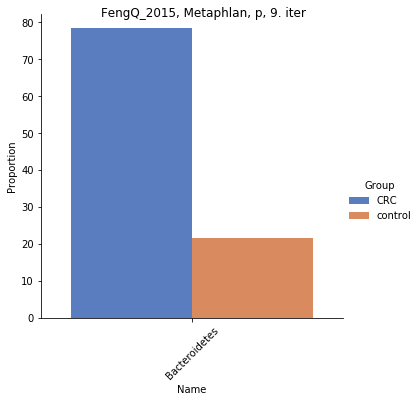

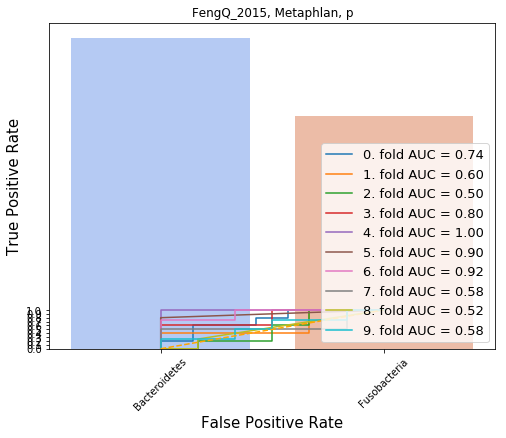

In [551]:
features = run("FengQ_2015", "Metaphlan", "P", 30)

Shape of table: (107, 42)


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 0 AUC: 0.6285714285714286


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 1 AUC: 0.5


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 2 AUC: 0.13333333333333333


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 3 AUC: 0.8


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 4 AUC: 0.6666666666666666


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


No feature was selected.
Error in classification iter.
Iter 5 AUC: 0.7083333333333333


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 6 AUC: 0.5833333333333333


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 7 AUC: 0.625


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 8 AUC: 0.625


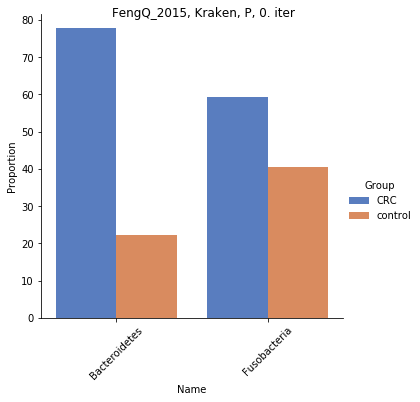

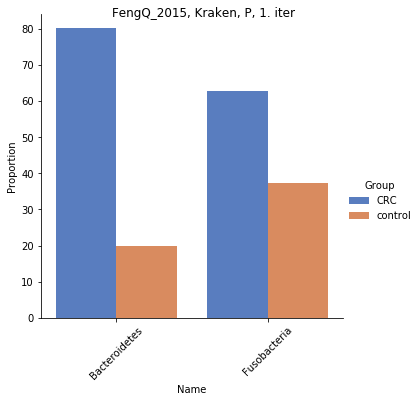

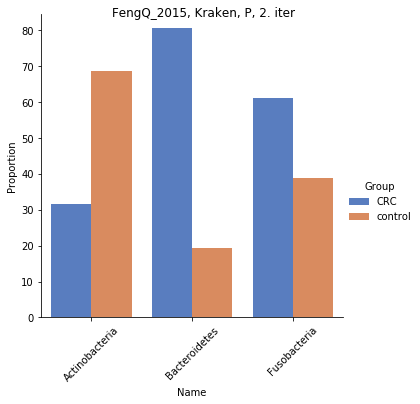

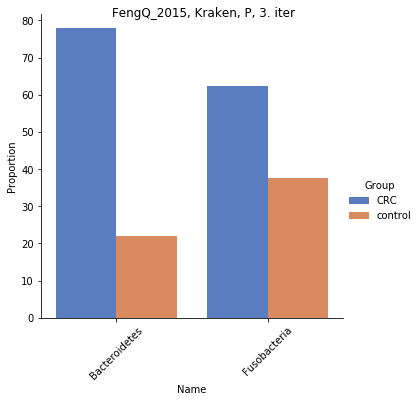

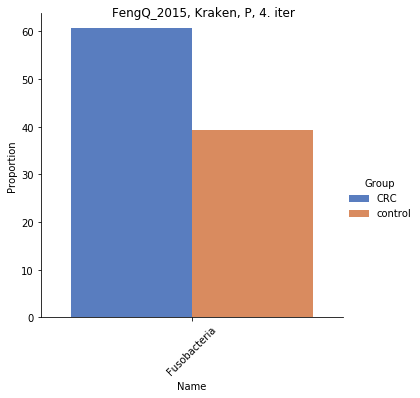

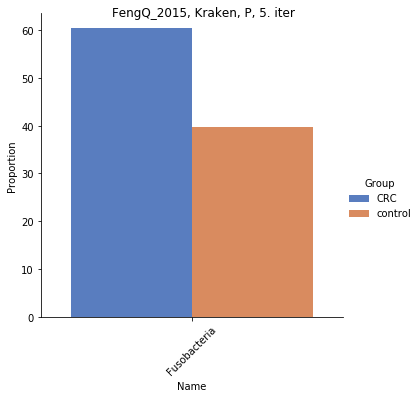

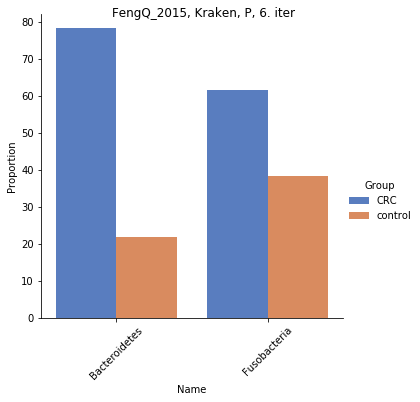

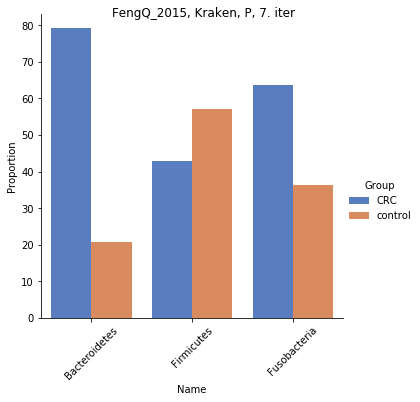

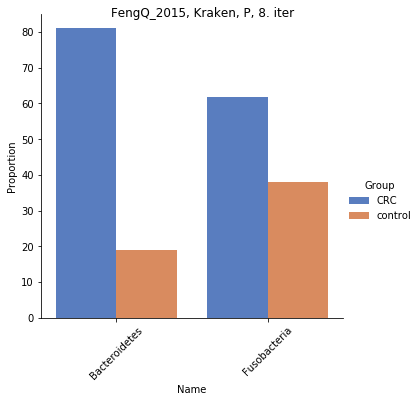

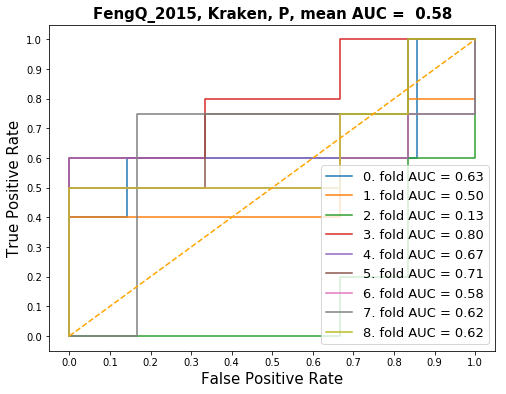

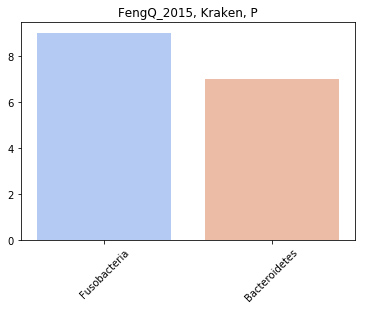

In [534]:
result = run("FengQ_2015", "Kraken", "P", 30)

Shape of table: (107, 19)
Iter 0 AUC: 0.7142857142857143
Iter 1 AUC: 0.6000000000000001
Iter 2 AUC: 0.5
Iter 3 AUC: 0.8
Iter 4 AUC: 0.9666666666666667
Iter 5 AUC: 0.8666666666666667
Iter 6 AUC: 0.9166666666666667
Iter 7 AUC: 0.5833333333333333
Iter 8 AUC: 0.6666666666666667
Iter 9 AUC: 0.5833333333333333


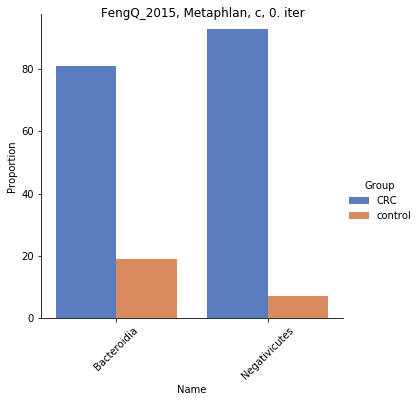

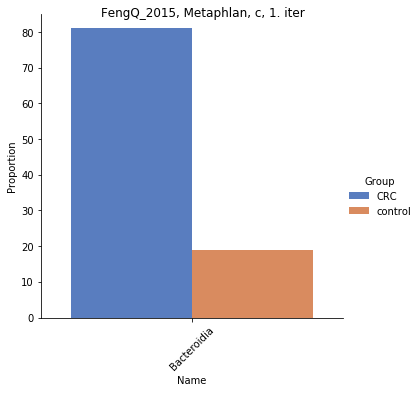

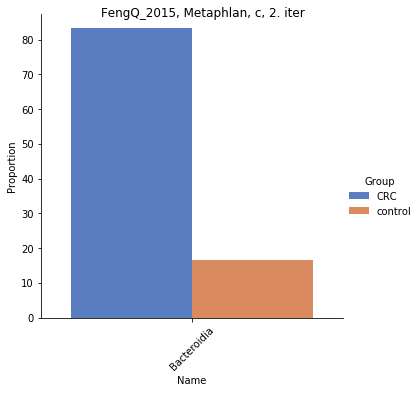

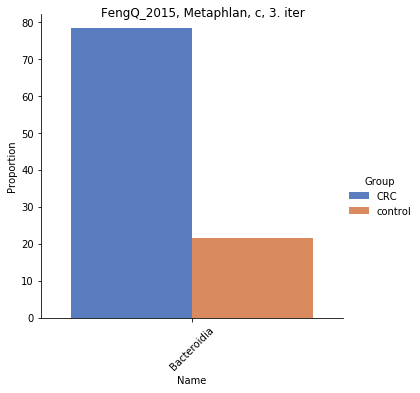

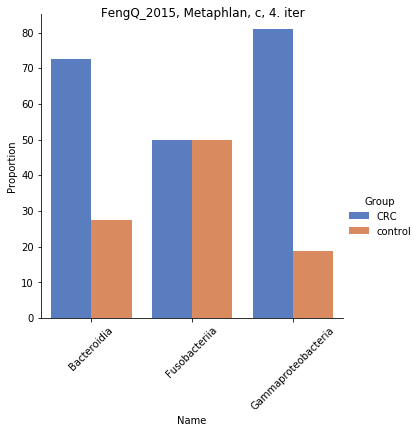

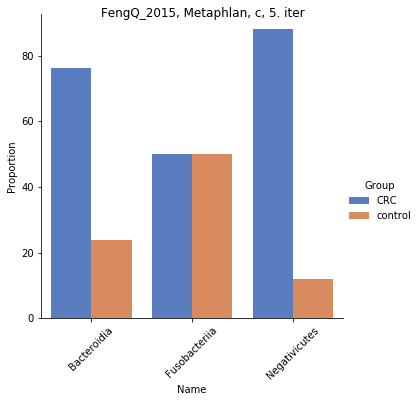

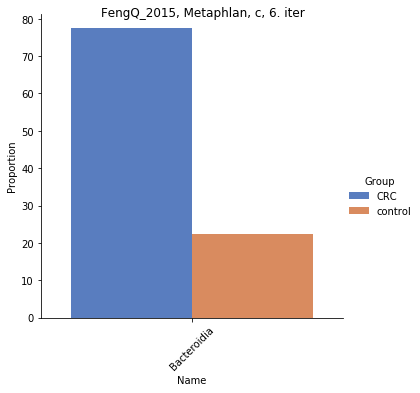

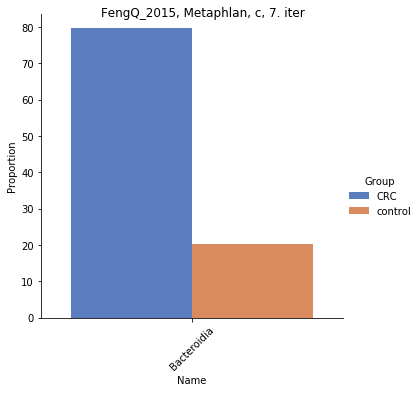

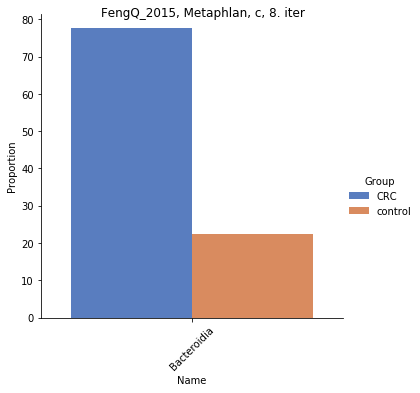

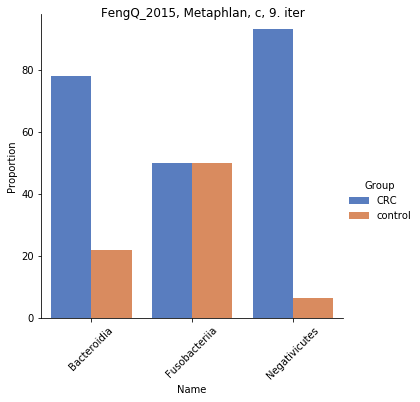

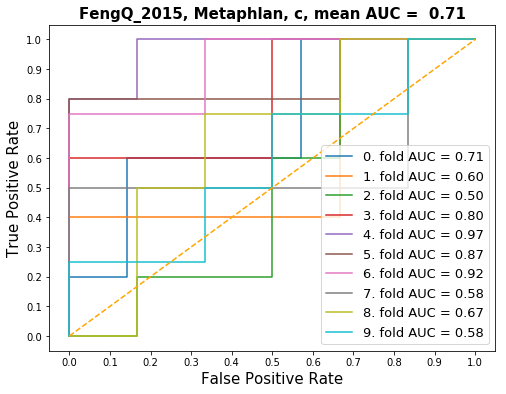

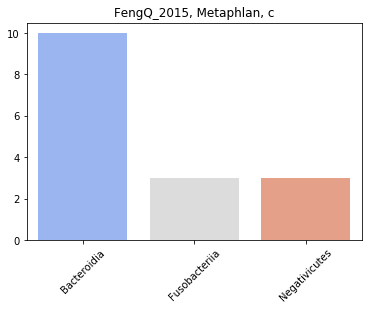

In [535]:
toplot = result = run("FengQ_2015", "Metaphlan", "c", 30)

Shape of table: (107, 81)


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 0 AUC: 0.6285714285714286


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 1 AUC: 0.4666666666666667


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 2 AUC: 0.5


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 3 AUC: 0.6666666666666666


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


No feature was selected.
Error in classification iter.
No feature was selected.
Error in classification iter.
Iter 4 AUC: 0.7916666666666667


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 5 AUC: 0.625


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 6 AUC: 0.7083333333333334


/gfs/progs/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


Iter 7 AUC: 0.625


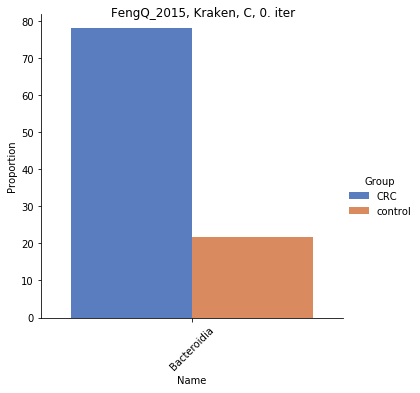

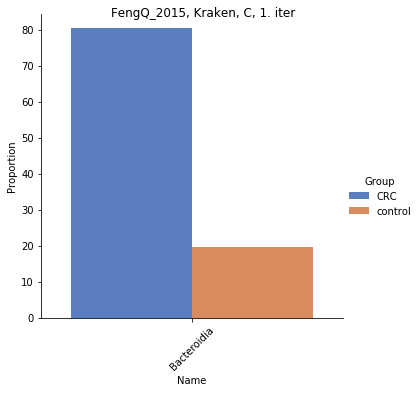

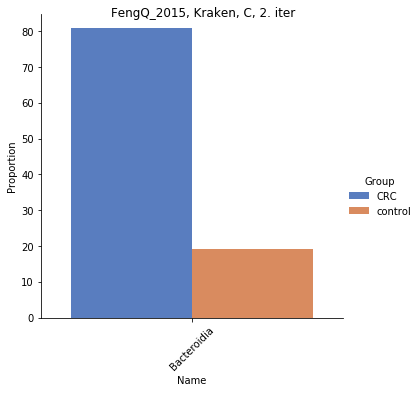

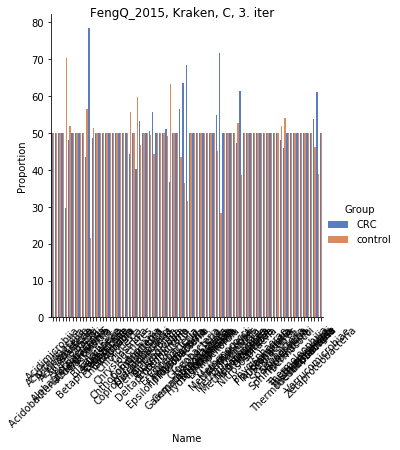

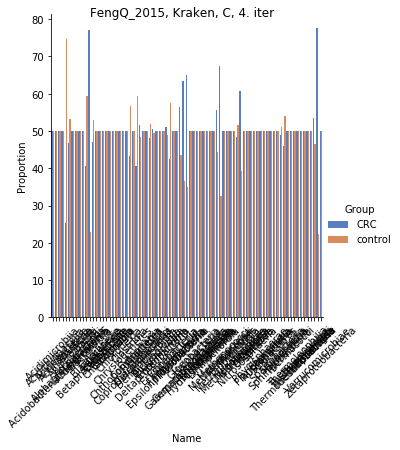

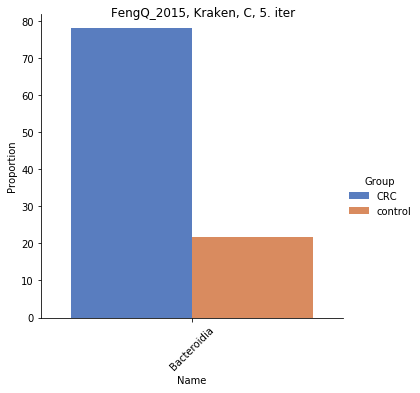

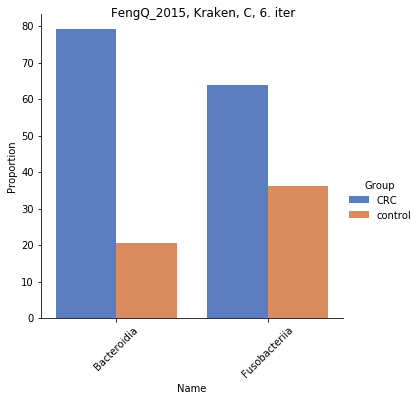

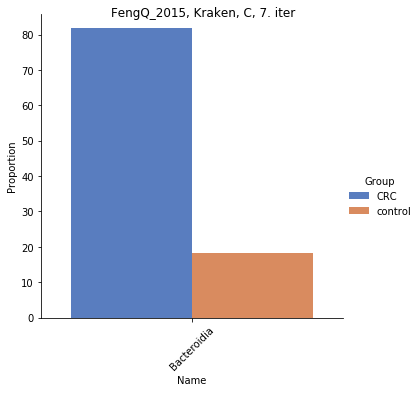

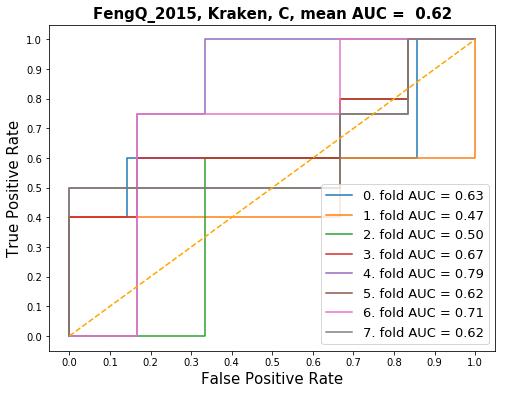

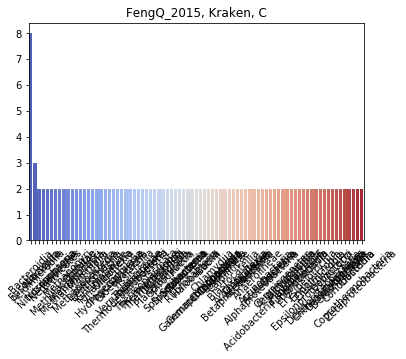

In [536]:
toplot = result = run("FengQ_2015", "Kraken", "C", 30)

Shape of table: (107, 45)
Iter 0 AUC: 0.6285714285714286
Iter 1 AUC: 0.5
Iter 2 AUC: 0.4666666666666667
Iter 3 AUC: 0.7166666666666667
Iter 4 AUC: 0.7333333333333334
Iter 5 AUC: 0.9
Iter 6 AUC: 0.7083333333333333
Iter 7 AUC: 0.5416666666666667
Iter 8 AUC: 0.6666666666666667
Iter 9 AUC: 0.49999999999999994


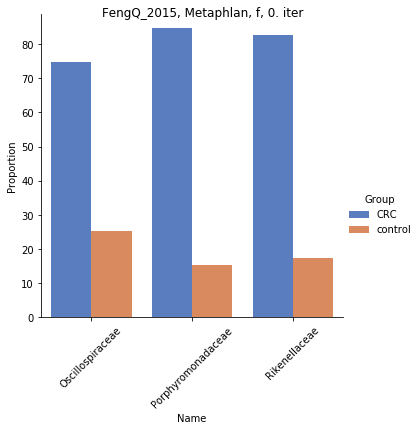

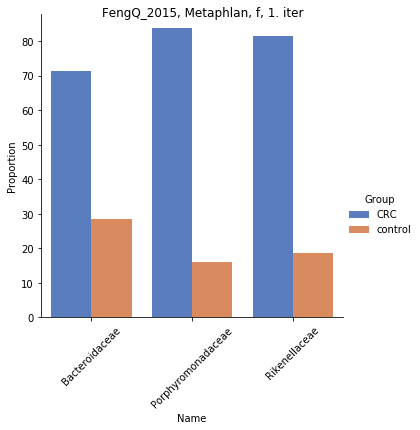

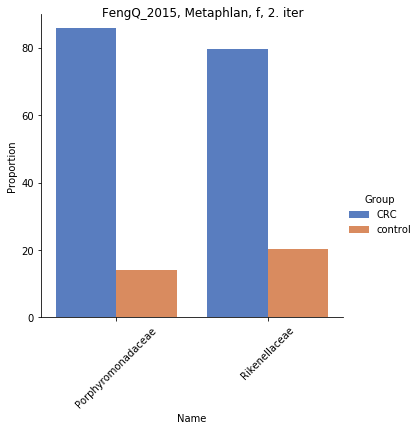

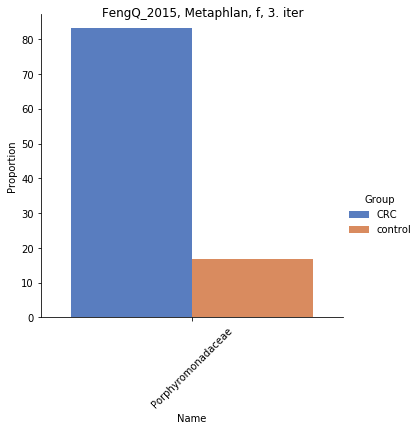

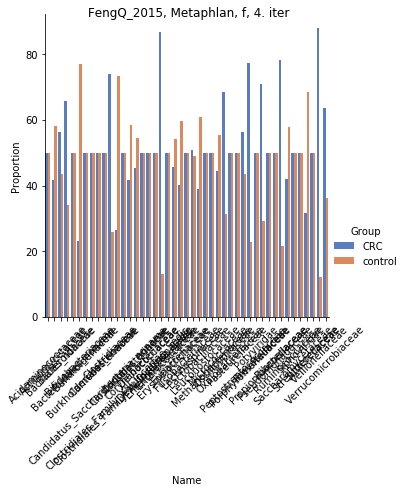

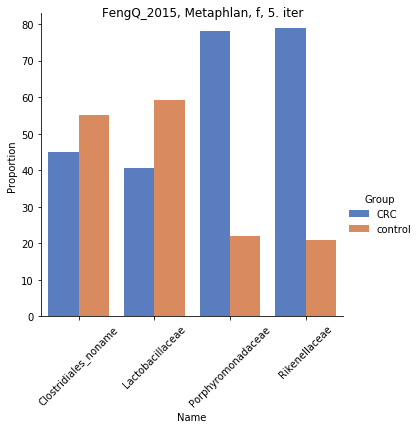

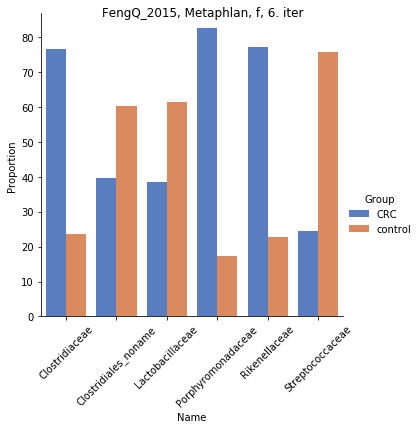

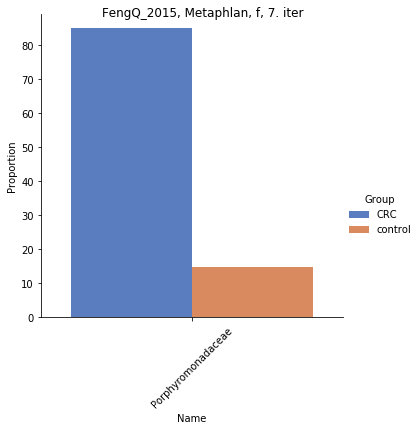

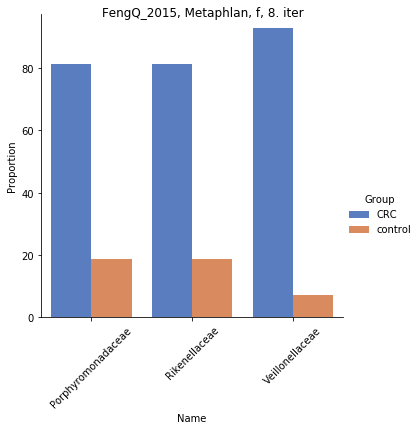

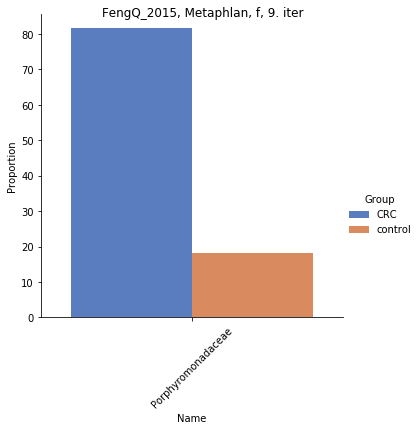

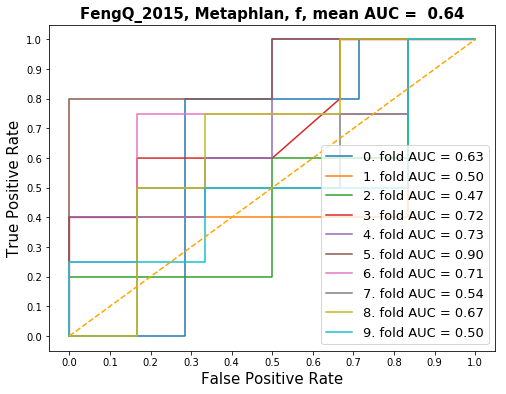

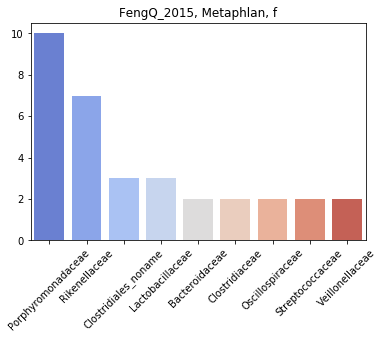

In [537]:
result = run("FengQ_2015", "Metaphlan", "f", 30)

Shape of table: (107, 85)
Iter 0 AUC: 0.742857142857143
Iter 1 AUC: 0.33333333333333337
Iter 2 AUC: 0.5
Iter 3 AUC: 0.7000000000000001
Iter 4 AUC: 1.0
Iter 5 AUC: 0.9666666666666667
Iter 6 AUC: 0.9166666666666666
Iter 7 AUC: 0.5625
Iter 8 AUC: 0.5833333333333333
Iter 9 AUC: 0.33333333333333337


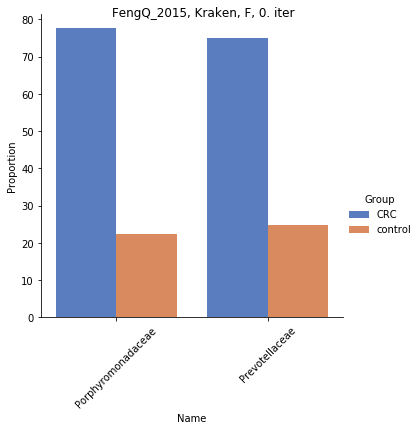

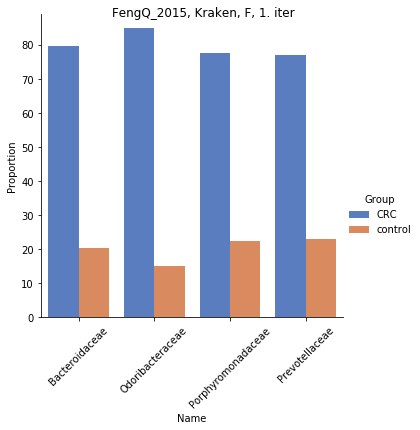

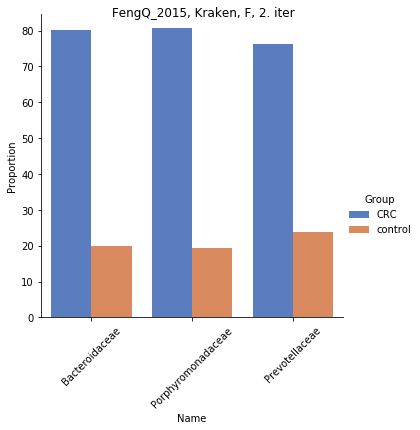

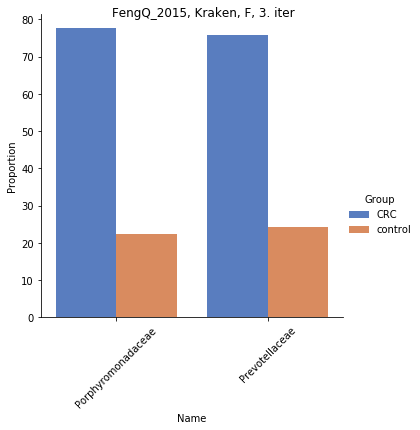

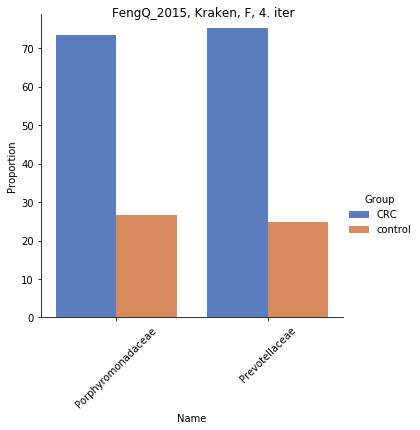

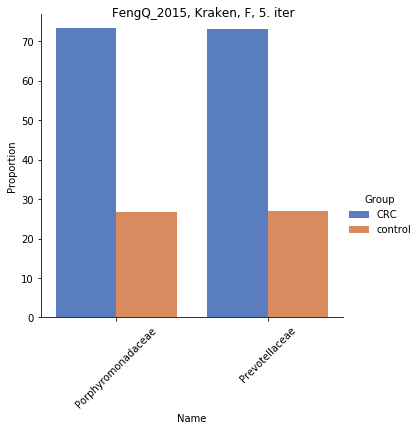

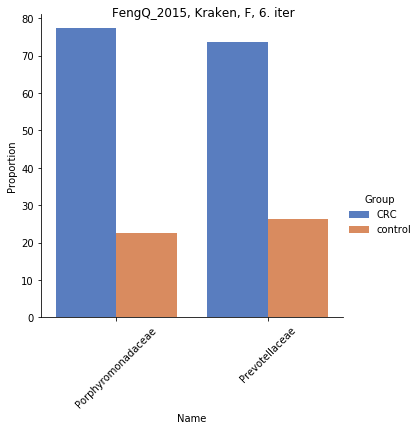

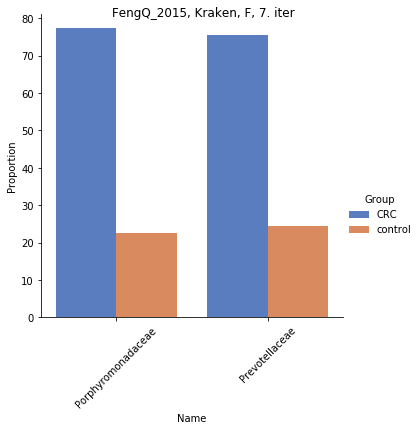

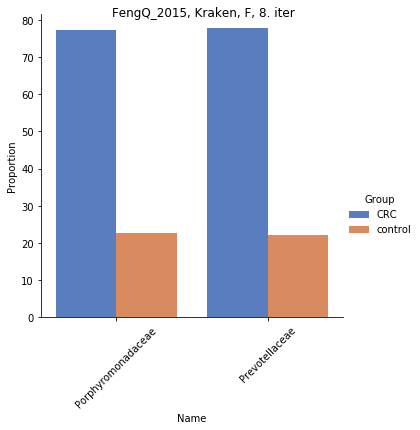

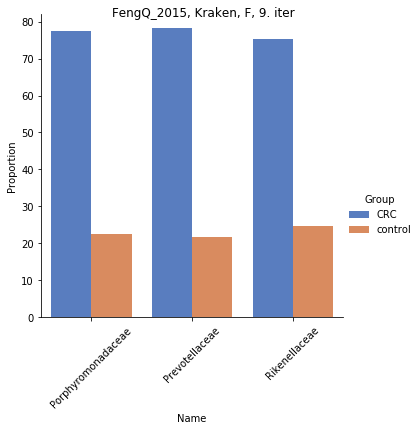

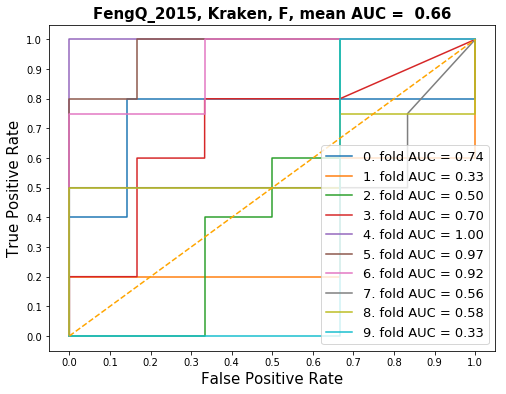

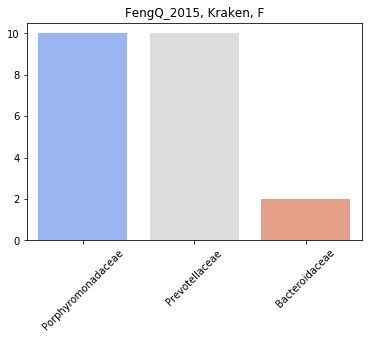

In [538]:
result = run("FengQ_2015", "Kraken", "F", 30)

Shape of table: (107, 69)
Iter 0 AUC: 0.5428571428571429
Iter 1 AUC: 0.5
Iter 2 AUC: 0.5
Iter 3 AUC: 0.5666666666666667
Iter 4 AUC: 0.45
Iter 5 AUC: 0.7666666666666667
Iter 6 AUC: 0.7083333333333334
Iter 7 AUC: 0.625
Iter 8 AUC: 0.3333333333333333
Iter 9 AUC: 0.4166666666666667


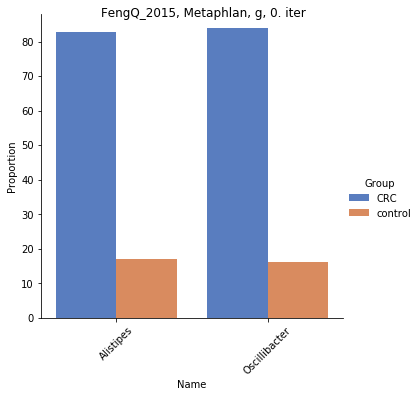

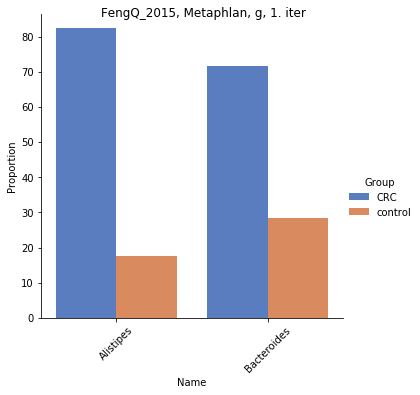

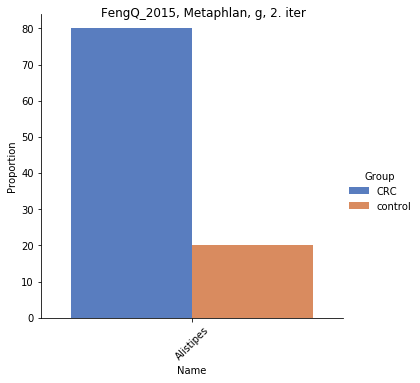

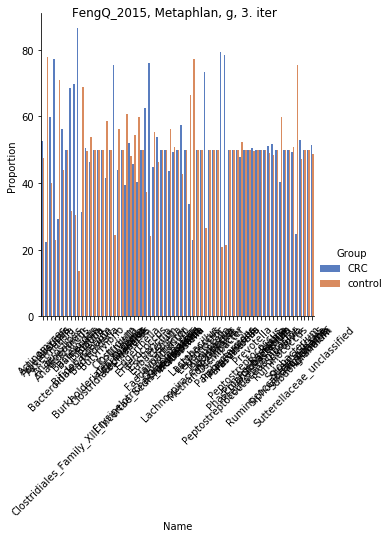

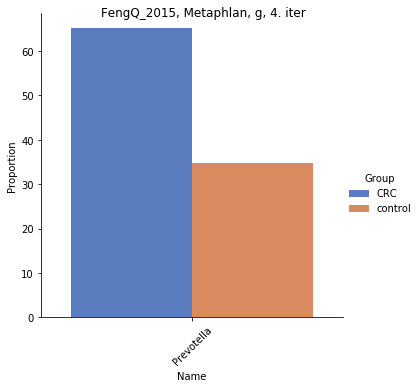

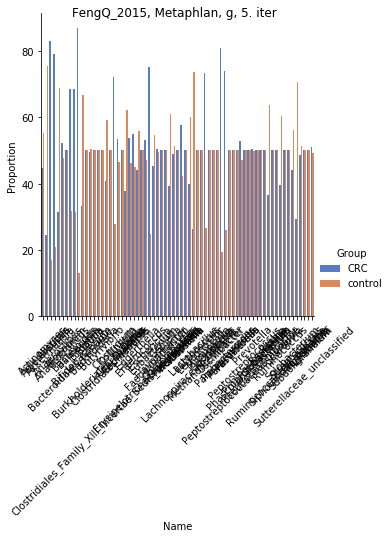

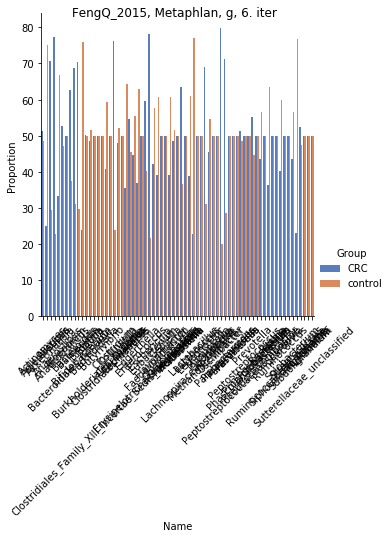

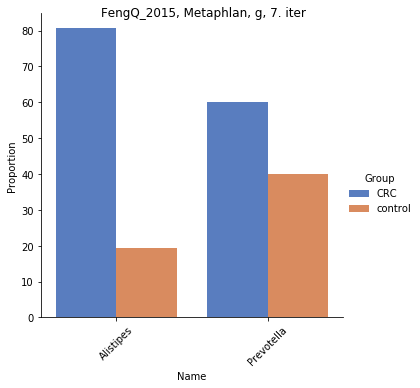

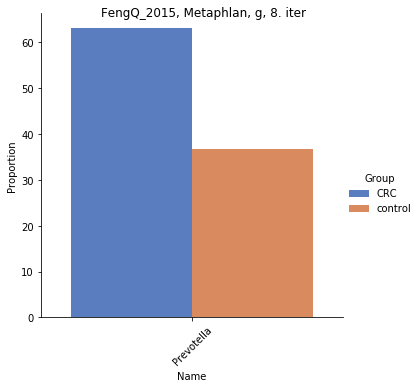

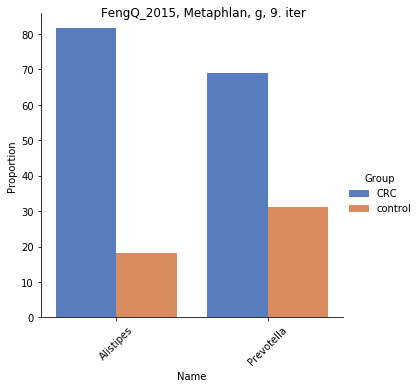

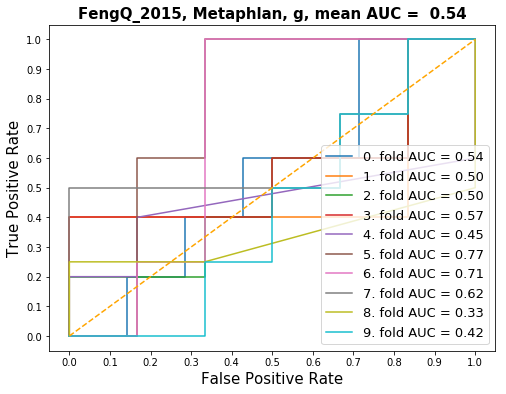

Actinomyces  Adlercreutzia  Akkermansia  Alistipes  Anaerostipes  \
0            3              3            3          8             3   

   Anaerotruncus  Atopobium  Bacteroidales_noname  Bacteroides  Barnesiella  \
0              3          3                     3            4            3   

      ...       Ruminococcaceae_noname  Ruminococcus  Scardovia  \
0     ...                            3             3          3   

   Siphoviridae_noname  Solobacterium  Streptococcus  Subdoligranulum  \
0                    3              3              3                3   

   Sutterellaceae_unclassified  Turicibacter  Veillonella  
0                            3             3            3  

[1 rows x 69 columns]

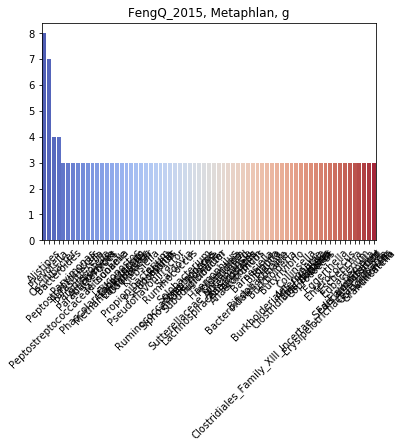

In [539]:
run("FengQ_2015", "Metaphlan", "g", 30)

Shape of table: (107, 71)
Iter 0 AUC: 0.6
Iter 1 AUC: 0.33333333333333337
Iter 2 AUC: 0.5
Iter 3 AUC: 0.6333333333333333
Iter 4 AUC: 1.0
Iter 5 AUC: 0.8666666666666667
Iter 6 AUC: 0.9583333333333334
Iter 7 AUC: 0.5416666666666666
Iter 8 AUC: 0.625
Iter 9 AUC: 0.625


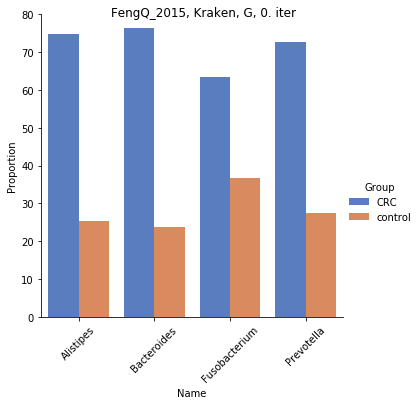

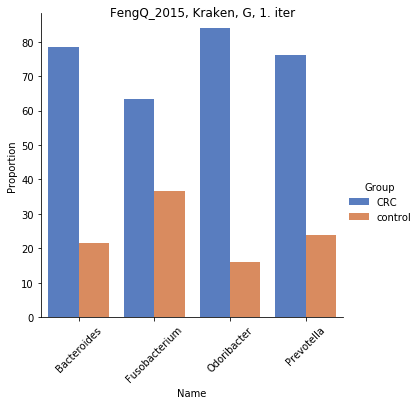

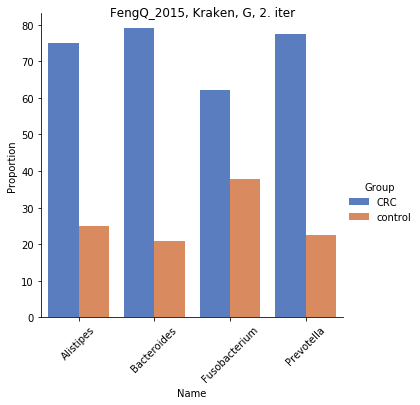

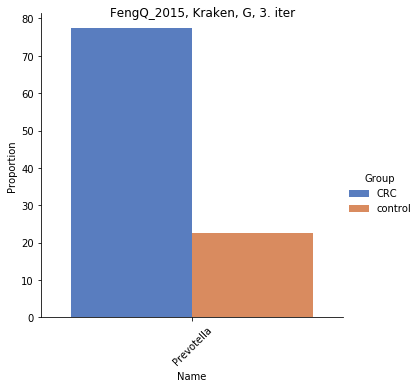

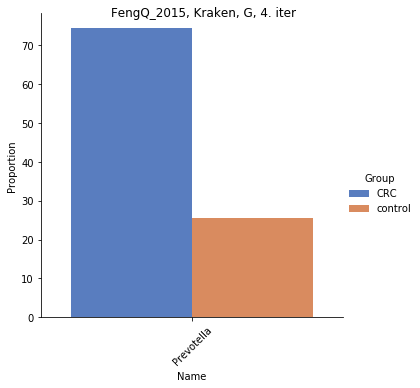

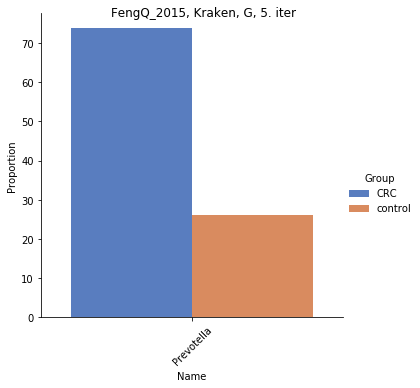

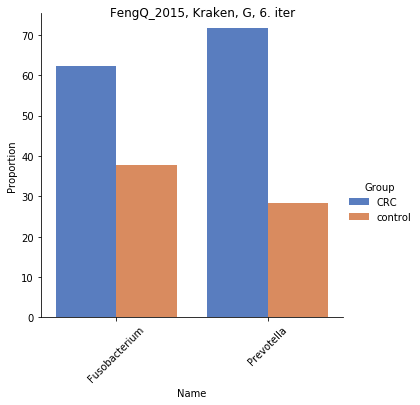

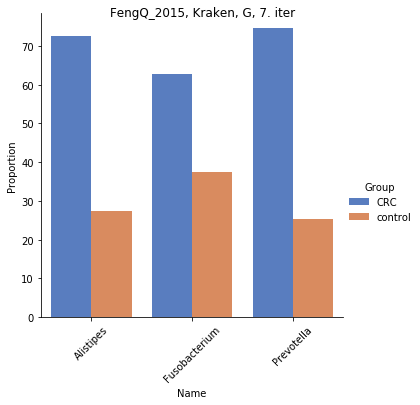

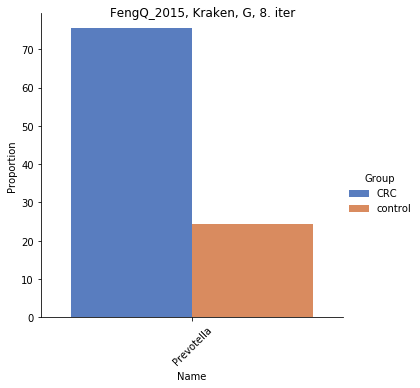

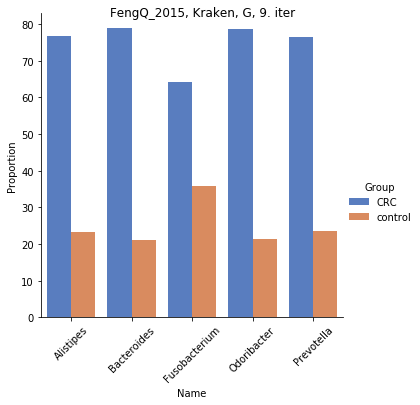

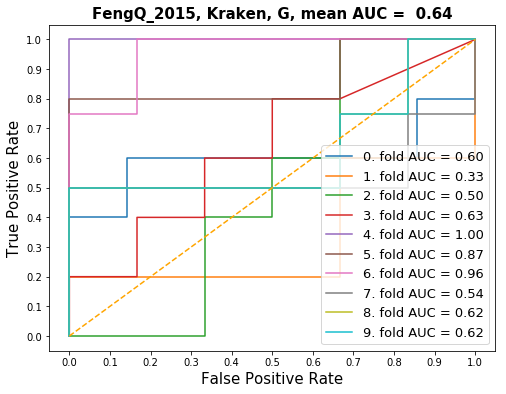

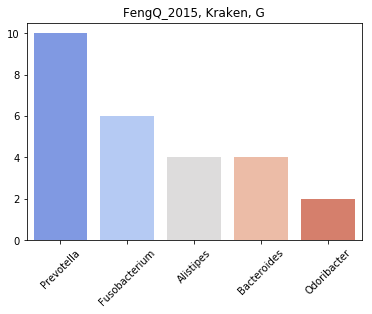

In [542]:
toplot = result = run("FengQ_2015", "Kraken", "G", 10)

Shape of table: (107, 51)
Iter 0 AUC: 0.6000000000000001
Iter 1 AUC: 0.6666666666666667
Iter 2 AUC: 0.7
Iter 3 AUC: 0.5
Iter 4 AUC: 0.7666666666666667
Iter 5 AUC: 0.8333333333333334
Iter 6 AUC: 0.625
Iter 7 AUC: 0.75
Iter 8 AUC: 0.7083333333333334
No feature was selected.
Error in classification iter.


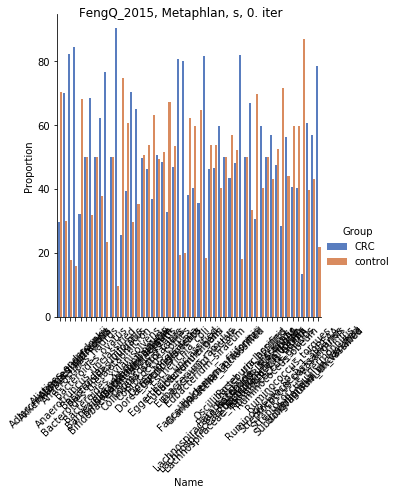

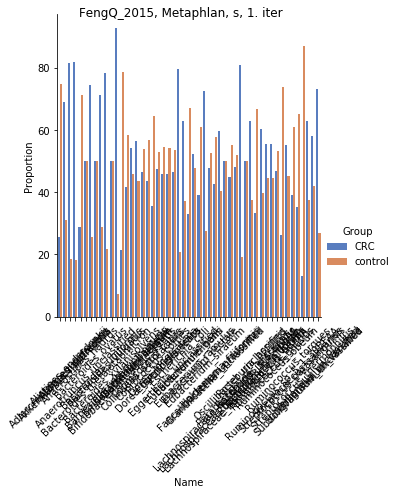

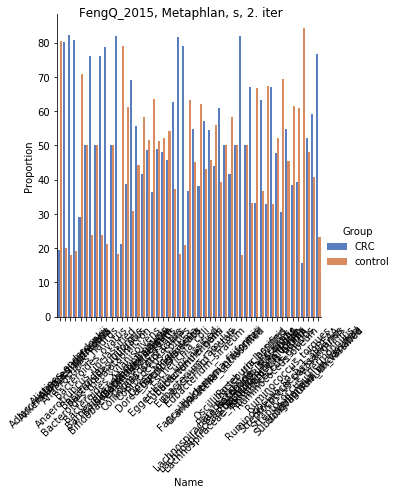

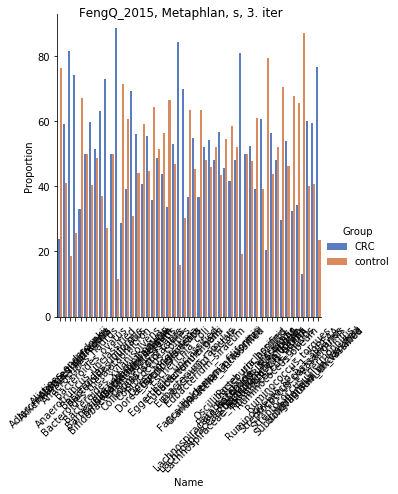

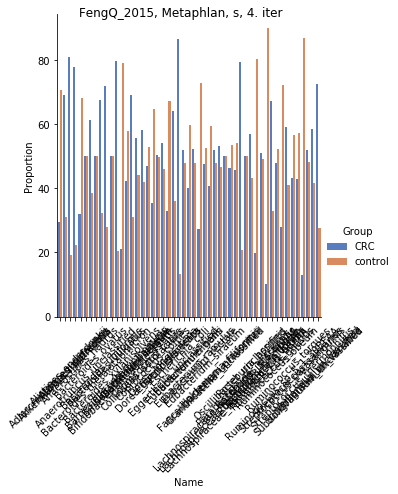

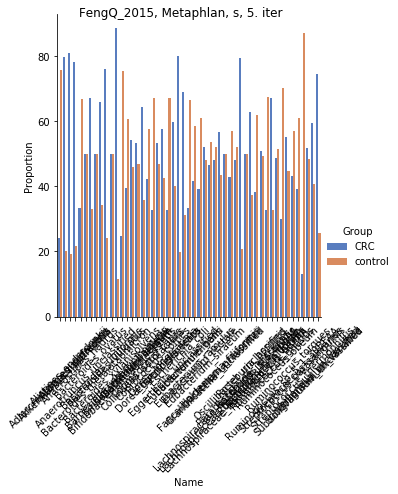

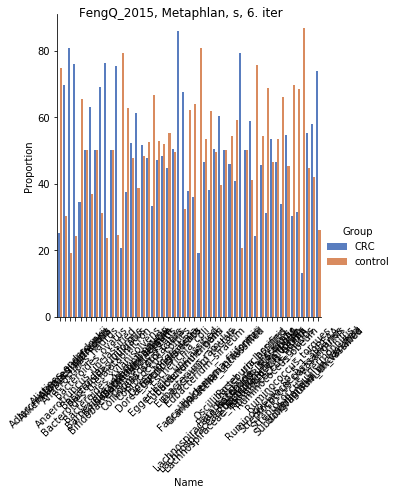

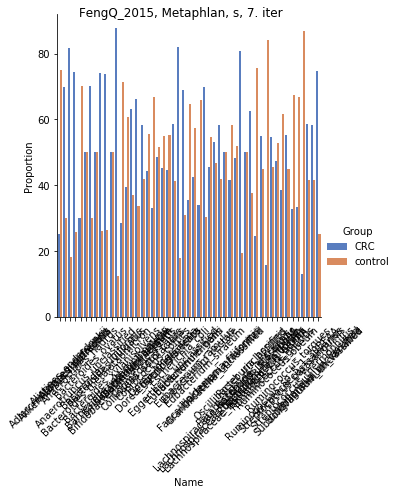

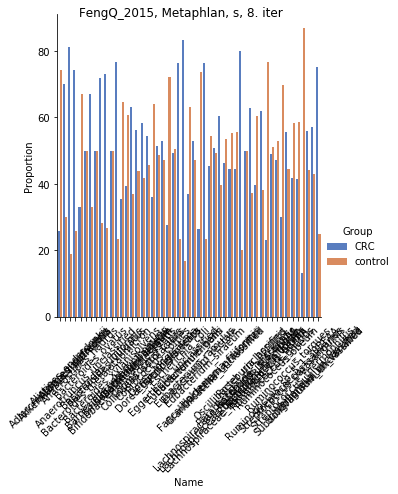

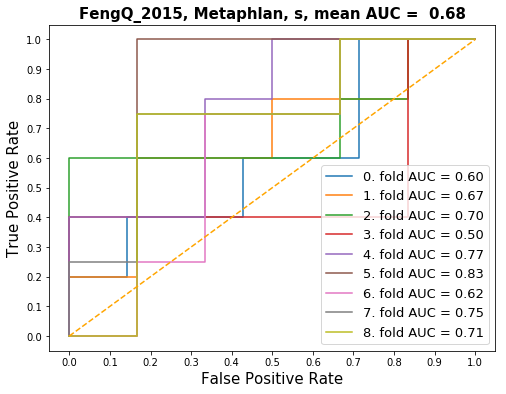

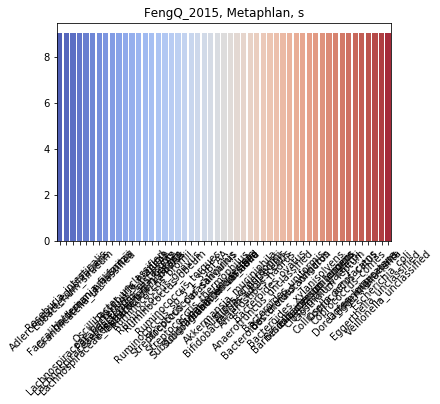

In [543]:
toplot = result = run("FengQ_2015", "Metaphlan", "s", 30)

In [ ]:
toplot = result = run("FengQ_2015", "Kraken", "S", 5)

Shape of table: (417, 15)
Iter 0 AUC: 0.538548752834467
Iter 1 AUC: 0.5929705215419502
Iter 2 AUC: 0.5442176870748299
Iter 3 AUC: 0.4217687074829932
Iter 4 AUC: 0.6575963718820861
Iter 5 AUC: 0.6553287981859409
Iter 6 AUC: 0.5804988662131519
Iter 7 AUC: 0.34240362811791386
Iter 8 AUC: 0.47619047619047616
Iter 9 AUC: 0.5200000000000001


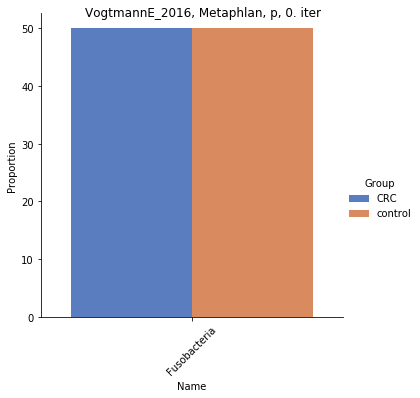

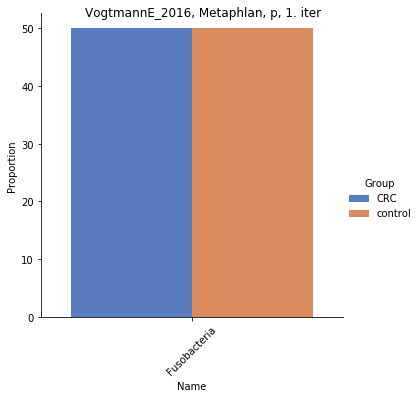

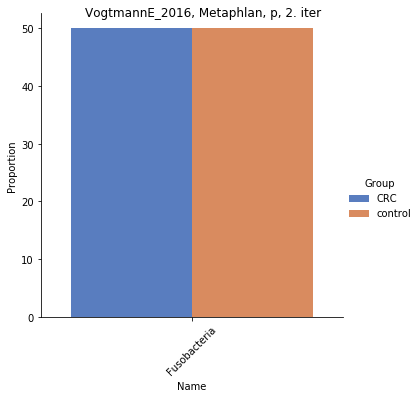

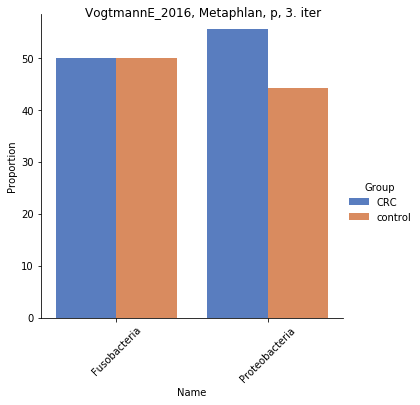

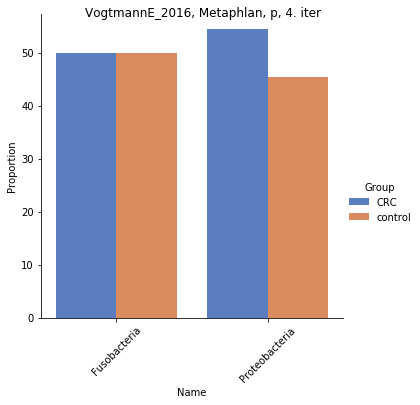

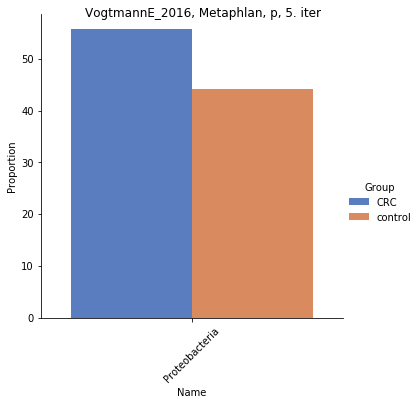

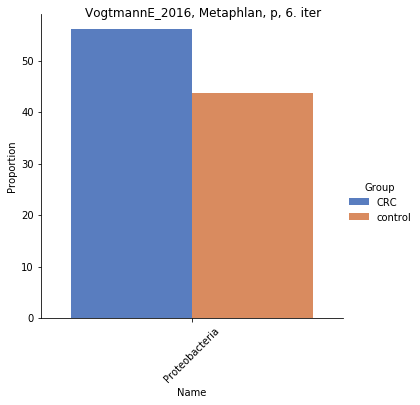

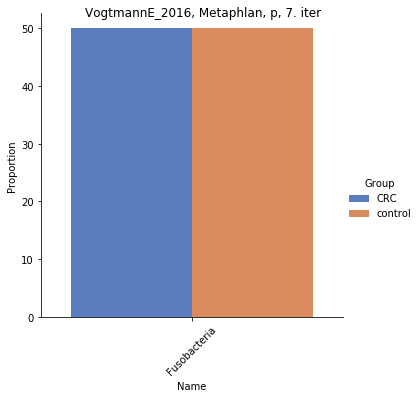

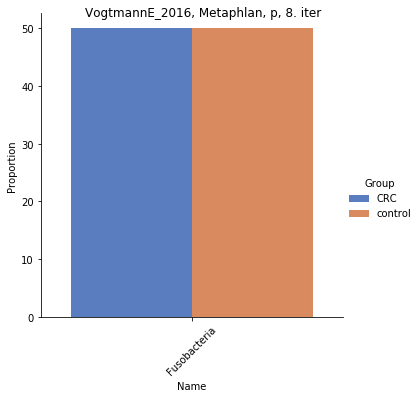

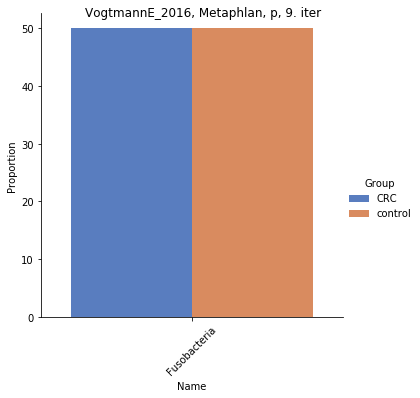

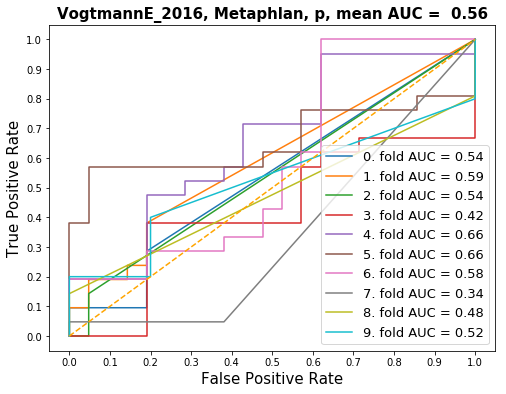

Shape of table: (417, 20)
Iter 0 AUC: 0.6122448979591836
Iter 1 AUC: 0.2947845804988662
Iter 2 AUC: 0.7868480725623582
Iter 3 AUC: 0.4988662131519275
Iter 4 AUC: 0.35147392290249435
Iter 5 AUC: 0.4920634920634921
Iter 6 AUC: 0.562358276643991
Iter 7 AUC: 0.5419501133786849
Iter 8 AUC: 0.46190476190476193
Iter 9 AUC: 0.8125


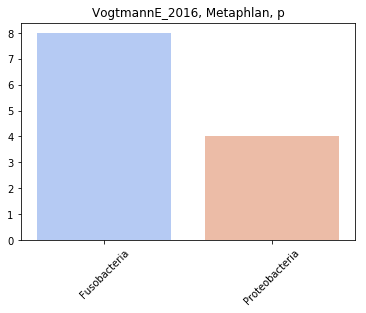

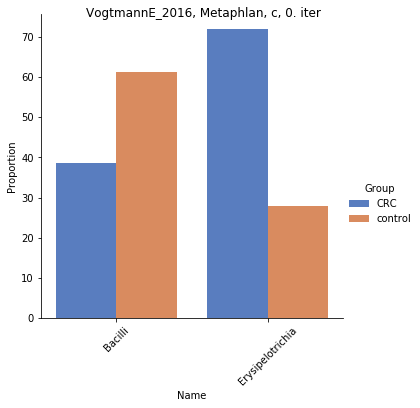

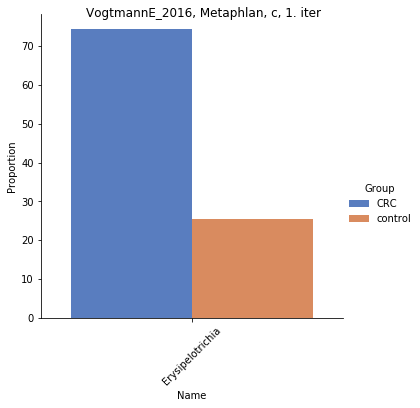

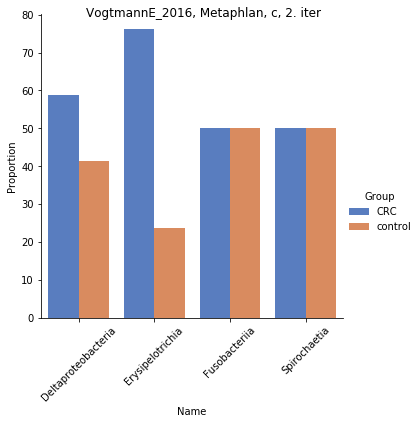

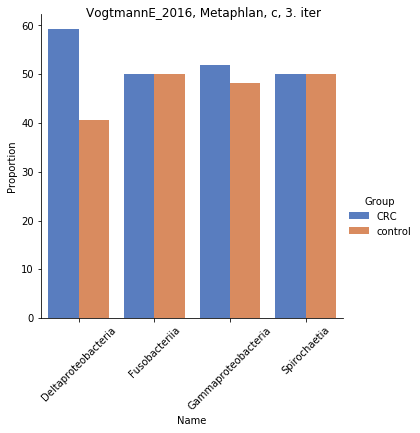

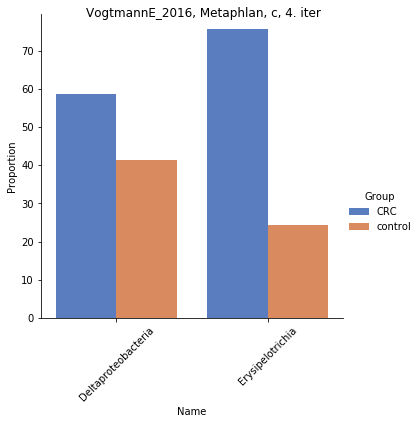

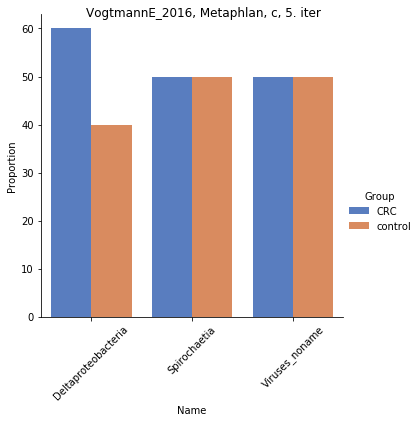

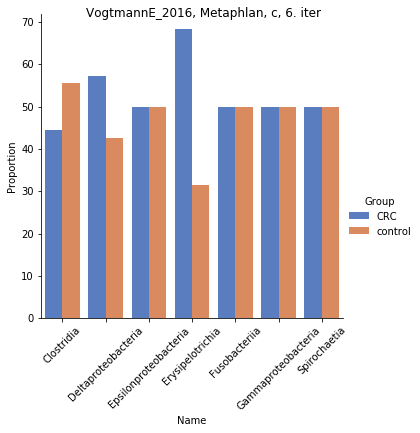

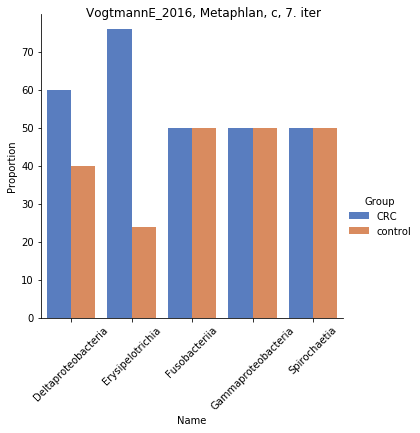

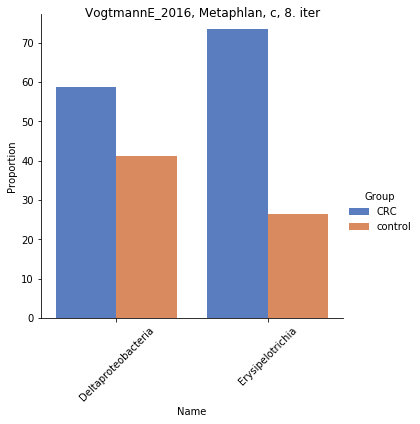

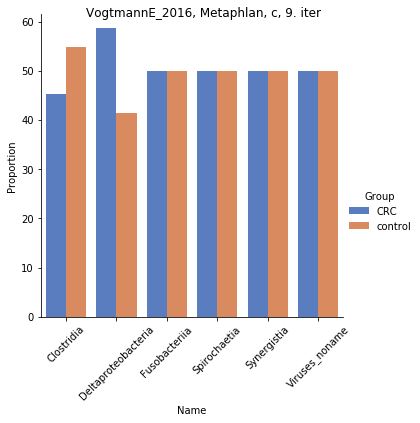

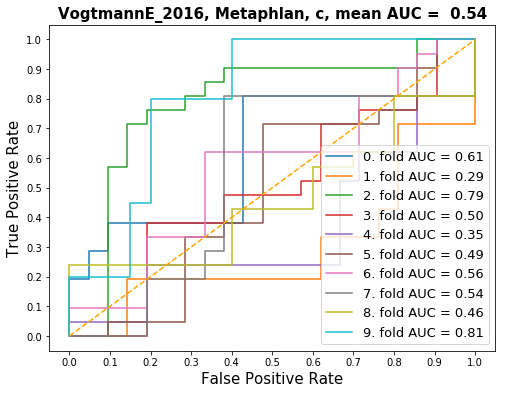

Shape of table: (417, 44)
Iter 0 AUC: 0.4852607709750567
Iter 1 AUC: 0.2766439909297052
Iter 2 AUC: 0.5056689342403629
Iter 3 AUC: 0.5328798185941043
Iter 4 AUC: 0.1111111111111111
Iter 5 AUC: 0.34467120181405897
Iter 6 AUC: 0.6281179138321995
Iter 7 AUC: 0.4399092970521542
Iter 8 AUC: 0.4023809523809524
Iter 9 AUC: 0.40375


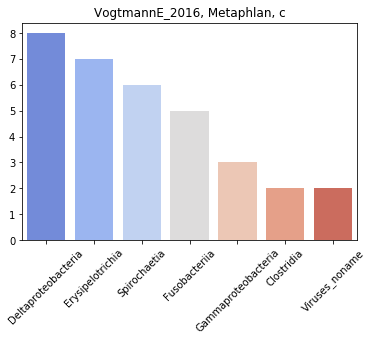

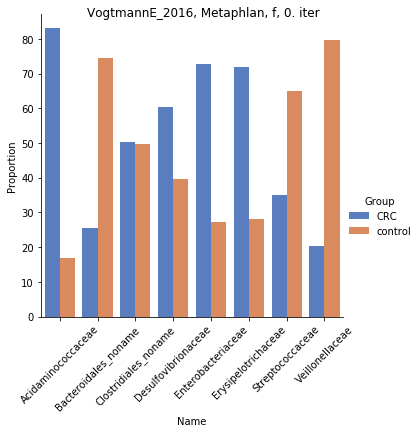

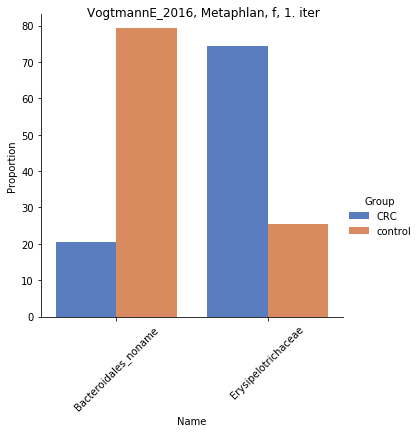

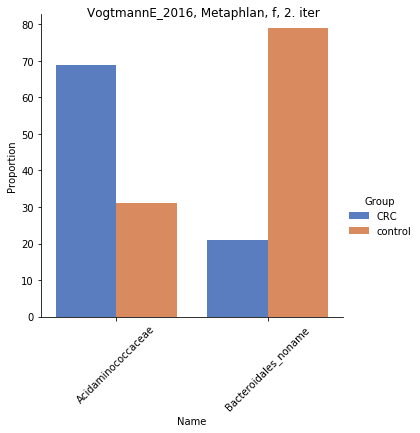

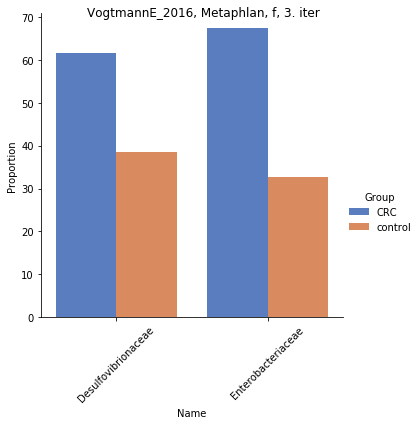

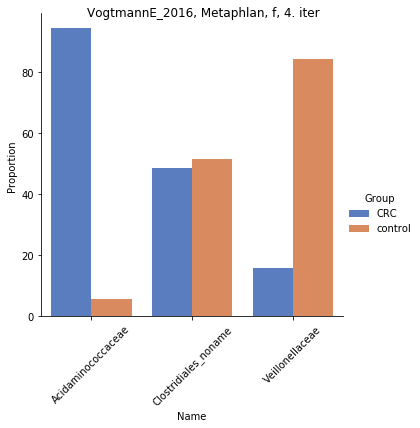

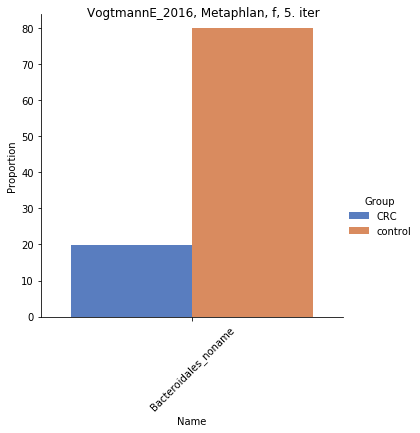

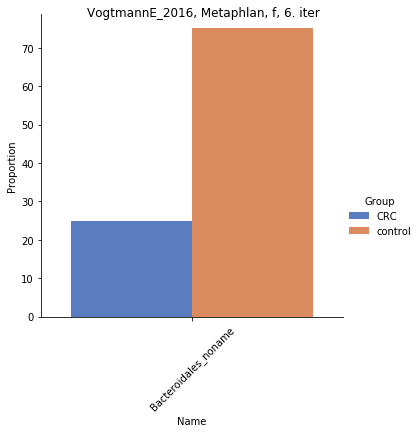

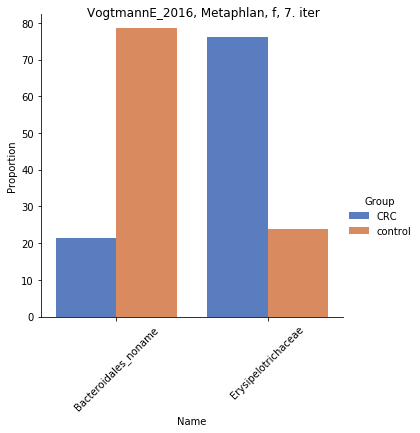

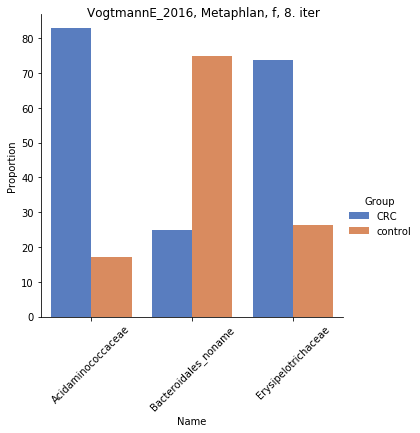

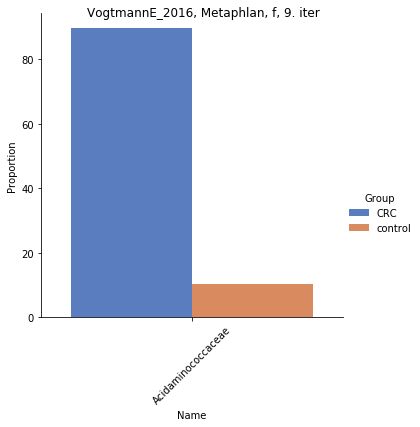

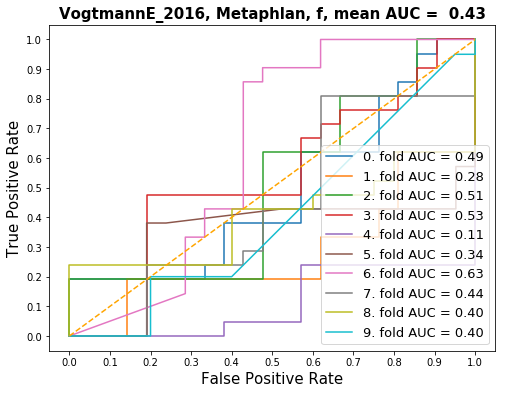

Shape of table: (417, 84)
Iter 0 AUC: 0.46938775510204084
Iter 1 AUC: 0.3129251700680272
Iter 2 AUC: 0.5170068027210885
Iter 3 AUC: 0.6009070294784581
Iter 4 AUC: 0.5034013605442177
Iter 5 AUC: 0.4852607709750567
Iter 6 AUC: 0.5
Iter 7 AUC: 0.30839002267573695
Iter 8 AUC: 0.34285714285714286
Iter 9 AUC: 0.8400000000000001


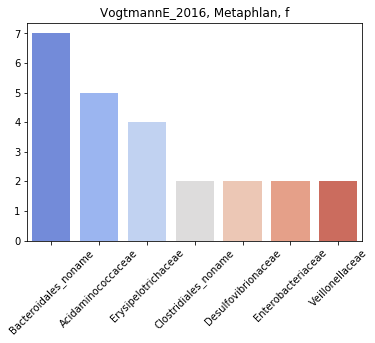

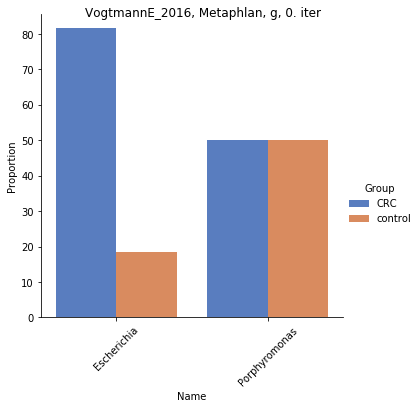

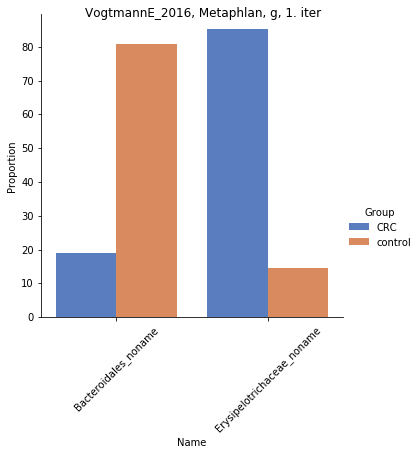

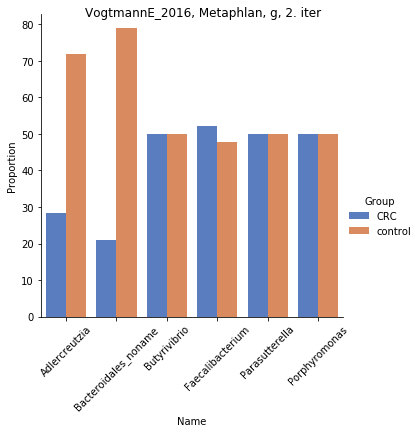

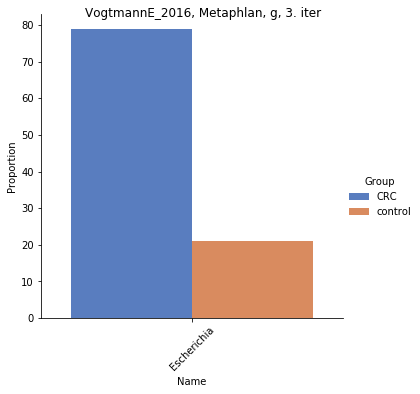

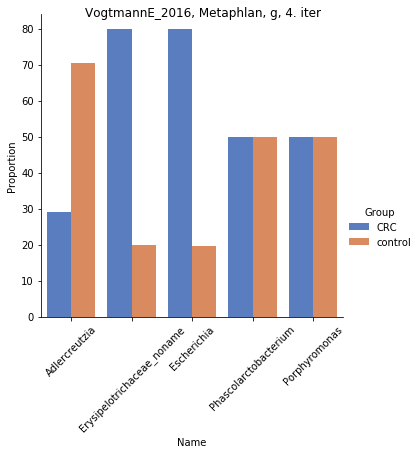

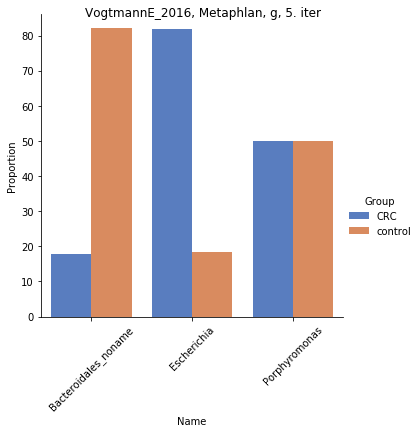

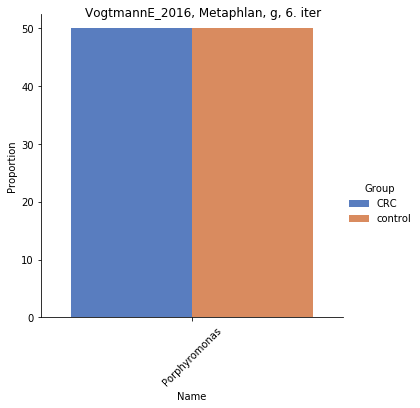

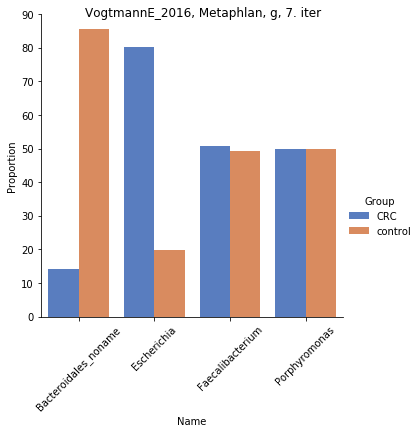

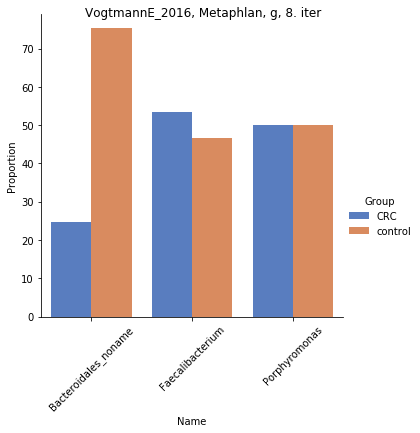

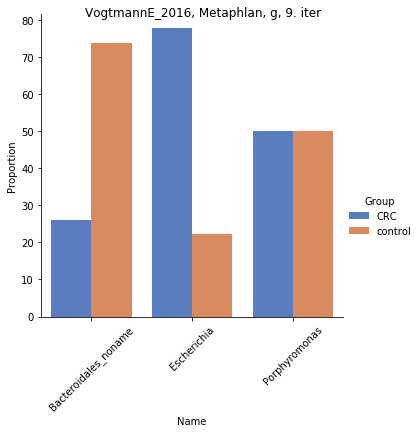

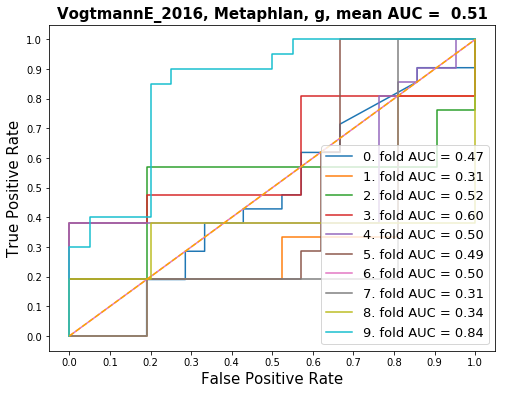

Shape of table: (417, 145)
Iter 0 AUC: 0.4897959183673469
Iter 1 AUC: 0.6780045351473923
Iter 2 AUC: 0.7596371882086167
Iter 3 AUC: 0.782312925170068
Iter 4 AUC: 0.7324263038548753
Iter 5 AUC: 0.417233560090703
Iter 6 AUC: 0.6802721088435375
Iter 7 AUC: 0.3469387755102041
Iter 8 AUC: 0.7952380952380953
Iter 9 AUC: 0.7224999999999999


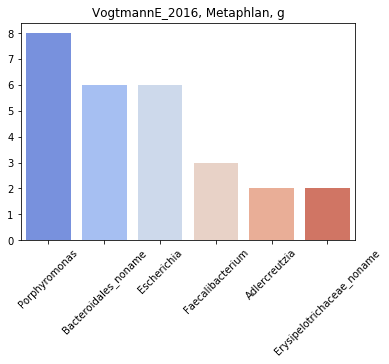

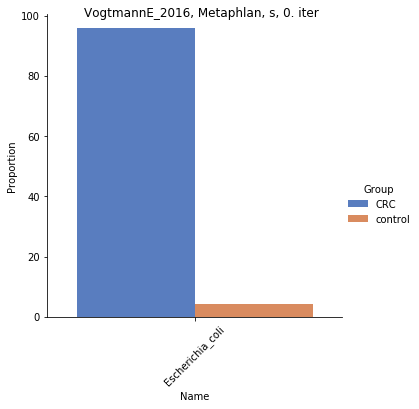

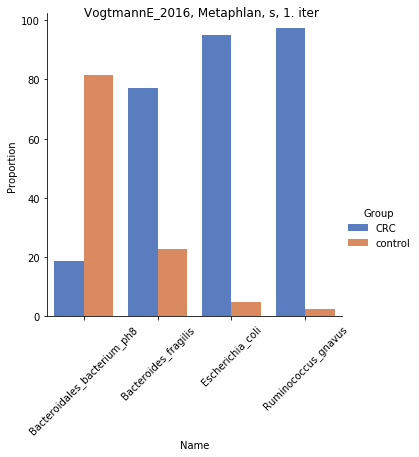

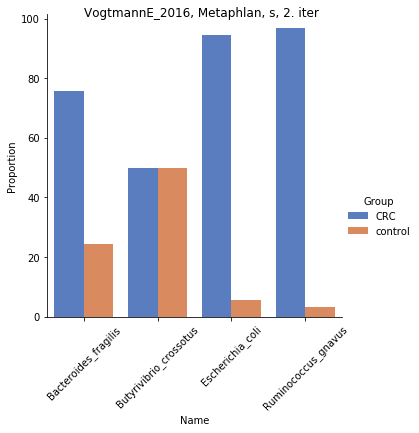

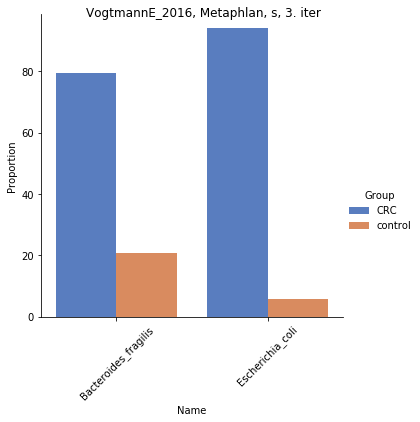

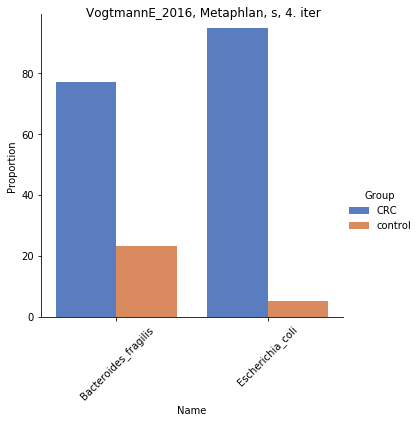

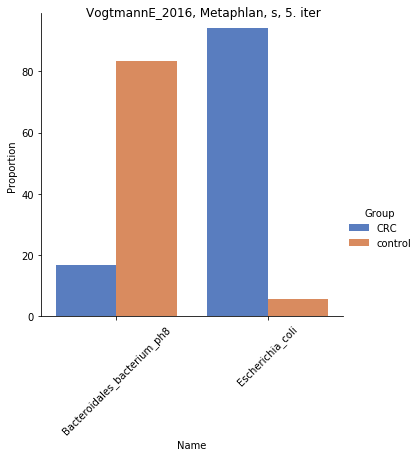

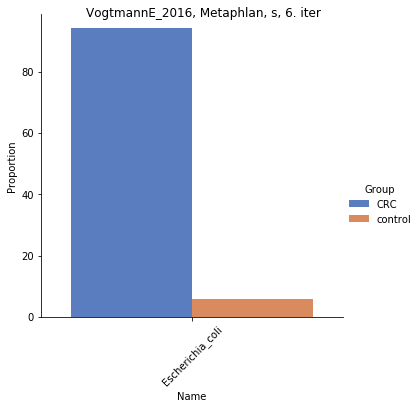

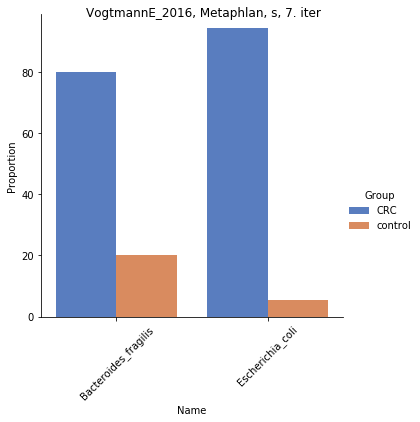

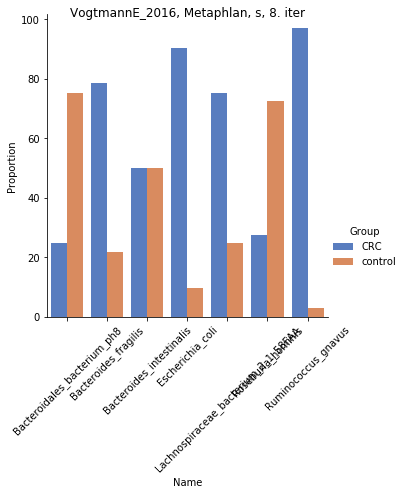

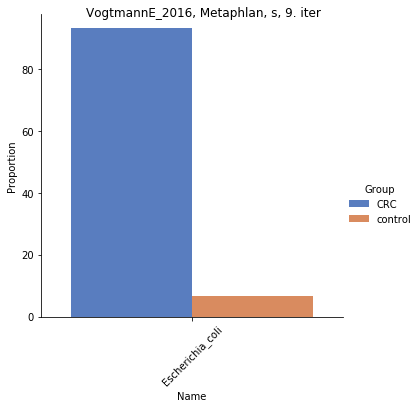

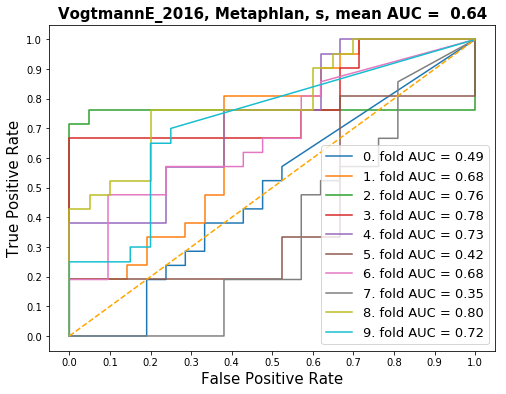

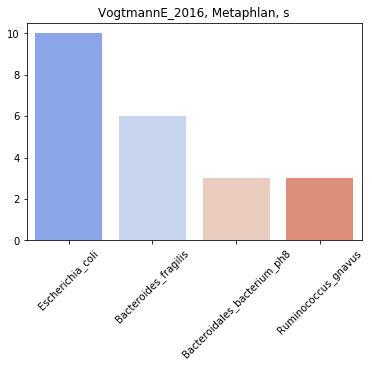

In [547]:
result = run("VogtmannE_2016", "Metaphlan", "p", 30)
result = run("VogtmannE_2016", "Metaphlan", "c", 30)
result = run("VogtmannE_2016", "Metaphlan", "f", 30)
result = run("VogtmannE_2016", "Metaphlan", "g", 30)
result = run("VogtmannE_2016", "Metaphlan", "s", 30)